Dataset shape: (959, 16)

First few rows:
   DaysLateLast30_MinMax  EngagementSurvey_Scaled  Tenure_Years_Scaled  \
0                    0.0                 0.896907             0.573643   
1                    0.0                 0.989691             0.062016   
2                    0.0                 0.489691             0.062016   
3                    0.0                 0.958763             0.844961   
4                    0.0                 1.000000             0.348837   

   Absences_MinMax  Salary_Scaled  EmpSatisfaction_Scaled  Age_Scaled  \
0         0.000000       0.085190                    1.00    0.288889   
1         0.842105       0.289777                    0.50    0.400000   
2         0.105263       0.097139                    0.50    0.022222   
3         0.736842       0.097315                    1.00    0.155556   
4         0.052632       0.028197                    0.75    0.066667   

   EmploymentStatus_Encoded  Sex_Encoded  MaritalDesc_Married  \
0        

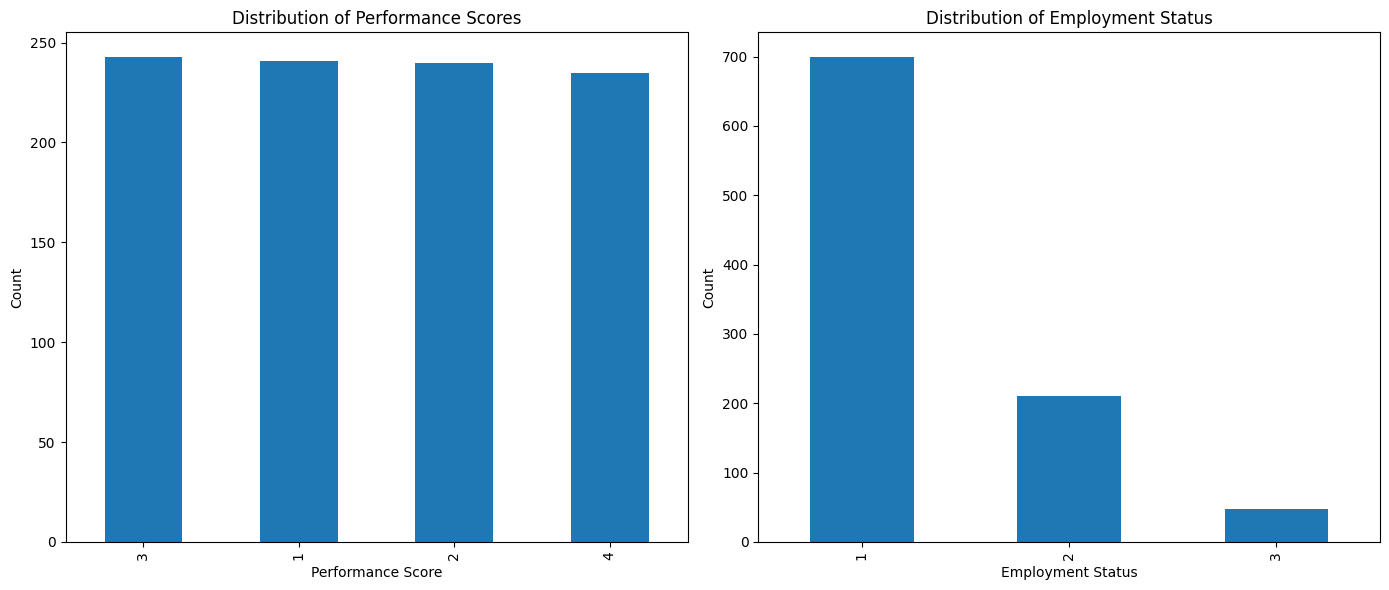

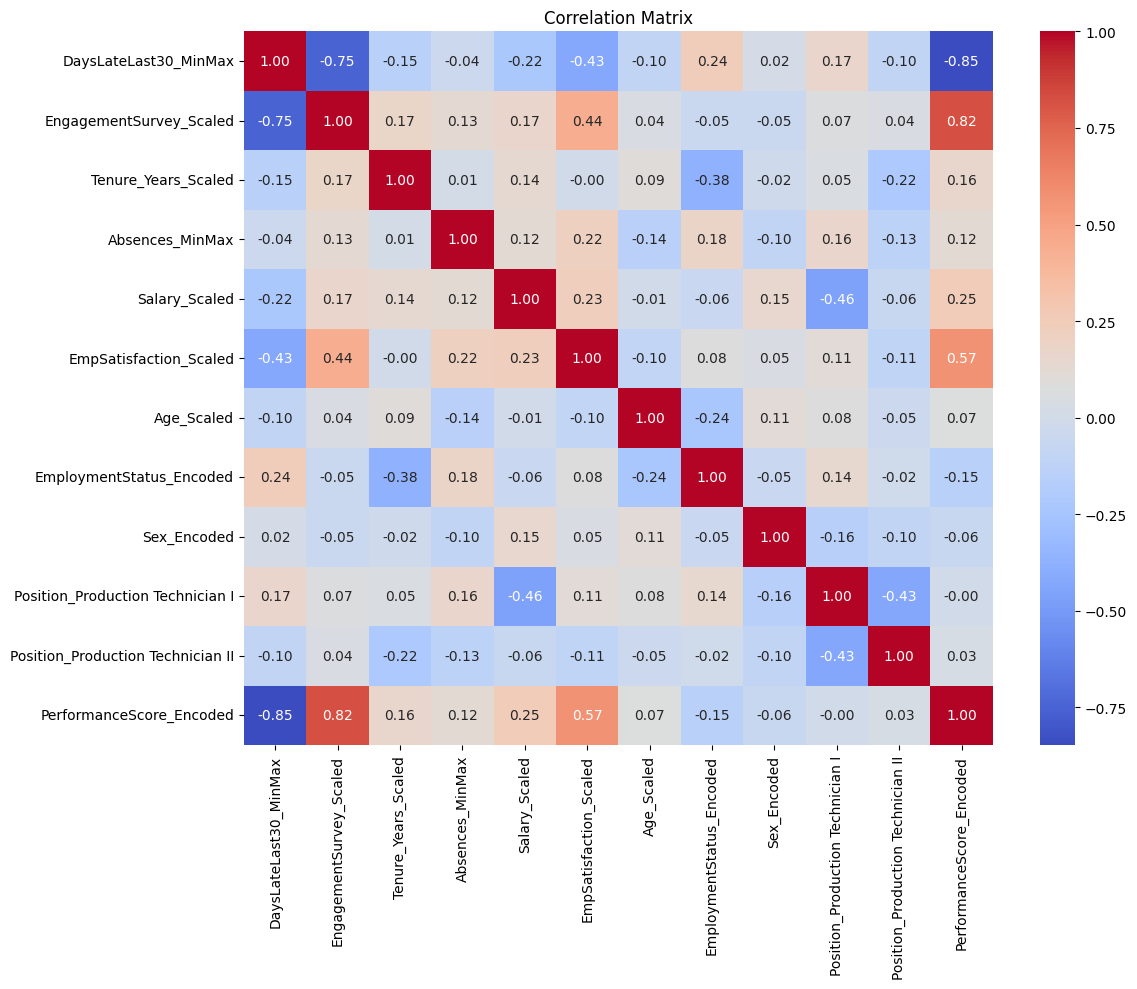


Numerical columns: ['DaysLateLast30_MinMax', 'EngagementSurvey_Scaled', 'Tenure_Years_Scaled', 'Absences_MinMax', 'Salary_Scaled', 'EmpSatisfaction_Scaled', 'Age_Scaled', 'EmploymentStatus_Encoded', 'Sex_Encoded', 'Position_Production Technician I', 'Position_Production Technician II']
Categorical columns: ['MaritalDesc_Married', 'RaceDesc_Black or African American', 'MaritalDesc_Single', 'RecruitmentSource_LinkedIn']

Training set shape: (767, 15), Testing set shape: (192, 15)
Fitting 5 folds for each of 324 candidates, totalling 1620 fits

Best parameters: {'classifier__colsample_bytree': 0.8, 'classifier__learning_rate': 0.1, 'classifier__max_depth': 7, 'classifier__min_child_weight': 1, 'classifier__n_estimators': 200, 'classifier__subsample': 1.0}
Best cross-validation score: 0.9413

Model Evaluation:
Accuracy: 0.9322916666666666

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        48
           1       

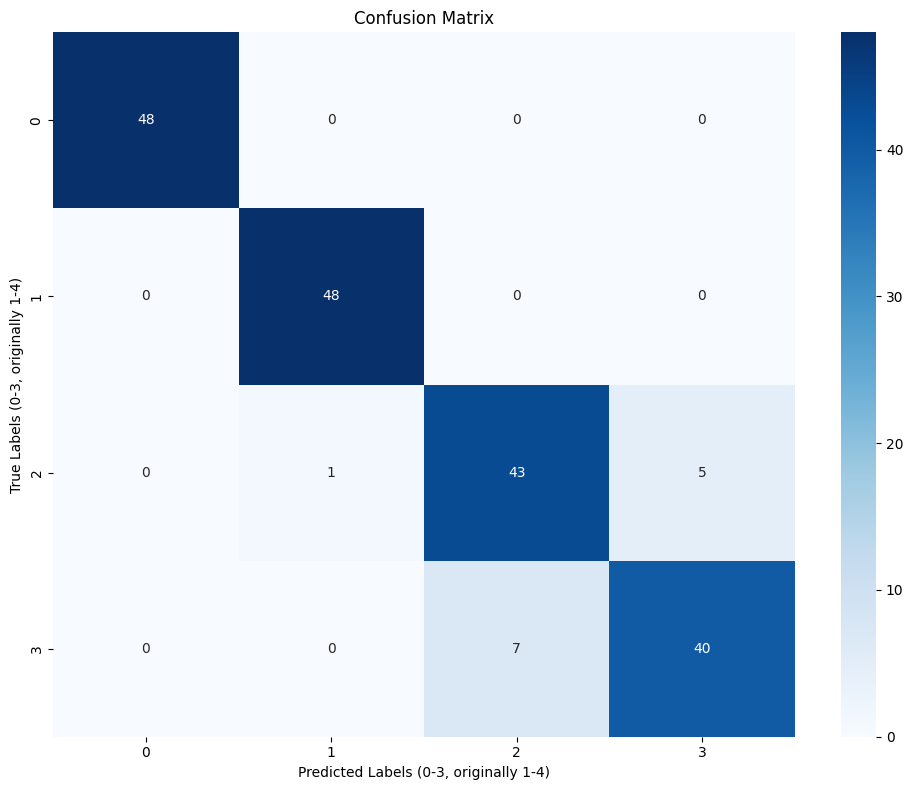


Model saved as 'gb_employee_model.pkl'

Note: Since we subtracted 1 from the target values for training,
when using this model for predictions, you should add 1 to the predictions
to get the original performance score scale (1-4).

Example of prediction with conversion back to original scale:
y_pred_original_scale = best_model.predict(X_test) + 1
Could not generate feature importance plot: All arrays must be of the same length
Trying permutation importance instead...


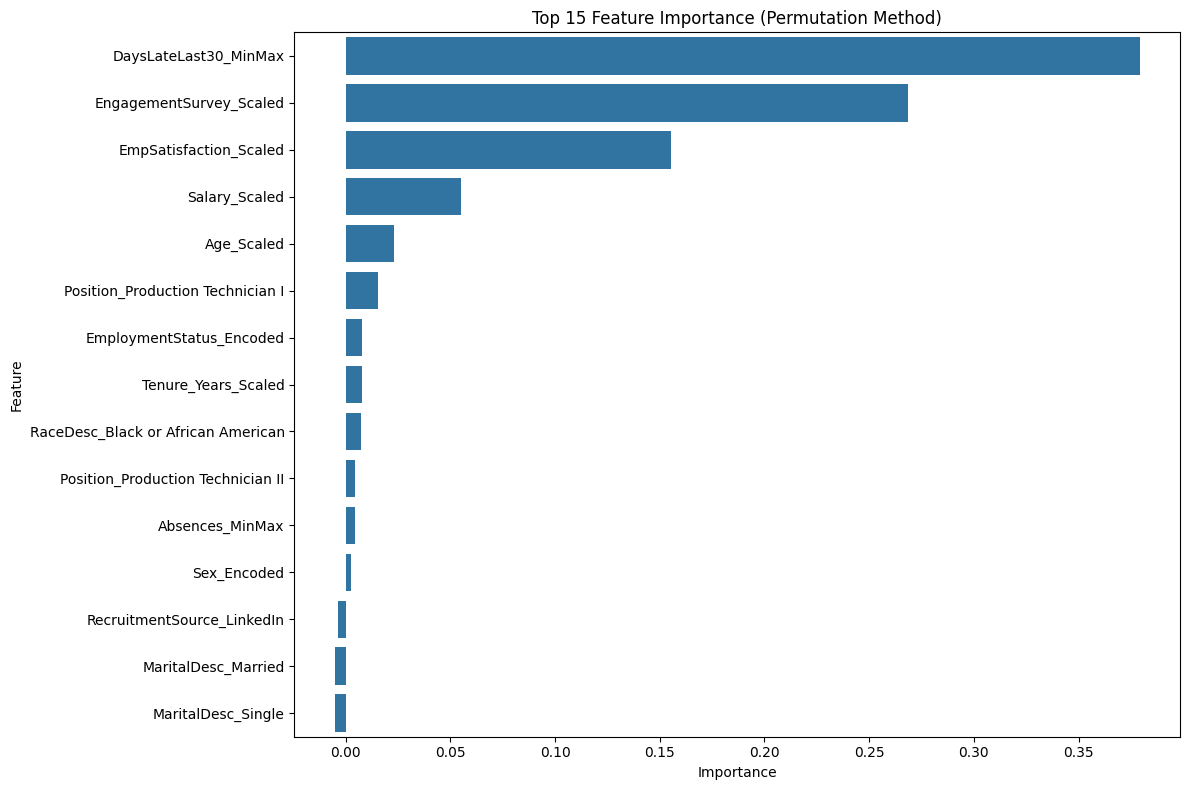

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
5 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py", line 662, in fit
    self._final_estimator.fit(Xt, y, **last

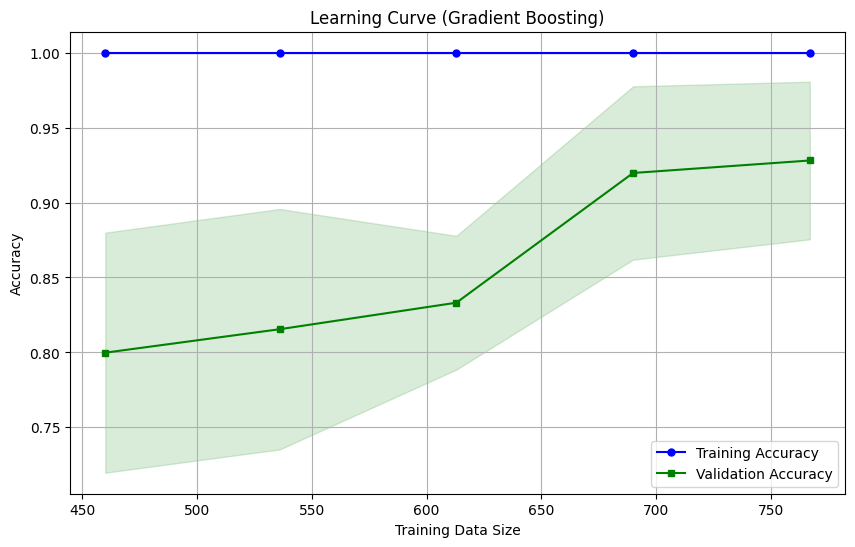

In [ ]:
# Gradient Boosting Training for Employee Dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from xgboost import XGBClassifier
import pickle

# Read the dataset
df = pd.read_csv('employee_data_adasyn.csv')

# Display basic information
print("Dataset shape:", df.shape)
print("\nFirst few rows:")
print(df.head())
print("\nData types:")
print(df.dtypes)
print("\nSummary statistics:")
print(df.describe())

# Check for missing values
print("\nMissing values count:")
print(df.isnull().sum())

# Convert string True/False to boolean for relevant columns
string_bool_columns = [col for col in df.columns if df[col].dtype == 'object' and
                       set(df[col].unique()).issubset({"True", "False"})]
for col in string_bool_columns:
    df[col] = df[col].map({"True": True, "False": False})

# Visualize distribution of potential target variables
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Assuming PerformanceScore_Encoded is the target variable
df['PerformanceScore_Encoded'].value_counts().plot(kind='bar', ax=axes[0])
axes[0].set_title('Distribution of Performance Scores')
axes[0].set_xlabel('Performance Score')
axes[0].set_ylabel('Count')

# Employment Status distribution
df['EmploymentStatus_Encoded'].value_counts().plot(kind='bar', ax=axes[1])
axes[1].set_title('Distribution of Employment Status')
axes[1].set_xlabel('Employment Status')
axes[1].set_ylabel('Count')

plt.tight_layout()
plt.show()

# Correlation analysis
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
plt.figure(figsize=(12, 10))
sns.heatmap(df[numeric_cols].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()

# Define features and target variable
X = df.drop('PerformanceScore_Encoded', axis=1)
y = df['PerformanceScore_Encoded']

# XGBoost expects classes to start from 0, but our data is 1-4
# Subtract 1 from the target to make it 0-based (0, 1, 2, 3)
y = y - 1

# Identify numerical and categorical columns
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = X.select_dtypes(include=['bool', 'object']).columns.tolist()

print("\nNumerical columns:", numerical_cols)
print("Categorical columns:", categorical_cols)

# Create a preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_cols)
    ])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"\nTraining set shape: {X_train.shape}, Testing set shape: {X_test.shape}")

# Create a Gradient Boosting pipeline with preprocessing
gb_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(random_state=42, eval_metric='mlogloss'))
])

# Define hyperparameters for grid search
param_grid = {
    'classifier__n_estimators': [50, 100, 200],
    'classifier__learning_rate': [0.01, 0.1, 0.3],
    'classifier__max_depth': [3, 5, 7],
    'classifier__subsample': [0.8, 1.0],
    'classifier__colsample_bytree': [0.8, 1.0],
    'classifier__min_child_weight': [1, 3, 5]
}

# Perform grid search with cross-validation
# Note: If grid search takes too long, you can reduce the number of parameter combinations
# or use RandomizedSearchCV instead
from sklearn.model_selection import RandomizedSearchCV

# You can use either GridSearchCV (exhaustive) or RandomizedSearchCV (faster)
# Uncomment the one you want to use

# Option 1: Grid Search (tries all combinations - can be slow with many parameters)
grid_search = GridSearchCV(gb_pipeline, param_grid, cv=5, scoring='accuracy', verbose=1)

# Option 2: Randomized Search (faster alternative that samples parameter combinations)
# grid_search = RandomizedSearchCV(gb_pipeline, param_grid, n_iter=20, cv=5,
#                                 scoring='accuracy', verbose=1, random_state=42)

grid_search.fit(X_train, y_train)

# Print the best parameters and best score
print("\nBest parameters:", grid_search.best_params_)
print("Best cross-validation score: {:.4f}".format(grid_search.best_score_))

# Use the best model to make predictions
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Evaluate the model
print("\nModel Evaluation:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix visualization
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels (0-3, originally 1-4)')
plt.ylabel('True Labels (0-3, originally 1-4)')
plt.tight_layout()
plt.show()

# Save the best model
with open('gb_employee_model.pkl', 'wb') as file:
    pickle.dump(best_model, file)
print("\nModel saved as 'gb_employee_model.pkl'")

# Note: For prediction on new data, remember to add 1 to convert back to original scale
print("\nNote: Since we subtracted 1 from the target values for training,")
print("when using this model for predictions, you should add 1 to the predictions")
print("to get the original performance score scale (1-4).")

# Example of prediction and conversion back to original scale (if needed)
print("\nExample of prediction with conversion back to original scale:")
print("y_pred_original_scale = best_model.predict(X_test) + 1")

# Feature importance analysis
# Feature importance analysis
# Get feature names after one-hot encoding - compatible with scikit-learn versions
feature_names = []
# Check if using newer or older scikit-learn API
if hasattr(preprocessor, 'transformers_'):
    # Older scikit-learn versions
    for name, transformer, columns in preprocessor.transformers_:
        if name == 'num':
            feature_names.extend(columns)
        elif name == 'cat' and hasattr(transformer, 'get_feature_names_out'):
            feature_names.extend([f"{col}_{cat}" for col in columns for cat in
                                transformer.categories_[0][1:]])  # Skip first category due to drop='first'
else:
    # Newer scikit-learn versions
    for name, transformer, columns in preprocessor.transformers:
        if name == 'num':
            feature_names.extend(columns)
        elif name == 'cat' and hasattr(transformer, 'get_feature_names_out'):
            try:
                # For even newer versions
                cat_features = transformer.get_feature_names_out(columns)
                feature_names.extend(cat_features)
            except:
                # Fallback if get_feature_names_out doesn't work as expected
                for col in columns:
                    if hasattr(transformer, 'categories_'):
                        feature_names.extend([f"{col}_{cat}" for cat in
                                             transformer.categories_[0][1:]])  # Skip first category due to drop='first'

# Get feature importances from the XGBoost model
try:
    importances = best_model.named_steps['classifier'].feature_importances_

    # Create a DataFrame for visualization
    feature_importance = pd.DataFrame({
        'Feature': feature_names[:len(importances)],  # Ensure lengths match
        'Importance': importances
    })
    feature_importance = feature_importance.sort_values('Importance', ascending=False)

    # Plot top 15 features
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', data=feature_importance.head(15))
    plt.title('Top 15 Feature Importance (Gradient Boosting)')
    plt.tight_layout()
    plt.show()
except Exception as e:
    print(f"Could not generate feature importance plot: {e}")
    # Alternative: Get feature importance using permutation importance
    from sklearn.inspection import permutation_importance

    print("Trying permutation importance instead...")
    perm_importance = permutation_importance(best_model, X_test, y_test, n_repeats=10, random_state=42)
    feature_importance = pd.DataFrame(
        {'Feature': X.columns, 'Importance': perm_importance.importances_mean}
    )
    feature_importance = feature_importance.sort_values('Importance', ascending=False)

    # Plot top 15 features
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', data=feature_importance.head(15))
    plt.title('Top 15 Feature Importance (Permutation Method)')
    plt.tight_layout()
    plt.show()

# Learning curve visualization
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(
    best_model, X, y, cv=5, train_sizes=np.linspace(0.1, 1.0, 10),
    scoring='accuracy', n_jobs=-1)

# Calculate mean and standard deviation
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot learning curve
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='Training Accuracy')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')
plt.plot(train_sizes, test_mean, color='green', marker='s', markersize=5, label='Validation Accuracy')
plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')
plt.title('Learning Curve (Gradient Boosting)')
plt.xlabel('Training Data Size')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score
from sklearn.feature_selection import SelectFromModel
import pickle

# Load the dataset
# Replace 'employee_data_adasyn.csv' with your actual file path
df = pd.read_csv('employee_data_adasyn.csv')

# Convert string True/False to boolean for relevant columns
string_bool_columns = [col for col in df.columns if df[col].dtype == 'object' and
                       set(df[col].unique()).issubset({"True", "False"})]
for col in string_bool_columns:
    df[col] = df[col].map({"True": True, "False": False})

# Define features and target variable
X = df.drop('PerformanceScore_Encoded', axis=1)
y = df['PerformanceScore_Encoded']

# Identify numerical and categorical columns
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = X.select_dtypes(include=['bool', 'object']).columns.tolist()

print("Numerical columns:", len(numerical_cols))
print("Categorical columns:", len(categorical_cols))

# Create a preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_cols)
    ])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training set shape: {X_train.shape}, Testing set shape: {X_test.shape}")

# Calculate class weights to address class-specific overfitting
# We'll use 'balanced' which automatically adjusts weights inversely proportional to class frequencies
# This will give more weight to classes 3 and 4 (indices 2 and 3) which are overfit

# =================================================================
# Create an further optimized Random Forest model with recommended parameters
# =================================================================

# Implementing the enhanced parameter changes:
# 1. Keep max_depth at 15 (already optimal)
# 2. Further increase min_samples_split from 10 to 15
# 3. Further increase min_samples_leaf from 4 to 6
# 4. Reduce n_estimators from 200 to 150
# 5. Add class_weight='balanced' to address class-specific overfitting

further_optimized_rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('feature_selector', SelectFromModel(RandomForestClassifier(random_state=42), threshold="median")),
    ('classifier', RandomForestClassifier(
        n_estimators=150,          # Reduced from 200 to 150
        max_depth=15,              # Kept at optimal value
        min_samples_split=15,      # Increased from 10 to 15
        min_samples_leaf=6,        # Increased from 4 to 6
        class_weight='balanced',   # Added to address class-specific issues
        random_state=42
    ))
])

# Fit the optimized model
print("\nFitting further optimized Random Forest model...")
further_optimized_rf_pipeline.fit(X_train, y_train)

# Make predictions
y_pred = further_optimized_rf_pipeline.predict(X_test)
y_pred_proba = further_optimized_rf_pipeline.predict_proba(X_test)

# Evaluate the model
print("\n===== Further Optimized Model Evaluation =====")
print("Accuracy:", accuracy_score(y_test, y_pred))

# Calculate ROC AUC for multi-class
try:
    roc_auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr')
    print("ROC AUC Score:", roc_auc)
except:
    print("Could not calculate ROC AUC score.")

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(cm)

# Evaluate on training data to check for overfitting
train_pred = further_optimized_rf_pipeline.predict(X_train)
train_accuracy = accuracy_score(y_train, train_pred)

print("\nTraining Accuracy:", train_accuracy)
print("Testing Accuracy:", accuracy_score(y_test, y_pred))
print("Accuracy Gap:", train_accuracy - accuracy_score(y_test, y_pred))

# Cross-validation to check model stability
cv_scores = cross_val_score(further_optimized_rf_pipeline, X, y, cv=5)
print("\nCross-validation scores:", cv_scores)
print("Mean CV Accuracy:", cv_scores.mean())
print("CV Standard Deviation:", cv_scores.std())

# =================================================================
# Create class-specific models for problematic classes
# =================================================================

print("\n\n===== Creating Class-Specific Models =====")
print("This approach creates binary classifiers for the problematic classes")

# Create binary classification problems for classes 3 and 4 (indices 2 and 3)
# For class 3
y_class3 = (y == 3).astype(int)  # Convert to binary problem: class 3 vs rest

# For class 4
y_class4 = (y == 4).astype(int)  # Convert to binary problem: class 4 vs rest

# Create and train class-specific models
class3_model = Pipeline([
    ('preprocessor', preprocessor),
    ('feature_selector', SelectFromModel(RandomForestClassifier(random_state=42), threshold="median")),
    ('classifier', RandomForestClassifier(
        n_estimators=100,
        max_depth=10,
        min_samples_split=20,
        min_samples_leaf=8,
        random_state=42
    ))
])

class4_model = Pipeline([
    ('preprocessor', preprocessor),
    ('feature_selector', SelectFromModel(RandomForestClassifier(random_state=42), threshold="median")),
    ('classifier', RandomForestClassifier(
        n_estimators=100,
        max_depth=10,
        min_samples_split=20,
        min_samples_leaf=8,
        random_state=42
    ))
])

# Train the class-specific models
print("Training class 3 specific model...")
class3_model.fit(X_train, y_train == 3)

print("Training class 4 specific model...")
class4_model.fit(X_train, y_train == 4)

# Evaluate class-specific models
class3_pred = class3_model.predict(X_test)
class3_accuracy = accuracy_score(y_test == 3, class3_pred)
print("\nClass 3 Binary Classifier Accuracy:", class3_accuracy)

class4_pred = class4_model.predict(X_test)
class4_accuracy = accuracy_score(y_test == 4, class4_pred)
print("Class 4 Binary Classifier Accuracy:", class4_accuracy)

# =================================================================
# Save models
# =================================================================

# Save the further optimized model
model_filename = 'further_optimized_rf_employee_model.pkl'
with open(model_filename, 'wb') as file:
    pickle.dump(further_optimized_rf_pipeline, file)
print(f"\nFurther optimized Random Forest model saved as '{model_filename}'")

# Save class-specific models
with open('class3_specific_model.pkl', 'wb') as file:
    pickle.dump(class3_model, file)
print("Class 3 specific model saved as 'class3_specific_model.pkl'")

with open('class4_specific_model.pkl', 'wb') as file:
    pickle.dump(class4_model, file)
print("Class 4 specific model saved as 'class4_specific_model.pkl'")

# =================================================================
# Data Augmentation and Enhancement Recommendations
# =================================================================

print("\n\n===== Data Enhancement Recommendations =====")
print("""
To further improve model performance, especially for classes 3 and 4, consider the following data enhancements:

1. Data Collection:
   - Gather more training examples specifically for classes 3 and 4
   - Ensure diverse examples that cover edge cases

2. Data Augmentation Techniques:
   - SMOTE (Synthetic Minority Over-sampling Technique)
   - ADASYN (Adaptive Synthetic sampling)
   - Random over-sampling with replacement for minority classes

3. Feature Engineering:
   - Create interaction features between important variables
   - Consider polynomial features for numerical variables
   - Explore domain-specific feature transformations

4. Data Cleaning:
   - Check for noise or mislabeled examples in classes 3 and 4
   - Consider outlier detection and treatment
   - Verify data quality and consistency

Implementation of these recommendations requires domain knowledge and additional data processing.
""")

print("\nDone! The Random Forest model has been further optimized with the enhanced parameters:")
print("- max_depth=15 (maintained at optimal value)")
print("- min_samples_split=15 (increased from 10)")
print("- min_samples_leaf=6 (increased from 4)")
print("- n_estimators=150 (reduced from 200)")
print("- Added class_weight='balanced'")
print("- Added feature selection with median threshold")
print("- Created separate binary classifiers for problematic classes 3 and 4")

Numerical columns: 11
Categorical columns: 4
Training set shape: (767, 15), Testing set shape: (192, 15)

Fitting further optimized Random Forest model...

===== Further Optimized Model Evaluation =====
Accuracy: 0.9010416666666666
ROC AUC Score: 0.9801229951243913

Classification Report:
              precision    recall  f1-score   support

           1       1.00      0.98      0.99        48
           2       0.96      1.00      0.98        48
           3       0.82      0.82      0.82        49
           4       0.83      0.81      0.82        47

    accuracy                           0.90       192
   macro avg       0.90      0.90      0.90       192
weighted avg       0.90      0.90      0.90       192


Confusion Matrix:
[[47  1  0  0]
 [ 0 48  0  0]
 [ 0  1 40  8]
 [ 0  0  9 38]]

Training Accuracy: 0.9634941329856584
Testing Accuracy: 0.9010416666666666
Accuracy Gap: 0.06245246631899182

Cross-validation scores: [0.80729167 0.89583333 0.93229167 0.921875   0.88481675]
Me

Loading dataset...
Loading model...

Model loaded successfully!
Model type: <class 'sklearn.pipeline.Pipeline'>
Pipeline steps: dict_keys(['preprocessor', 'classifier'])
n_estimators: 200
learning_rate: 0.1
max_depth: 7
subsample: 1.0
colsample_bytree: 0.8
Training set size: 767 samples, 15 features
Test set size: 192 samples, 15 features

Class distribution:
Training set:
  Class 2 (original 3): 25.29% (194 samples)
  Class 0 (original 1): 25.16% (193 samples)
  Class 1 (original 2): 25.03% (192 samples)
  Class 3 (original 4): 24.51% (188 samples)
Test set:
  Class 2 (original 3): 25.52% (49 samples)
  Class 1 (original 2): 25.00% (48 samples)
  Class 0 (original 1): 25.00% (48 samples)
  Class 3 (original 4): 24.48% (47 samples)
COMPREHENSIVE OVERFITTING ANALYSIS FOR GRADIENT BOOSTING

1. ACCURACY GAP ANALYSIS
Training Accuracy: 1.0000
Test Accuracy: 0.9323
Accuracy Gap (Δ): 0.0677

Detailed Per-Class Accuracy Analysis:
Class      Original   Train Acc  Test Acc   Gap        Status  

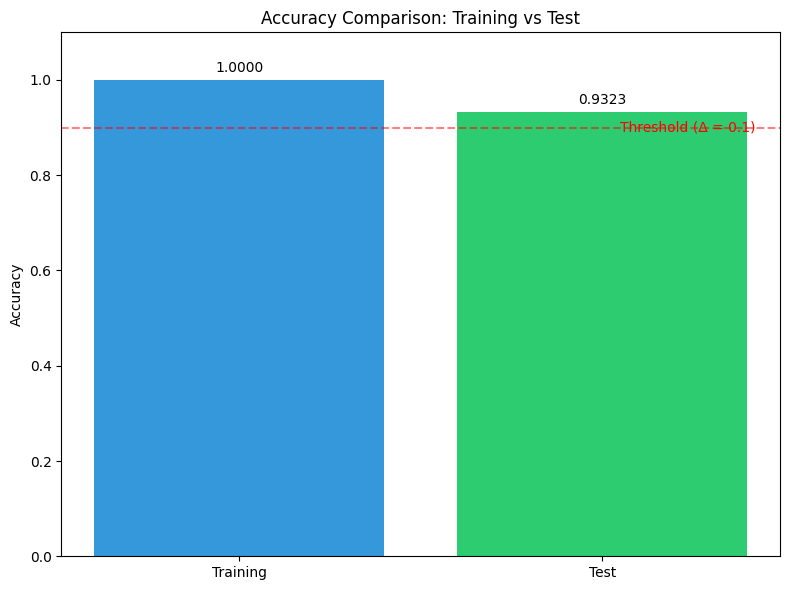


2. LEARNING CURVES ANALYSIS
Average gap between training and validation: 0.1364
Latest gap (at maximum training data): 0.0563
Sum of gaps across all training sizes: 0.6819
Are curves converging? Yes
Are curves stable? Yes

Detailed Learning Curve Data:
Training Size   Train Score     Val Score       Gap            
------------------------------------------------------------
352820          1.0000         0.8061         0.1939
411112          1.0000         0.8186         0.1814
470171          1.0000         0.8279         0.1721
529230          1.0000         0.9218         0.0782
588289          1.0000         0.9437         0.0563

Learning Curve Interpretation:
- Converging and stable curves indicate good generalization
- Starting gap (with 352820 samples): 0.1939
- Ending gap (with 588289 samples): 0.0563

✅ No significant overfitting detected based on learning curves (latest gap ≤ 0.1)
   The model seems to generalize well as the gap is acceptable.


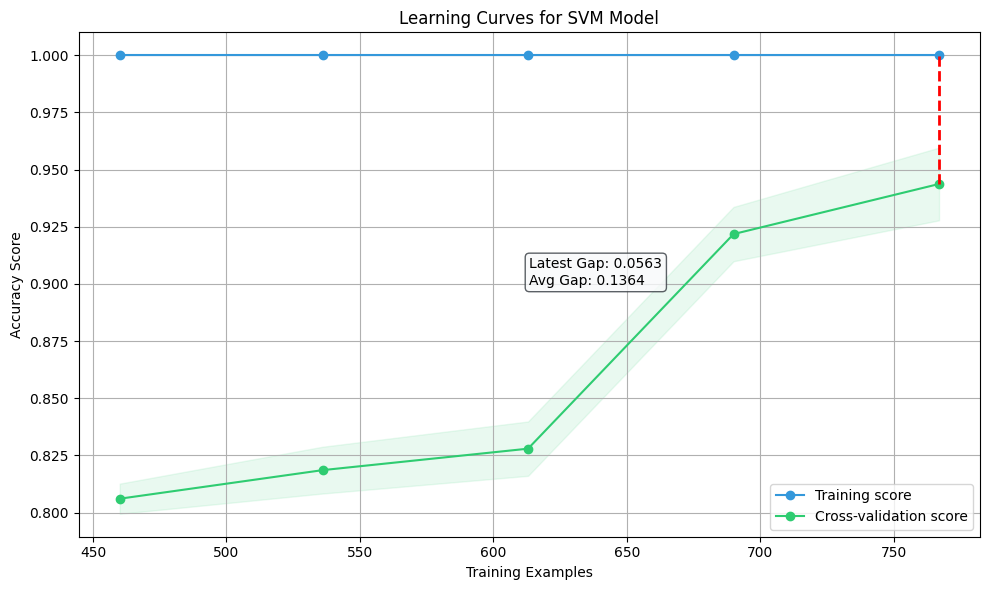


3. ROC ANALYSIS AND AUC COMPARISON
Training Set Macro-AUC: 1.0000
Test Set Macro-AUC: 0.9906
AUC Gap (Δ): 0.0094

Detailed Class-Specific ROC Analysis:
Class      Original   Train AUC    Test AUC     AUC Gap      Status    
----------------------------------------------------------------------
0          1          1.0000      1.0000      0.0000      ✅ OK
1          2          1.0000      1.0000      -0.0000      ✅ OK
2          3          1.0000      0.9813      0.0187      ✅ OK
3          4          1.0000      0.9812      0.0188      ✅ OK

Optimal Operating Points (Test Set):
Class 0 (original 1): Threshold=0.9228, Sensitivity=1.0000, Specificity=1.0000
Class 1 (original 2): Threshold=0.5350, Sensitivity=1.0000, Specificity=1.0000
Class 2 (original 3): Threshold=0.1382, Sensitivity=1.0000, Specificity=0.9231
Class 3 (original 4): Threshold=0.0988, Sensitivity=0.9362, Specificity=0.9034

✅ No significant overfitting detected based on AUC gap (ΔAUC ≤ 0.05)
   The AUC gap of 0.94% sug

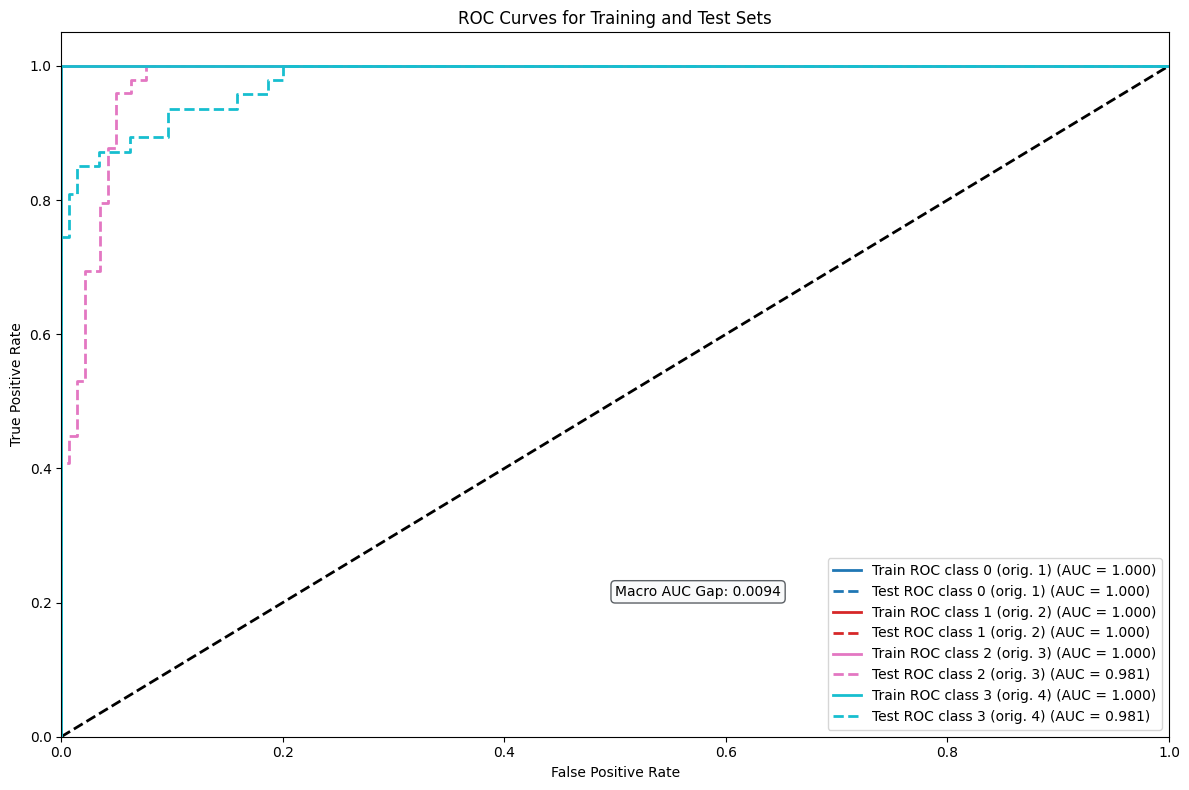

<Figure size 1000x600 with 0 Axes>

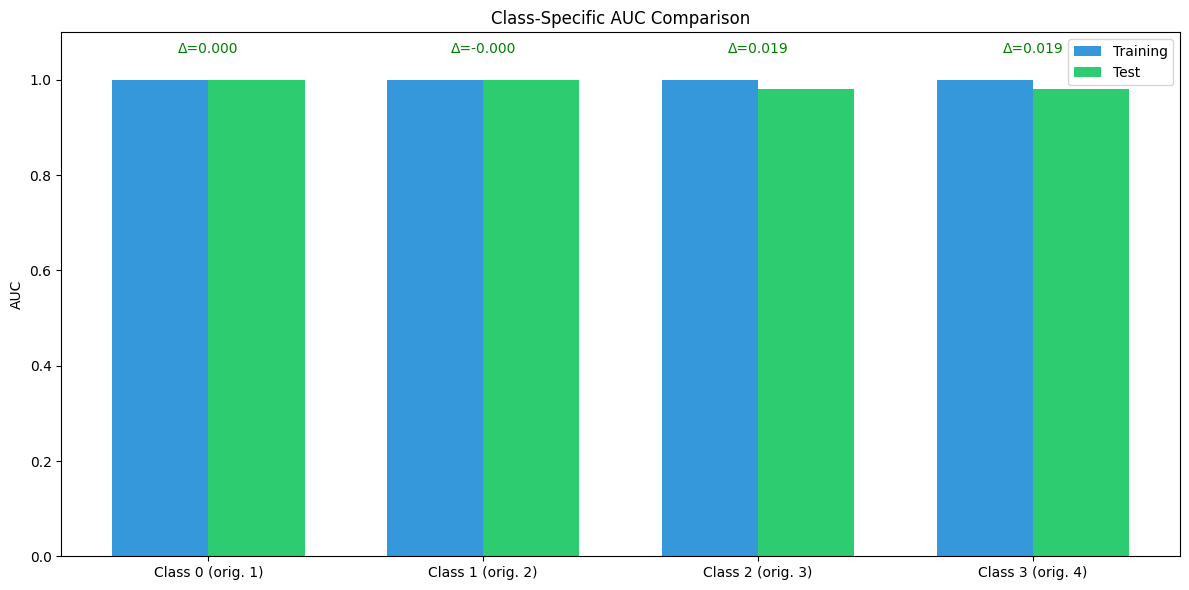


4. CLASS-SPECIFIC METRICS ANALYSIS

Detailed Class-specific Metrics:
Class      Original   Metric     Train      Test       Diff       Status    
----------------------------------------------------------------------
0          1          Precision  1.0000    1.0000    0.0000    ✅ OK
                      Recall     1.0000    1.0000    0.0000    ✅ OK
                      F1-Score   1.0000    1.0000    0.0000    ✅ OK
----------------------------------------------------------------------
1          2          Precision  1.0000    0.9796    0.0204    ✅ OK
                      Recall     1.0000    1.0000    0.0000    ✅ OK
                      F1-Score   1.0000    0.9897    0.0103    ✅ OK
----------------------------------------------------------------------
2          3          Precision  1.0000    0.8600    0.1400    ⚠️ Issue
                      Recall     1.0000    0.8776    0.1224    ⚠️ Issue
                      F1-Score   1.0000    0.8687    0.1313    ⚠️ Issue
----------------

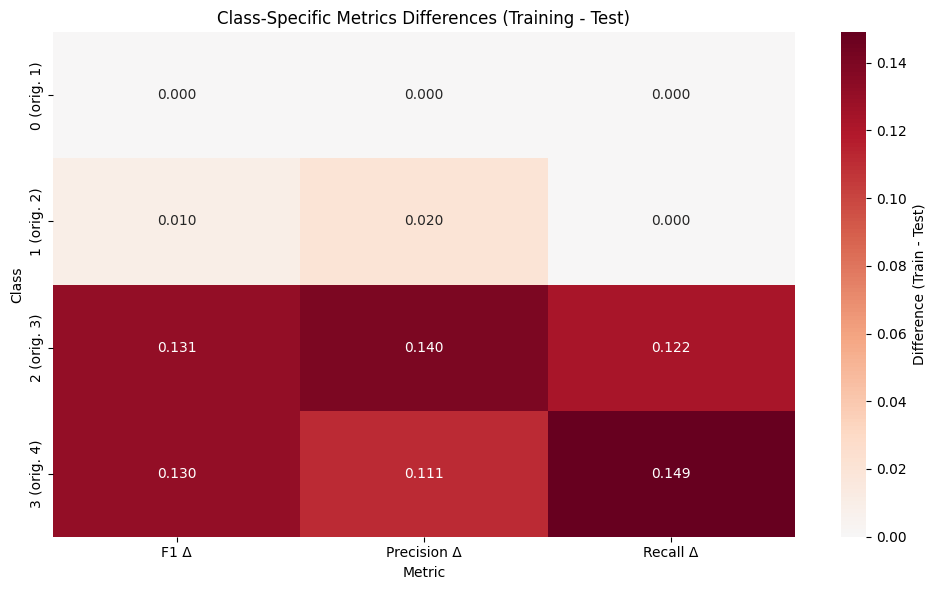


5. PREDICTION CONFIDENCE ANALYSIS

Confidence Statistics:
Statistic       Training        Test            Difference     
------------------------------------------------------------
Mean            0.9916        0.9516        0.0399
Median          0.9962        0.9943        0.0019
Min             0.8881        0.4812        0.4069
Max             0.9997        0.9997        0.0000
Std Dev         0.0121        0.1021        -0.0900

Confidence Distribution by Threshold:
Threshold  Training %      Test %          Difference      Status    
-----------------------------------------------------------------
≥ 0.5      100.00%         99.48%         0.52%           ✅ OK
≥ 0.6      100.00%         97.40%         2.60%           ✅ OK
≥ 0.7      100.00%         94.27%         5.73%           ✅ OK
≥ 0.8      100.00%         90.62%         9.38%           ✅ OK
≥ 0.9      99.87%         86.46%         13.41%           ⚠️ Issue
≥ 0.95     97.91%         78.65%         19.27%           ⚠️ Issue

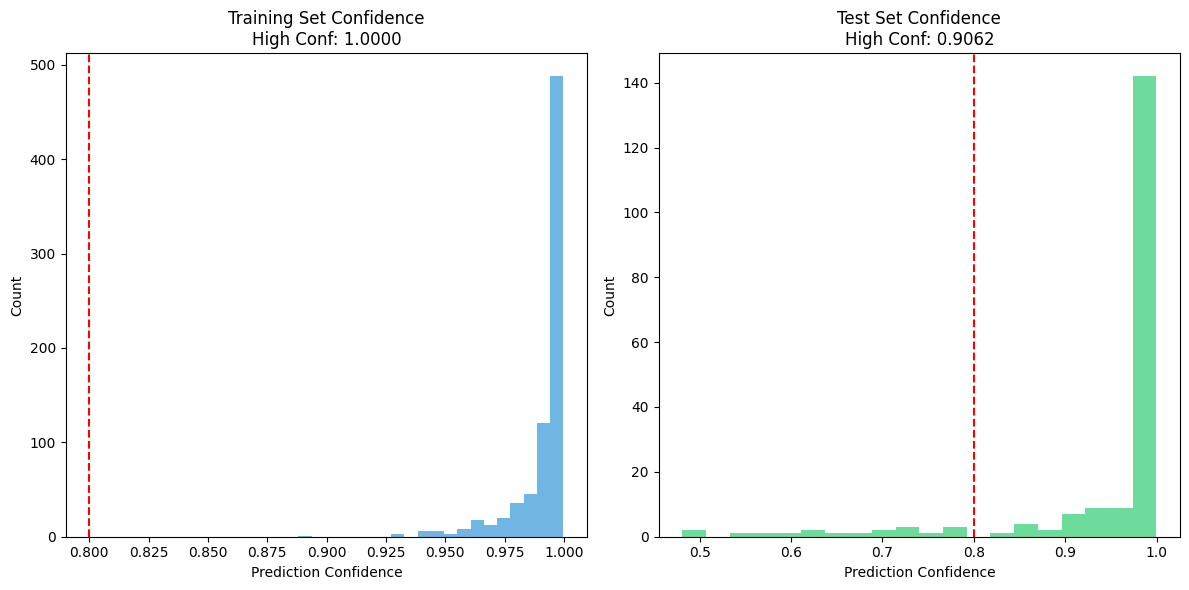

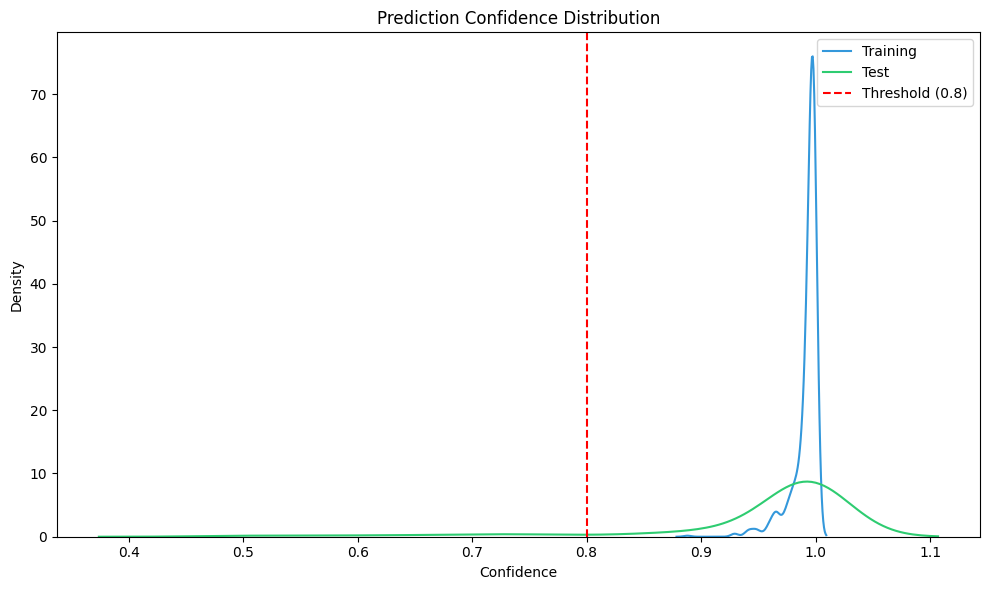


6. TREE-BASED PARAMETER ANALYSIS
Current parameters: n_estimators=200, max_depth=7, learning_rate=0.1

Analyzing effect of n_estimators (number of trees):
n_estimators Train Acc    Test Acc     Gap        Status    
--------------------------------------------------------
10           0.9583       0.8906       0.0677    ✅ OK
50           1.0000       0.9375       0.0625    ✅ OK
100          1.0000       0.9271       0.0729    ✅ OK
200          1.0000       0.9375       0.0625    ✅ OK
500          1.0000       0.9323       0.0677    ✅ OK

Analyzing effect of max_depth:
max_depth    Train Acc    Test Acc     Gap        Status    
--------------------------------------------------------
3            0.9974       0.9115       0.0859    ✅ OK
5            1.0000       0.9531       0.0469    ✅ OK
7            1.0000       0.9375       0.0625    ✅ OK
10           1.0000       0.9323       0.0677    ✅ OK
15           1.0000       0.9323       0.0677    ✅ OK


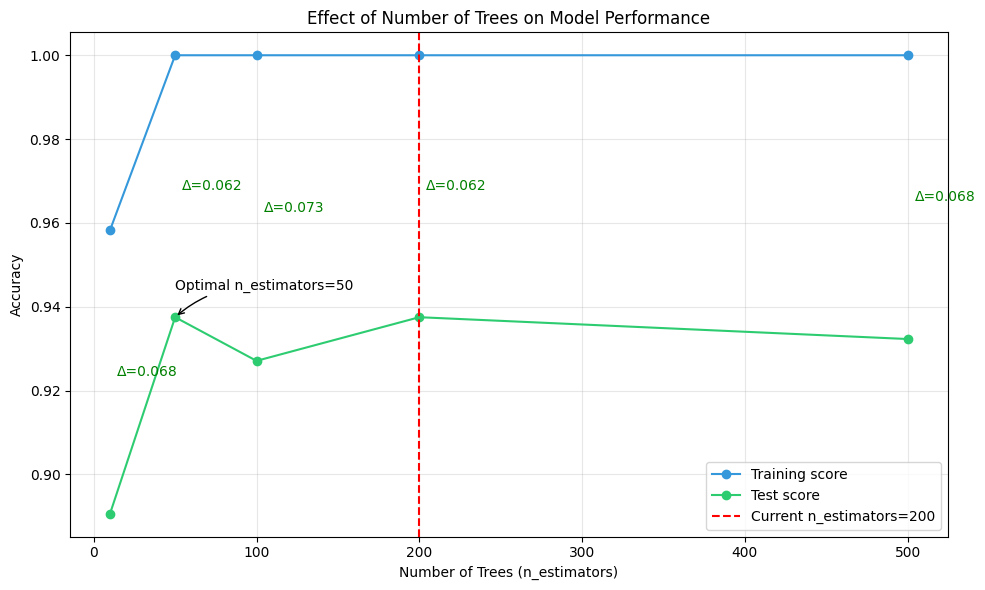

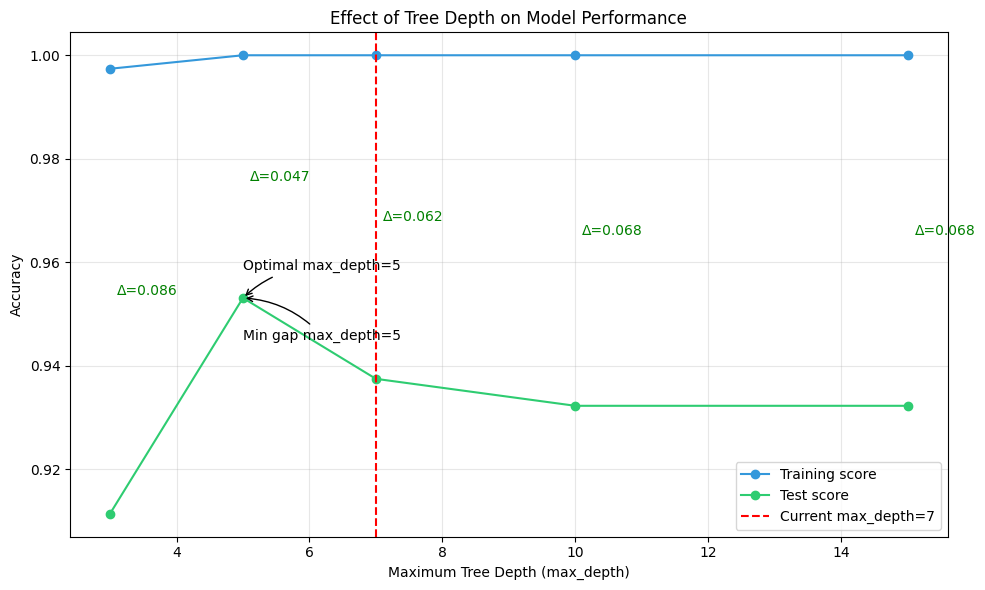


Parameter recommendations:

n_estimators (number of trees):
- Optimal for test accuracy: 50
  Train accuracy: 1.0000, Test accuracy: 0.9375, Gap: 0.0625

max_depth:
- Minimum gap (best generalization): 5
  Train accuracy: 1.0000, Test accuracy: 0.9531, Gap: 0.0469
- Optimal for test accuracy: 5
  Train accuracy: 1.0000, Test accuracy: 0.9531, Gap: 0.0469

Current model configuration:
- n_estimators: 200
- max_depth: 7
  Current train accuracy: 1.0000, test accuracy: 0.9375

⚠️ Recommendations for parameter adjustments:
- decrease n_estimators from 200 to 50 for better test accuracy
- Change max_depth from 7 to 5 for both better generalization and test accuracy

7. CROSS-VALIDATION STABILITY ASSESSMENT
Cross-validation scores: [0.921875   0.95833333 0.953125   0.92708333 0.95811518]
Mean accuracy: 0.9437
Standard deviation: 0.0159
Range: 0.0365
Minimum: 0.9219
Maximum: 0.9583
Coefficient of variation: 0.0168

Detailed Fold-by-Fold Analysis:
Fold   Accuracy   Precision  Recall     F1   

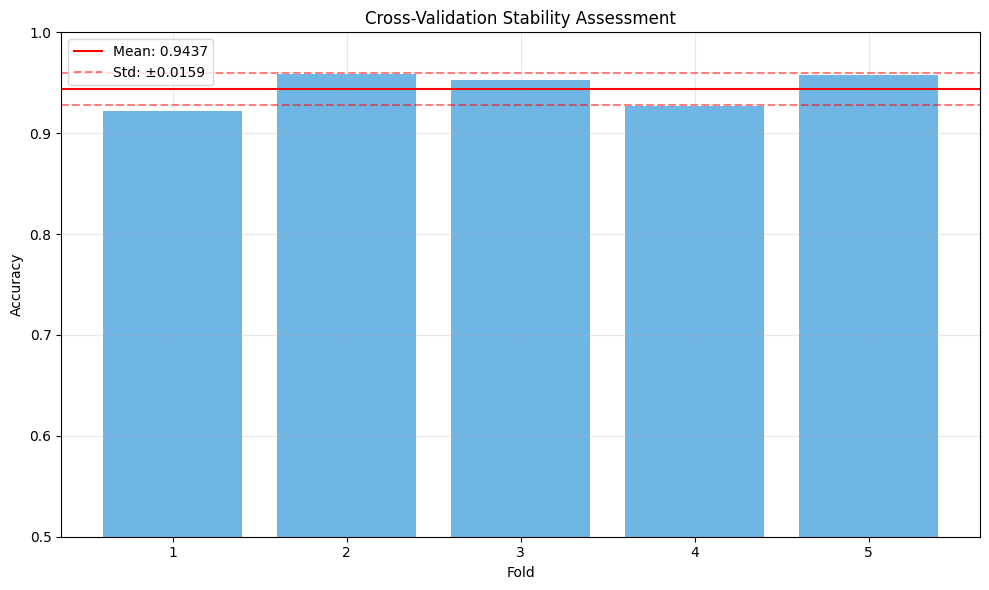

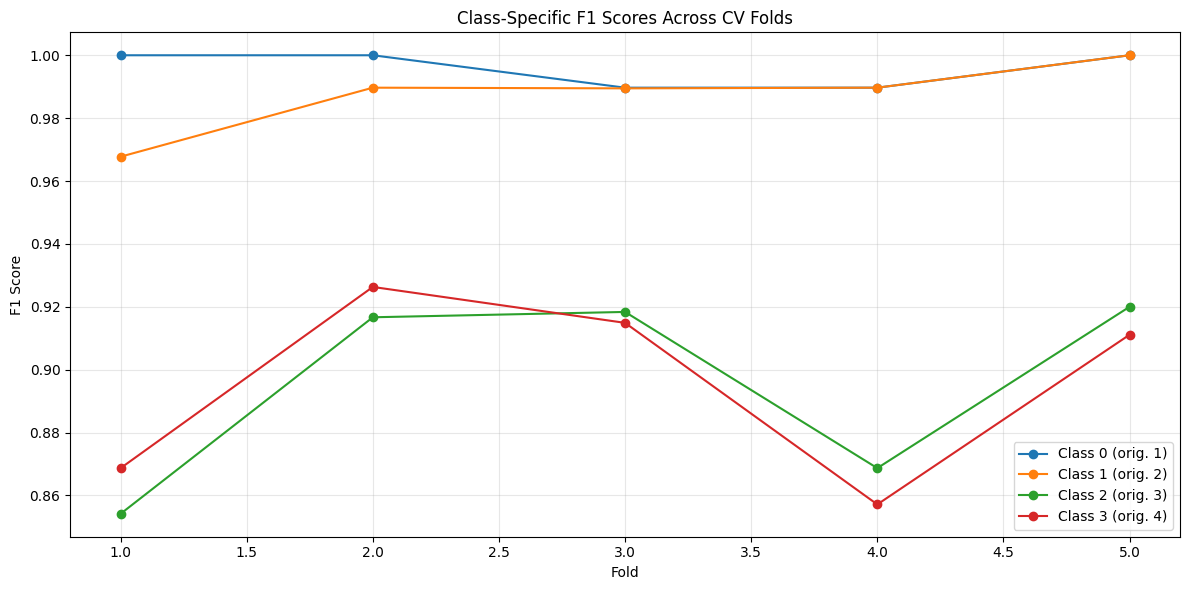


8. FEATURE IMPORTANCE ANALYSIS

Top 15 Important Features:
                                         Feature  Importance
0                     num__DaysLateLast30_MinMax    0.352353
1                   num__EngagementSurvey_Scaled    0.122912
7                  num__EmploymentStatus_Encoded    0.086063
5                    num__EmpSatisfaction_Scaled    0.082905
10        num__Position_Production Technician II    0.060306
12  cat__RaceDesc_Black or African American_True    0.052726
9          num__Position_Production Technician I    0.044067
4                             num__Salary_Scaled    0.034600
11                 cat__MaritalDesc_Married_True    0.033287
8                               num__Sex_Encoded    0.030429
6                                num__Age_Scaled    0.029690
2                       num__Tenure_Years_Scaled    0.020691
14          cat__RecruitmentSource_LinkedIn_True    0.019260
3                           num__Absences_MinMax    0.018777
13                  cat__

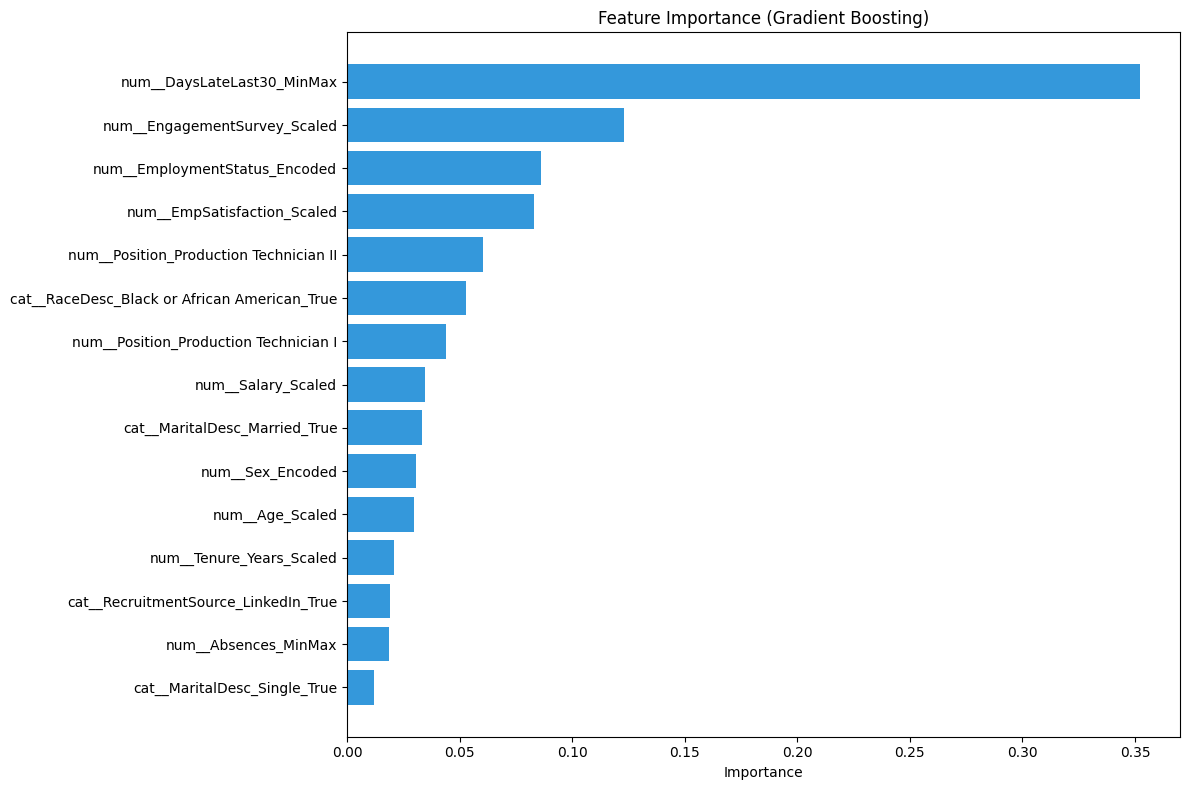

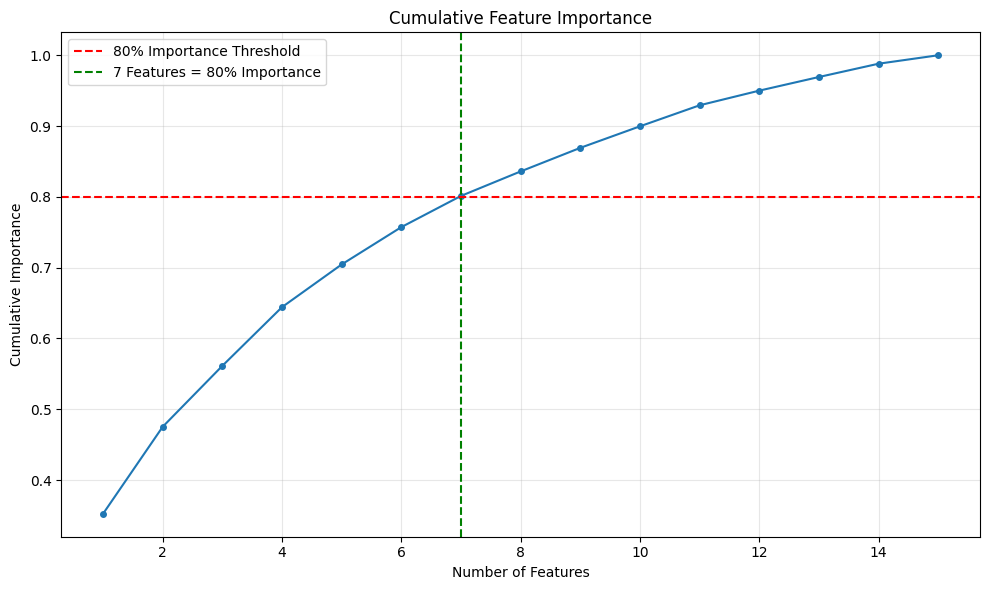


GRADIENT BOOSTING OVERFITTING ANALYSIS SUMMARY

Overfitting Indicators:
----------------------------------------------------------------------
Indicator                 Value      Status     Interpretation           
----------------------------------------------------------------------
Accuracy Gap              0.0677     ✅ OK       Acceptable gap           
Learning Curve Gap        0.0563     ✅ OK       Good generalization      
AUC Gap                   0.0094     ✅ OK       Consistent ranking       
Confidence Gap            0.0938     ✅ OK       Well-calibrated          
Cross-validation Stability 0.0159     ✅ OK       Stable performance       
----------------------------------------------------------------------

Class-specific overfitting detected in: [np.int64(3), np.int64(4)] (0-based: [np.int64(2), np.int64(3)])

🎉 OVERALL ASSESSMENT: No significant overfitting detected
The Gradient Boosting model generalizes well to unseen data with consistent performance across metrics.


In [4]:
# Overfitting Detection for Gradient Boosting Employee Model
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import learning_curve, StratifiedKFold, cross_val_score
from sklearn.metrics import (
    accuracy_score, roc_curve, auc, precision_recall_fscore_support,
    roc_auc_score, classification_report, confusion_matrix
)
from sklearn.preprocessing import label_binarize
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from xgboost import XGBClassifier
import pickle
import warnings
warnings.filterwarnings('ignore')

# Load the dataset
print("Loading dataset...")
df = pd.read_csv('employee_data_adasyn.csv')

# Convert string True/False to boolean for relevant columns
string_bool_columns = [col for col in df.columns if df[col].dtype == 'object' and
                       set(df[col].unique()).issubset({"True", "False"})]
for col in string_bool_columns:
    df[col] = df[col].map({"True": True, "False": False})

# Define features and target variable
X = df.drop('PerformanceScore_Encoded', axis=1)
y = df['PerformanceScore_Encoded'] - 1  # Convert to 0-based for XGBoost

print("Loading model...")
# Load the trained model - update the path to your saved model
model_path = 'gb_employee_model.pkl'
with open(model_path, 'rb') as file:
    best_model = pickle.load(file)

print("\nModel loaded successfully!")
print(f"Model type: {type(best_model)}")
print(f"Pipeline steps: {best_model.named_steps.keys()}")

# Get XGBoost parameters
xgb_params = best_model.named_steps['classifier'].get_params()
print(f"n_estimators: {xgb_params['n_estimators']}")
print(f"learning_rate: {xgb_params['learning_rate']}")
print(f"max_depth: {xgb_params['max_depth']}")
print(f"subsample: {xgb_params['subsample']}")
print(f"colsample_bytree: {xgb_params['colsample_bytree']}")

# Get the original data split that was used for training
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training set size: {X_train.shape[0]} samples, {X_train.shape[1]} features")
print(f"Test set size: {X_test.shape[0]} samples, {X_test.shape[1]} features")

# Print class distribution
train_class_dist = pd.Series(y_train).value_counts(normalize=True)
test_class_dist = pd.Series(y_test).value_counts(normalize=True)
print("\nClass distribution:")
print("Training set:")
for cls, pct in train_class_dist.items():
    print(f"  Class {cls} (original {cls+1}): {pct:.2%} ({sum(y_train == cls)} samples)")
print("Test set:")
for cls, pct in test_class_dist.items():
    print(f"  Class {cls} (original {cls+1}): {pct:.2%} ({sum(y_test == cls)} samples)")

# ========================= 1. Comparing Metrics on Training and Test Sets =========================
def check_accuracy_gap():
    # Get predictions on training and test sets
    y_train_pred = best_model.predict(X_train)
    y_test_pred = best_model.predict(X_test)

    # Calculate accuracies
    train_accuracy = accuracy_score(y_train, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    accuracy_gap = train_accuracy - test_accuracy

    print("\n1. ACCURACY GAP ANALYSIS")
    print(f"Training Accuracy: {train_accuracy:.4f}")
    print(f"Test Accuracy: {test_accuracy:.4f}")
    print(f"Accuracy Gap (Δ): {accuracy_gap:.4f}")

    # More detailed analysis
    print("\nDetailed Per-Class Accuracy Analysis:")
    classes = sorted(np.unique(y))

    print(f"{'Class':<10} {'Original':<10} {'Train Acc':<10} {'Test Acc':<10} {'Gap':<10} {'Status':<10}")
    print("-" * 60)

    for cls in classes:
        # Calculate per-class accuracy
        train_cls_acc = accuracy_score(y_train[y_train == cls], y_train_pred[y_train == cls])
        test_cls_acc = accuracy_score(y_test[y_test == cls], y_test_pred[y_test == cls])
        cls_gap = train_cls_acc - test_cls_acc

        status = "⚠️ Issue" if cls_gap > 0.1 else "✅ OK"
        print(f"{cls:<10} {cls+1:<10} {train_cls_acc:.4f}     {test_cls_acc:.4f}     {cls_gap:.4f}     {status}")

    # Add confusion matrices
    print("\nTraining Set Confusion Matrix:")
    train_cm = confusion_matrix(y_train, y_train_pred)
    print(pd.DataFrame(train_cm, index=classes, columns=classes))

    print("\nTest Set Confusion Matrix:")
    test_cm = confusion_matrix(y_test, y_test_pred)
    print(pd.DataFrame(test_cm, index=classes, columns=classes))

    if accuracy_gap > 0.1:
        print("\n⚠️ Potential overfitting detected! (Δ > 0.1)")
        print(f"   The model performs {accuracy_gap:.2%} better on training data compared to test data.")
        print("   This suggests the model may have learned noise or patterns specific to the training data.")
    else:
        print("\n✅ No significant overfitting detected based on accuracy gap (Δ ≤ 0.1)")
        print(f"   The gap of {accuracy_gap:.2%} is within acceptable limits for generalization.")

    # Visualization of accuracy comparison
    plt.figure(figsize=(8, 6))
    bars = plt.bar(['Training', 'Test'], [train_accuracy, test_accuracy], color=['#3498db', '#2ecc71'])
    plt.ylim(0, 1.1)
    plt.ylabel('Accuracy')
    plt.title('Accuracy Comparison: Training vs Test')

    # Add text labels above bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.4f}', ha='center', va='bottom')

    # Add a horizontal line for the threshold
    plt.axhline(y=train_accuracy - 0.1, color='r', linestyle='--', alpha=0.5)
    plt.text(1.05, train_accuracy - 0.1, 'Threshold (Δ = 0.1)', color='r', va='center')

    plt.tight_layout()
    plt.show()

    return train_accuracy, test_accuracy, accuracy_gap

# ========================= 2. Learning Curves Analysis =========================
def plot_learning_curves():
    print("\n2. LEARNING CURVES ANALYSIS")

    # Get the pipeline steps from the model
    preprocessor = best_model.named_steps['preprocessor']
    classifier = best_model.named_steps['classifier']

    # Create a new pipeline for learning curve evaluation
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', classifier)
    ])

    # Learning curve တွက်ချက်မှုအတွက် အနည်းဆုံးဒေတာအရွယ်အစားကို ပိုမိုကြီးမားအောင် သတ်မှတ်ပါ
    # NaN တန်ဖိုးများ ရှောင်ရှားရန် အနည်းဆုံးအရွယ်အစားကို တိုးမြှင့်ပါ
    train_sizes = np.linspace(0.6, 1.0, 5)  # 0.1 အစား 0.6 မှစတင်ပါ
    train_sizes, train_scores, val_scores = learning_curve(
        pipeline, X, y, train_sizes=train_sizes,
        cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),  # StratifiedKFold သုံးပါ
        scoring='accuracy', random_state=42, n_jobs=-1
    )

    # Calculate mean and standard deviation for training set scores
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)

    # Calculate mean and standard deviation for validation set scores
    val_mean = np.mean(val_scores, axis=1)
    val_std = np.std(val_scores, axis=1)

    # Calculate the gap between training and validation curves
    gap = train_mean - val_mean

    # NaN တန်ဖိုးများကို စစ်ဆေးပြီး ဖယ်ရှားပါ
    valid_indices = ~np.isnan(gap)
    if not np.all(valid_indices):
        print(f"Warning: {np.sum(~valid_indices)} NaN values found in gap calculation")
        # NaN မဟုတ်သော တန်ဖိုးများကိုသာ ယူပါ
        train_mean = train_mean[valid_indices]
        val_mean = val_mean[valid_indices]
        train_std = train_std[valid_indices]
        val_std = val_std[valid_indices]
        gap = gap[valid_indices]
        train_sizes = train_sizes[valid_indices]

    # တန်ဖိုးများ ရှိမရှိ စစ်ဆေးပါ
    if len(gap) == 0:
        print("Error: No valid gap values found. Check your data and model.")
        return 0, False, False

    avg_gap = np.mean(gap)
    latest_gap = gap[-1]  # နောက်ဆုံး gap
    sum_gap = np.sum(gap)

    # Determine if the curves are converging
    converging = gap[-1] < gap[0] if len(gap) > 1 else False

    # Determine if curves are stable (low standard deviation in later points)
    if len(train_std) >= 3:
        late_std_train = np.mean(train_std[-3:])
        late_std_val = np.mean(val_std[-3:])
        stable = late_std_train < 0.03 and late_std_val < 0.03
    else:
        # အစိတ်အပိုင်း 3 ခုထက်နည်းပါက စစ်ဆေးရန် လုံလောက်သော အစိတ်အပိုင်းများ မရှိပါ
        stable = np.mean(train_std) < 0.03 and np.mean(val_std) < 0.03

    print(f"Average gap between training and validation: {avg_gap:.4f}")
    print(f"Latest gap (at maximum training data): {latest_gap:.4f}")
    print(f"Sum of gaps across all training sizes: {sum_gap:.4f}")
    print(f"Are curves converging? {'Yes' if converging else 'No'}")
    print(f"Are curves stable? {'Yes' if stable else 'No'}")

    # Print detailed data for each point on the learning curve
    print("\nDetailed Learning Curve Data:")
    print(f"{'Training Size':<15} {'Train Score':<15} {'Val Score':<15} {'Gap':<15}")
    print("-" * 60)

    for i, size in enumerate(train_sizes):
        print(f"{int(size * X_train.shape[0]):<15} {train_mean[i]:.4f}         {val_mean[i]:.4f}         {gap[i]:.4f}")

    # Learning curve အဓိပ္ပါယ်ဖွင့်ဆိုချက်
    print("\nLearning Curve Interpretation:")
    if len(train_mean) > 0 and len(gap) > 0:
        if train_mean[-1] > 0.9 and latest_gap > 0.1:
            print("- High training score with significant gap indicates overfitting")
        elif train_mean[-1] < 0.8 and latest_gap < 0.05:
            print("- Low scores on both curves with small gap suggests underfitting")
        elif converging and stable:
            print("- Converging and stable curves indicate good generalization")

        if len(gap) > 0:
            print(f"- Starting gap (with {int(train_sizes[0] * X_train.shape[0])} samples): {gap[0]:.4f}")
            print(f"- Ending gap (with {int(train_sizes[-1] * X_train.shape[0])} samples): {gap[-1]:.4f}")

    # နောက်ဆုံး gap ကို အသုံးပြု၍ overfitting စစ်ဆေးပါ
    if latest_gap > 0.1:
        print("\n⚠️ Potential overfitting detected! (latest gap > 0.1)")
        print("   The persistent gap between training and validation scores suggests")
        print("   the model is not generalizing well to unseen data.")
    else:
        print("\n✅ No significant overfitting detected based on learning curves (latest gap ≤ 0.1)")
        print("   The model seems to generalize well as the gap is acceptable.")

    # Plot learning curves
    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_mean, 'o-', color='#3498db', label='Training score')
    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color='#3498db')

    plt.plot(train_sizes, val_mean, 'o-', color='#2ecc71', label='Cross-validation score')
    plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.1, color='#2ecc71')

    plt.title('Learning Curves for SVM Model')
    plt.xlabel('Training Examples')
    plt.ylabel('Accuracy Score')
    plt.grid(True)
    plt.legend(loc='best')

    # ကွာဟချက်ကို ဂရပ်တွင် ဖော်ပြပါ
    plt.annotate(
        f'Latest Gap: {latest_gap:.4f}\nAvg Gap: {avg_gap:.4f}',
        xy=(0.5, 0.5), xycoords='axes fraction',
        bbox=dict(boxstyle="round,pad=0.3", fc="#f8f9fa", ec="#343a40", alpha=0.8)
    )

    # နောက်ဆုံး gap ကို မျဉ်းမြားဖြင့် ဖော်ပြပါ
    if len(train_sizes) > 0:
        last_idx = len(train_sizes) - 1
        plt.plot([train_sizes[last_idx], train_sizes[last_idx]],
                [val_mean[last_idx], train_mean[last_idx]],
                'r--', linewidth=2)

    plt.tight_layout()
    plt.show()

    return latest_gap, converging, stable

# ========================= 3. ROC Analysis and AUC Comparison =========================
def perform_roc_analysis():
    print("\n3. ROC ANALYSIS AND AUC COMPARISON")

    # Get the number of classes
    n_classes = len(np.unique(y))

    # Binarize the output for multi-class ROC analysis
    y_train_bin = label_binarize(y_train, classes=sorted(np.unique(y)))
    y_test_bin = label_binarize(y_test, classes=sorted(np.unique(y)))

    # Get probability predictions
    y_train_score = best_model.predict_proba(X_train)
    y_test_score = best_model.predict_proba(X_test)

    # Calculate ROC curve and AUC for each class
    fpr_train = dict()
    tpr_train = dict()
    roc_auc_train = dict()

    fpr_test = dict()
    tpr_test = dict()
    roc_auc_test = dict()

    # Store optimal thresholds
    optimal_thresholds_train = dict()
    optimal_thresholds_test = dict()

    for i in range(n_classes):
        fpr_train[i], tpr_train[i], thresholds_train = roc_curve(y_train_bin[:, i], y_train_score[:, i])
        roc_auc_train[i] = auc(fpr_train[i], tpr_train[i])

        # Find optimal threshold (closest to top-left corner)
        optimal_idx_train = np.argmax(tpr_train[i] - fpr_train[i])
        optimal_thresholds_train[i] = thresholds_train[optimal_idx_train]

        fpr_test[i], tpr_test[i], thresholds_test = roc_curve(y_test_bin[:, i], y_test_score[:, i])
        roc_auc_test[i] = auc(fpr_test[i], tpr_test[i])

        # Find optimal threshold (closest to top-left corner)
        optimal_idx_test = np.argmax(tpr_test[i] - fpr_test[i])
        optimal_thresholds_test[i] = thresholds_test[optimal_idx_test]

    # Calculate macro-average AUC
    macro_auc_train = np.mean([roc_auc_train[i] for i in range(n_classes)])
    macro_auc_test = np.mean([roc_auc_test[i] for i in range(n_classes)])
    auc_gap = macro_auc_train - macro_auc_test

    print(f"Training Set Macro-AUC: {macro_auc_train:.4f}")
    print(f"Test Set Macro-AUC: {macro_auc_test:.4f}")
    print(f"AUC Gap (Δ): {auc_gap:.4f}")

    # Detailed class-specific ROC analysis
    print("\nDetailed Class-Specific ROC Analysis:")
    print(f"{'Class':<10} {'Original':<10} {'Train AUC':<12} {'Test AUC':<12} {'AUC Gap':<12} {'Status':<10}")
    print("-" * 70)

    for i in range(n_classes):
        class_gap = roc_auc_train[i] - roc_auc_test[i]
        status = "⚠️ Issue" if class_gap > 0.05 else "✅ OK"

        print(f"{i:<10} {i+1:<10} {roc_auc_train[i]:.4f}      {roc_auc_test[i]:.4f}      {class_gap:.4f}      {status}")

    # Calculate and print optimal sensitivity, specificity at chosen threshold
    print("\nOptimal Operating Points (Test Set):")
    for i in range(n_classes):
        # We need to use the class-specific thresholds
        # The optimal index was already found when calculating optimal_thresholds_test
        optimal_idx_test = np.argmax(tpr_test[i] - fpr_test[i])
        sensitivity = tpr_test[i][optimal_idx_test]
        specificity = 1 - fpr_test[i][optimal_idx_test]

        print(f"Class {i} (original {i+1}): Threshold={optimal_thresholds_test[i]:.4f}, Sensitivity={sensitivity:.4f}, Specificity={specificity:.4f}")

    # Interpretation of results
    if auc_gap > 0.05:
        print("\n⚠️ Potential overfitting detected! (ΔAUC > 0.05)")
        print(f"   The model's discriminative ability is {auc_gap:.2%} better on training data")
        print("   compared to test data, suggesting it's learning patterns specific to the training set.")
    else:
        print("\n✅ No significant overfitting detected based on AUC gap (ΔAUC ≤ 0.05)")
        print(f"   The AUC gap of {auc_gap:.2%} suggests good generalization of the model's discriminative ability.")

    # Plot ROC curves
    plt.figure(figsize=(12, 8))

    # Plot macro-average ROC curve for training
    plt.plot([0, 1], [0, 1], 'k--', lw=2)

    # Plot class-specific ROC curves
    colors = plt.cm.tab10(np.linspace(0, 1, n_classes))

    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr_train[i], tpr_train[i], color=color, lw=2, linestyle='-',
                 label=f'Train ROC class {i} (orig. {i+1}) (AUC = {roc_auc_train[i]:.3f})')

        plt.plot(fpr_test[i], tpr_test[i], color=color, lw=2, linestyle='--',
                 label=f'Test ROC class {i} (orig. {i+1}) (AUC = {roc_auc_test[i]:.3f})')

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves for Training and Test Sets')
    plt.legend(loc="lower right")

    # Add annotation for the gap
    plt.annotate(f'Macro AUC Gap: {auc_gap:.4f}',
                xy=(0.5, 0.2), xycoords='axes fraction',
                bbox=dict(boxstyle="round,pad=0.3", fc="#f8f9fa", ec="#343a40", alpha=0.8))

    plt.tight_layout()
    plt.show()

    # Bar chart comparing class-specific AUCs
    plt.figure(figsize=(10, 6))

    class_labels = [f'Class {i} (orig. {i+1})' for i in range(n_classes)]
    x = np.arange(len(class_labels))
    width = 0.35

    train_aucs = [roc_auc_train[i] for i in range(n_classes)]
    test_aucs = [roc_auc_test[i] for i in range(n_classes)]

    fig, ax = plt.subplots(figsize=(12, 6))
    bars1 = ax.bar(x - width/2, train_aucs, width, label='Training', color='#3498db')
    bars2 = ax.bar(x + width/2, test_aucs, width, label='Test', color='#2ecc71')

    ax.set_ylim(0, 1.1)
    ax.set_ylabel('AUC')
    ax.set_title('Class-Specific AUC Comparison')
    ax.set_xticks(x)
    ax.set_xticklabels(class_labels)
    ax.legend()

    # Add AUC gap annotations
    for i in range(n_classes):
        gap = train_aucs[i] - test_aucs[i]
        ax.annotate(f'Δ={gap:.3f}',
                   xy=(i, max(train_aucs[i], test_aucs[i]) + 0.05),
                   ha='center', va='bottom',
                   color='red' if gap > 0.05 else 'green')

    plt.tight_layout()
    plt.show()

    return macro_auc_train, macro_auc_test, auc_gap

# ========================= 4. Class-Specific Metrics Analysis =========================
def analyze_class_metrics():
    print("\n4. CLASS-SPECIFIC METRICS ANALYSIS")

    # Get predictions
    y_train_pred = best_model.predict(X_train)
    y_test_pred = best_model.predict(X_test)

    # Calculate metrics for training set
    precision_train, recall_train, f1_train, _ = precision_recall_fscore_support(y_train, y_train_pred, average=None)

    # Calculate metrics for test set
    precision_test, recall_test, f1_test, _ = precision_recall_fscore_support(y_test, y_test_pred, average=None)

    # Calculate differences
    precision_diff = precision_train - precision_test
    recall_diff = recall_train - recall_test
    f1_diff = f1_train - f1_test

    # Calculate macro and weighted averages
    train_report = classification_report(y_train, y_train_pred, output_dict=True)
    test_report = classification_report(y_test, y_test_pred, output_dict=True)

    # Check for overfitting in each class
    classes = sorted(np.unique(y))

    # Print class-specific metrics with more details
    print("\nDetailed Class-specific Metrics:")
    print(f"{'Class':<10} {'Original':<10} {'Metric':<10} {'Train':<10} {'Test':<10} {'Diff':<10} {'Status':<10}")
    print("-" * 70)

    # Define a function to determine metric status
    def get_status(diff, threshold=0.1):
        if diff > threshold:
            return "⚠️ Issue"
        elif diff < -threshold:
            return "⚠️ Lower"
        else:
            return "✅ OK"

    # Track problematic classes
    overfit_classes = []
    underperform_classes = []

    for i, cls in enumerate(classes):
        # Check precision
        p_status = get_status(precision_diff[i])
        print(f"{cls:<10} {cls+1:<10} {'Precision':<10} {precision_train[i]:.4f}    {precision_test[i]:.4f}    {precision_diff[i]:.4f}    {p_status}")

        # Check recall
        r_status = get_status(recall_diff[i])
        print(f"{'':<10} {'':<10} {'Recall':<10} {recall_train[i]:.4f}    {recall_test[i]:.4f}    {recall_diff[i]:.4f}    {r_status}")

        # Check F1
        f1_status = get_status(f1_diff[i])
        print(f"{'':<10} {'':<10} {'F1-Score':<10} {f1_train[i]:.4f}    {f1_test[i]:.4f}    {f1_diff[i]:.4f}    {f1_status}")

        # Add separator between classes
        if i < len(classes) - 1:
            print("-" * 70)

        # Track if class has overfitting issues
        if abs(precision_diff[i]) > 0.1 or abs(recall_diff[i]) > 0.1 or abs(f1_diff[i]) > 0.1:
            if precision_diff[i] > 0.1 or recall_diff[i] > 0.1 or f1_diff[i] > 0.1:
                overfit_classes.append(cls)
            else:
                underperform_classes.append(cls)

    # Print aggregated metrics
    print("\nAggregated Metrics:")
    print(f"{'Average':<10} {'Metric':<10} {'Train':<10} {'Test':<10} {'Diff':<10} {'Status':<10}")
    print("-" * 60)

    # Macro averages
    macro_precision_diff = train_report['macro avg']['precision'] - test_report['macro avg']['precision']
    macro_recall_diff = train_report['macro avg']['recall'] - test_report['macro avg']['recall']
    macro_f1_diff = train_report['macro avg']['f1-score'] - test_report['macro avg']['f1-score']

    print(f"{'Macro':<10} {'Precision':<10} {train_report['macro avg']['precision']:.4f}    {test_report['macro avg']['precision']:.4f}    {macro_precision_diff:.4f}    {get_status(macro_precision_diff)}")
    print(f"{'':<10} {'Recall':<10} {train_report['macro avg']['recall']:.4f}    {test_report['macro avg']['recall']:.4f}    {macro_recall_diff:.4f}    {get_status(macro_recall_diff)}")
    print(f"{'':<10} {'F1-Score':<10} {train_report['macro avg']['f1-score']:.4f}    {test_report['macro avg']['f1-score']:.4f}    {macro_f1_diff:.4f}    {get_status(macro_f1_diff)}")

    # Weighted averages
    weighted_precision_diff = train_report['weighted avg']['precision'] - test_report['weighted avg']['precision']
    weighted_recall_diff = train_report['weighted avg']['recall'] - test_report['weighted avg']['recall']
    weighted_f1_diff = train_report['weighted avg']['f1-score'] - test_report['weighted avg']['f1-score']

    print("-" * 60)
    print(f"{'Weighted':<10} {'Precision':<10} {train_report['weighted avg']['precision']:.4f}    {test_report['weighted avg']['precision']:.4f}    {weighted_precision_diff:.4f}    {get_status(weighted_precision_diff)}")
    print(f"{'':<10} {'Recall':<10} {train_report['weighted avg']['recall']:.4f}    {test_report['weighted avg']['recall']:.4f}    {weighted_recall_diff:.4f}    {get_status(weighted_recall_diff)}")
    print(f"{'':<10} {'F1-Score':<10} {train_report['weighted avg']['f1-score']:.4f}    {test_report['weighted avg']['f1-score']:.4f}    {weighted_f1_diff:.4f}    {get_status(weighted_f1_diff)}")

    # Summary of findings
    if overfit_classes:
        print(f"\n⚠️ Potential class-specific overfitting detected in classes: {[c+1 for c in overfit_classes]} (0-based: {overfit_classes})")
        print("   This indicates the model has learned patterns specific to these classes in the training data")
        print("   that do not generalize well to the test set.")

    if underperform_classes:
        print(f"\n⚠️ Classes performing better on test than training: {[c+1 for c in underperform_classes]} (0-based: {underperform_classes})")
        print("   This unusual pattern could indicate sampling issues, data leakage, or class imbalance problems.")

    if not overfit_classes and not underperform_classes:
        print("\n✅ No significant class-specific overfitting detected")
        print("   All classes show consistent performance between training and test sets.")

    # Create a heatmap of metric differences
    metrics_diff = pd.DataFrame({
        'Class': [f"{c} (orig. {c+1})" for c in classes],
        'Precision Δ': precision_diff,
        'Recall Δ': recall_diff,
        'F1 Δ': f1_diff
    })

    metrics_diff_pivot = metrics_diff.melt(id_vars=['Class'], var_name='Metric', value_name='Difference')
    pivot_table = metrics_diff_pivot.pivot(index='Class', columns='Metric', values='Difference')

    plt.figure(figsize=(10, 6))
    sns.heatmap(pivot_table, annot=True, cmap='RdBu_r', center=0, fmt='.3f', cbar_kws={'label': 'Difference (Train - Test)'})
    plt.title('Class-Specific Metrics Differences (Training - Test)')
    plt.tight_layout()
    plt.show()

    return metrics_diff, overfit_classes, underperform_classes

# ========================= 5. Prediction Confidence Analysis =========================
def analyze_prediction_confidence():
    print("\n5. PREDICTION CONFIDENCE ANALYSIS")

    # Get probability predictions
    y_train_proba = best_model.predict_proba(X_train)
    y_test_proba = best_model.predict_proba(X_test)

    # Get the max probability for each prediction (confidence)
    train_confidence = np.max(y_train_proba, axis=1)
    test_confidence = np.max(y_test_proba, axis=1)

    # Basic statistics
    print("\nConfidence Statistics:")
    print(f"{'Statistic':<15} {'Training':<15} {'Test':<15} {'Difference':<15}")
    print("-" * 60)

    # Mean confidence
    mean_train_conf = np.mean(train_confidence)
    mean_test_conf = np.mean(test_confidence)
    print(f"{'Mean':<15} {mean_train_conf:.4f}        {mean_test_conf:.4f}        {mean_train_conf - mean_test_conf:.4f}")

    # Median confidence
    median_train_conf = np.median(train_confidence)
    median_test_conf = np.median(test_confidence)
    print(f"{'Median':<15} {median_train_conf:.4f}        {median_test_conf:.4f}        {median_train_conf - median_test_conf:.4f}")

    # Min confidence
    min_train_conf = np.min(train_confidence)
    min_test_conf = np.min(test_confidence)
    print(f"{'Min':<15} {min_train_conf:.4f}        {min_test_conf:.4f}        {min_train_conf - min_test_conf:.4f}")

    # Max confidence
    max_train_conf = np.max(train_confidence)
    max_test_conf = np.max(test_confidence)
    print(f"{'Max':<15} {max_train_conf:.4f}        {max_test_conf:.4f}        {max_train_conf - max_test_conf:.4f}")

    # Standard deviation
    std_train_conf = np.std(train_confidence)
    std_test_conf = np.std(test_confidence)
    print(f"{'Std Dev':<15} {std_train_conf:.4f}        {std_test_conf:.4f}        {std_train_conf - std_test_conf:.4f}")

    # Calculate confidence thresholds
    thresholds = [0.5, 0.6, 0.7, 0.8, 0.9, 0.95]

    print("\nConfidence Distribution by Threshold:")
    print(f"{'Threshold':<10} {'Training %':<15} {'Test %':<15} {'Difference':<15} {'Status':<10}")
    print("-" * 65)

    for threshold in thresholds:
        train_above = np.mean(train_confidence >= threshold)
        test_above = np.mean(test_confidence >= threshold)
        diff = train_above - test_above

        status = "⚠️ Issue" if diff > 0.1 else "✅ OK"

        print(f"≥ {threshold:<8} {train_above:.2%}         {test_above:.2%}         {diff:.2%}           {status}")

    # Calculate high confidence proportions
    high_conf_threshold = 0.8
    train_high_conf = np.mean(train_confidence >= high_conf_threshold)
    test_high_conf = np.mean(test_confidence >= high_conf_threshold)

    # Class-specific confidence analysis
    classes = sorted(np.unique(y))

    print("\nClass-Specific Confidence Analysis:")
    print(f"{'Class':<10} {'Original':<10} {'Train Mean':<15} {'Test Mean':<15} {'Difference':<15} {'Status':<10}")
    print("-" * 75)

    for cls in classes:
        # Get indices for this class
        train_cls_idx = (y_train == cls)
        test_cls_idx = (y_test == cls)

        # Calculate mean confidence for the class
        train_cls_conf = np.mean(train_confidence[train_cls_idx])
        test_cls_conf = np.mean(test_confidence[test_cls_idx])
        diff = train_cls_conf - test_cls_conf

        status = "⚠️ Issue" if diff > 0.1 else "✅ OK"

        print(f"{cls:<10} {cls+1:<10} {train_cls_conf:.4f}        {test_cls_conf:.4f}        {diff:.4f}          {status}")

    # Decision quality analysis
    train_pred = best_model.predict(X_train)
    test_pred = best_model.predict(X_test)

    # Correct prediction confidence
    train_correct = (train_pred == y_train)
    test_correct = (test_pred == y_test)

    # Mean confidence for correct and incorrect predictions
    train_correct_conf = np.mean(train_confidence[train_correct])
    train_incorrect_conf = np.mean(train_confidence[~train_correct])
    test_correct_conf = np.mean(test_confidence[test_correct])
    test_incorrect_conf = np.mean(test_confidence[~test_correct])

    print("\nConfidence for Correct vs Incorrect Predictions:")
    print(f"{'Prediction':<12} {'Training':<15} {'Test':<15} {'Difference':<15}")
    print("-" * 57)
    print(f"{'Correct':<12} {train_correct_conf:.4f}        {test_correct_conf:.4f}        {train_correct_conf - test_correct_conf:.4f}")
    print(f"{'Incorrect':<12} {train_incorrect_conf:.4f}        {test_incorrect_conf:.4f}        {train_incorrect_conf - test_incorrect_conf:.4f}")
    print(f"{'Difference':<12} {train_correct_conf - train_incorrect_conf:.4f}        {test_correct_conf - test_incorrect_conf:.4f}")

    # Overall confidence gap assessment
    conf_gap = train_high_conf - test_high_conf

    if conf_gap > 0.1:
        print("\n⚠️ Potential overfitting detected! (confidence gap > 0.1)")
        print(f"   The model is {conf_gap:.2%} more confident on training data than test data,")
        print("   suggesting it may be too certain about patterns specific to the training set.")
    else:
        print("\n✅ No significant overfitting detected based on prediction confidence")
        print(f"   The confidence gap of {conf_gap:.2%} is within acceptable limits.")

    # Plot confidence histograms
    plt.figure(figsize=(12, 6))

    # Training set confidence histogram
    plt.subplot(1, 2, 1)
    plt.hist(train_confidence, bins=20, alpha=0.7, color='#3498db')
    plt.axvline(x=high_conf_threshold, color='r', linestyle='--')
    plt.title(f'Training Set Confidence\nHigh Conf: {train_high_conf:.4f}')
    plt.xlabel('Prediction Confidence')
    plt.ylabel('Count')

    # Test set confidence histogram
    plt.subplot(1, 2, 2)
    plt.hist(test_confidence, bins=20, alpha=0.7, color='#2ecc71')
    plt.axvline(x=high_conf_threshold, color='r', linestyle='--')
    plt.title(f'Test Set Confidence\nHigh Conf: {test_high_conf:.4f}')
    plt.xlabel('Prediction Confidence')
    plt.ylabel('Count')

    plt.tight_layout()
    plt.show()

    # Compare overall confidence distributions
    plt.figure(figsize=(10, 6))
    sns.kdeplot(train_confidence, label='Training', color='#3498db')
    sns.kdeplot(test_confidence, label='Test', color='#2ecc71')
    plt.axvline(x=high_conf_threshold, color='r', linestyle='--', label=f'Threshold ({high_conf_threshold})')
    plt.title('Prediction Confidence Distribution')
    plt.xlabel('Confidence')
    plt.ylabel('Density')
    plt.legend()
    plt.tight_layout()
    plt.show()

    return train_high_conf, test_high_conf, conf_gap

# ========================= 6. Tree-Based Parameter Analysis =========================
def analyze_tree_parameters():
    print("\n6. TREE-BASED PARAMETER ANALYSIS")

    # Identify the classifier and preprocessor from the pipeline
    preprocessor = best_model.named_steps['preprocessor']
    xgb_params = best_model.named_steps['classifier'].get_params()

    # Current parameters
    current_n_estimators = xgb_params['n_estimators']
    current_max_depth = xgb_params['max_depth']
    current_learning_rate = xgb_params['learning_rate']

    print(f"Current parameters: n_estimators={current_n_estimators}, max_depth={current_max_depth}, learning_rate={current_learning_rate}")

    # Define parameter ranges to test
    n_estimators_values = [10, 50, 100, 200, 500]
    max_depth_values = [3, 5, 7, 10, 15]

    # If current values are not in our lists, add them
    if current_n_estimators not in n_estimators_values:
        n_estimators_values.append(current_n_estimators)
        n_estimators_values.sort()

    if current_max_depth not in max_depth_values:
        max_depth_values.append(current_max_depth)
        max_depth_values.sort()

    # First, analyze n_estimators (number of trees)
    print("\nAnalyzing effect of n_estimators (number of trees):")
    print(f"{'n_estimators':<12} {'Train Acc':<12} {'Test Acc':<12} {'Gap':<10} {'Status':<10}")
    print("-" * 56)

    n_train_scores = []
    n_test_scores = []

    for n_estimators in n_estimators_values:
        # Create new classifier with current parameters but varying n_estimators
        xgb = XGBClassifier(
            n_estimators=n_estimators,
            max_depth=current_max_depth,
            learning_rate=current_learning_rate,
            random_state=42,
            eval_metric='mlogloss'
        )

        # Create pipeline with the same preprocessor
        pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('classifier', xgb)
        ])

        # Fit the model
        pipeline.fit(X_train, y_train)

        # Get scores
        train_score = pipeline.score(X_train, y_train)
        test_score = pipeline.score(X_test, y_test)
        gap = train_score - test_score

        n_train_scores.append(train_score)
        n_test_scores.append(test_score)

        # Print results
        status = "⚠️ Issue" if gap > 0.1 else "✅ OK"
        print(f"{n_estimators:<12} {train_score:.4f}       {test_score:.4f}       {gap:.4f}    {status}")

    # Next, analyze max_depth
    print("\nAnalyzing effect of max_depth:")
    print(f"{'max_depth':<12} {'Train Acc':<12} {'Test Acc':<12} {'Gap':<10} {'Status':<10}")
    print("-" * 56)

    d_train_scores = []
    d_test_scores = []

    for max_depth in max_depth_values:
        # Create new classifier with current parameters but varying max_depth
        xgb = XGBClassifier(
            n_estimators=current_n_estimators,
            max_depth=max_depth,
            learning_rate=current_learning_rate,
            random_state=42,
            eval_metric='mlogloss'
        )

        # Create pipeline with the same preprocessor
        pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('classifier', xgb)
        ])

        # Fit the model
        pipeline.fit(X_train, y_train)

        # Get scores
        train_score = pipeline.score(X_train, y_train)
        test_score = pipeline.score(X_test, y_test)
        gap = train_score - test_score

        d_train_scores.append(train_score)
        d_test_scores.append(test_score)

        # Print results
        status = "⚠️ Issue" if gap > 0.1 else "✅ OK"
        print(f"{max_depth:<12} {train_score:.4f}       {test_score:.4f}       {gap:.4f}    {status}")

    # Find optimal parameters
    n_opt_idx = np.argmax(n_test_scores)
    n_opt = n_estimators_values[n_opt_idx]

    d_min_gap_idx = np.argmin(np.array(d_train_scores) - np.array(d_test_scores))
    d_min_gap = max_depth_values[d_min_gap_idx]

    d_opt_idx = np.argmax(d_test_scores)
    d_opt = max_depth_values[d_opt_idx]

    # Plot n_estimators analysis
    plt.figure(figsize=(10, 6))
    plt.plot(n_estimators_values, n_train_scores, 'o-', color='#3498db', label='Training score')
    plt.plot(n_estimators_values, n_test_scores, 'o-', color='#2ecc71', label='Test score')

    # Mark the current value
    current_idx = n_estimators_values.index(current_n_estimators)
    plt.axvline(x=current_n_estimators, color='r', linestyle='--', label=f'Current n_estimators={current_n_estimators}')

    plt.title('Effect of Number of Trees on Model Performance')
    plt.xlabel('Number of Trees (n_estimators)')
    plt.ylabel('Accuracy')
    plt.grid(True, alpha=0.3)
    plt.legend(loc='best')

    # Add annotations
    plt.annotate(f'Optimal n_estimators={n_opt}',
                xy=(n_opt, n_test_scores[n_opt_idx]),
                xytext=(0, 20), textcoords='offset points',
                arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=.2"))

    # Add gap labels
    for i, n in enumerate(n_estimators_values):
        gap = n_train_scores[i] - n_test_scores[i]
        plt.annotate(f'Δ={gap:.3f}',
                    xy=(n, (n_train_scores[i] + n_test_scores[i])/2),
                    xytext=(5, 0), textcoords='offset points',
                    ha='left', va='center',
                    color='red' if gap > 0.1 else 'green')

    plt.tight_layout()
    plt.show()

    # Plot max_depth analysis
    plt.figure(figsize=(10, 6))
    plt.plot(max_depth_values, d_train_scores, 'o-', color='#3498db', label='Training score')
    plt.plot(max_depth_values, d_test_scores, 'o-', color='#2ecc71', label='Test score')

    # Mark the current value
    current_idx = max_depth_values.index(current_max_depth)
    plt.axvline(x=current_max_depth, color='r', linestyle='--', label=f'Current max_depth={current_max_depth}')

    plt.title('Effect of Tree Depth on Model Performance')
    plt.xlabel('Maximum Tree Depth (max_depth)')
    plt.ylabel('Accuracy')
    plt.grid(True, alpha=0.3)
    plt.legend(loc='best')

    # Add annotations
    plt.annotate(f'Min gap max_depth={d_min_gap}',
                xy=(d_min_gap, d_test_scores[d_min_gap_idx]),
                xytext=(0, -30), textcoords='offset points',
                arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=.2"))

    plt.annotate(f'Optimal max_depth={d_opt}',
                xy=(d_opt, d_test_scores[d_opt_idx]),
                xytext=(0, 20), textcoords='offset points',
                arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=.2"))

    # Add gap labels
    for i, d in enumerate(max_depth_values):
        gap = d_train_scores[i] - d_test_scores[i]
        plt.annotate(f'Δ={gap:.3f}',
                    xy=(d, (d_train_scores[i] + d_test_scores[i])/2),
                    xytext=(5, 0), textcoords='offset points',
                    ha='left', va='center',
                    color='red' if gap > 0.1 else 'green')

    plt.tight_layout()
    plt.show()

    # Recommendations
    print(f"\nParameter recommendations:")

    print("\nn_estimators (number of trees):")
    print(f"- Optimal for test accuracy: {n_opt}")
    print(f"  Train accuracy: {n_train_scores[n_opt_idx]:.4f}, Test accuracy: {n_test_scores[n_opt_idx]:.4f}, Gap: {n_train_scores[n_opt_idx] - n_test_scores[n_opt_idx]:.4f}")

    print("\nmax_depth:")
    print(f"- Minimum gap (best generalization): {d_min_gap}")
    print(f"  Train accuracy: {d_train_scores[d_min_gap_idx]:.4f}, Test accuracy: {d_test_scores[d_min_gap_idx]:.4f}, Gap: {d_train_scores[d_min_gap_idx] - d_test_scores[d_min_gap_idx]:.4f}")

    print(f"- Optimal for test accuracy: {d_opt}")
    print(f"  Train accuracy: {d_train_scores[d_opt_idx]:.4f}, Test accuracy: {d_test_scores[d_opt_idx]:.4f}, Gap: {d_train_scores[d_opt_idx] - d_test_scores[d_opt_idx]:.4f}")

    print(f"\nCurrent model configuration:")
    print(f"- n_estimators: {current_n_estimators}")
    print(f"- max_depth: {current_max_depth}")
    current_n_idx = n_estimators_values.index(current_n_estimators)
    current_d_idx = max_depth_values.index(current_max_depth)
    print(f"  Current train accuracy: {n_train_scores[current_n_idx]:.4f}, test accuracy: {n_test_scores[current_n_idx]:.4f}")

    # Print specific recommendations
    if current_n_estimators != n_opt or current_max_depth != d_opt:
        print("\n⚠️ Recommendations for parameter adjustments:")

        if current_n_estimators != n_opt:
            action = "increase" if n_opt > current_n_estimators else "decrease"
            print(f"- {action} n_estimators from {current_n_estimators} to {n_opt} for better test accuracy")

        if current_max_depth != d_min_gap and current_max_depth != d_opt:
            if d_min_gap == d_opt:
                print(f"- Change max_depth from {current_max_depth} to {d_opt} for both better generalization and test accuracy")
            else:
                print(f"- Consider changing max_depth from {current_max_depth} to either:")
                print(f"  * {d_min_gap} for best generalization (smallest gap)")
                print(f"  * {d_opt} for highest test accuracy")
    else:
        print("\n✅ Current parameters appear optimal based on this analysis")

    return n_estimators_values, n_train_scores, n_test_scores, max_depth_values, d_train_scores, d_test_scores

# ========================= 7. Cross-Validation Stability Assessment =========================
def assess_cv_stability():
    print("\n7. CROSS-VALIDATION STABILITY ASSESSMENT")

    # Define cross-validation
    n_splits = 5
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    # Get the classifier and preprocessor from the pipeline
    classifier = best_model.named_steps['classifier']
    preprocessor = best_model.named_steps['preprocessor']

    # Create a new pipeline for cross-validation
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', classifier)
    ])

    # Perform cross-validation for accuracy
    cv_scores = cross_val_score(pipeline, X, y, cv=cv, scoring='accuracy')

    # Calculate stability metrics
    cv_mean = np.mean(cv_scores)
    cv_std = np.std(cv_scores)
    cv_range = np.max(cv_scores) - np.min(cv_scores)
    cv_min = np.min(cv_scores)
    cv_max = np.max(cv_scores)

    print(f"Cross-validation scores: {cv_scores}")
    print(f"Mean accuracy: {cv_mean:.4f}")
    print(f"Standard deviation: {cv_std:.4f}")
    print(f"Range: {cv_range:.4f}")
    print(f"Minimum: {cv_min:.4f}")
    print(f"Maximum: {cv_max:.4f}")
    print(f"Coefficient of variation: {cv_std/cv_mean:.4f}")

    # Get more detailed metrics for each fold
    print("\nDetailed Fold-by-Fold Analysis:")
    print(f"{'Fold':<6} {'Accuracy':<10} {'Precision':<10} {'Recall':<10} {'F1':<10} {'ROC AUC':<10}")
    print("-" * 56)

    fold_metrics = []

    for i, (train_idx, val_idx) in enumerate(cv.split(X, y)):
        X_fold_train, X_fold_val = X.iloc[train_idx], X.iloc[val_idx]
        y_fold_train, y_fold_val = y.iloc[train_idx], y.iloc[val_idx]

        # Train the model
        pipeline.fit(X_fold_train, y_fold_train)

        # Get predictions
        y_fold_pred = pipeline.predict(X_fold_val)

        # Calculate metrics
        accuracy = accuracy_score(y_fold_val, y_fold_pred)
        precision, recall, f1, _ = precision_recall_fscore_support(y_fold_val, y_fold_pred, average='weighted')

        # Get probabilities for AUC
        if hasattr(pipeline, "predict_proba"):
            y_fold_proba = pipeline.predict_proba(X_fold_val)

            # For multiclass problems, we use weighted average of one-vs-rest AUCs
            if len(np.unique(y)) > 2:
                y_fold_bin = label_binarize(y_fold_val, classes=sorted(np.unique(y)))
                n_classes = y_fold_bin.shape[1]

                auc_scores = []
                for cls in range(n_classes):
                    if len(np.unique(y_fold_bin[:, cls])) > 1:  # Check if there are both positive and negative samples
                        auc_scores.append(roc_auc_score(y_fold_bin[:, cls], y_fold_proba[:, cls]))

                roc_auc = np.mean(auc_scores) if auc_scores else 'N/A'
            else:
                roc_auc = roc_auc_score(y_fold_val, y_fold_proba[:, 1])
        else:
            roc_auc = 'N/A'

        fold_metrics.append({
            'fold': i + 1,
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'roc_auc': roc_auc
        })

        print(f"{i+1:<6} {accuracy:.4f}     {precision:.4f}     {recall:.4f}     {f1:.4f}     {roc_auc if isinstance(roc_auc, str) else roc_auc:.4f}")

    # Calculate variation in metrics
    metrics_df = pd.DataFrame(fold_metrics)

    metrics_to_analyze = ['accuracy', 'precision', 'recall', 'f1']
    metrics_stats = {}

    for metric in metrics_to_analyze:
        metric_values = metrics_df[metric]
        metrics_stats[metric] = {
            'mean': np.mean(metric_values),
            'std': np.std(metric_values),
            'cv': np.std(metric_values) / np.mean(metric_values)
        }

    print("\nMetrics Variation Analysis:")
    print(f"{'Metric':<10} {'Mean':<10} {'Std Dev':<10} {'CV':<10} {'Status':<10}")
    print("-" * 50)

    for metric, stats in metrics_stats.items():
        status = "⚠️ Issue" if stats['cv'] > 0.05 else "✅ OK"
        print(f"{metric:<10} {stats['mean']:.4f}     {stats['std']:.4f}     {stats['cv']:.4f}     {status}")

    # Analyze class-specific stability
    print("\nClass-Specific Stability Analysis:")

    classes = sorted(np.unique(y))
    class_f1_scores = {}

    for cls in classes:
        class_f1_scores[cls] = []

    for i, (train_idx, val_idx) in enumerate(cv.split(X, y)):
        X_fold_train, X_fold_val = X.iloc[train_idx], X.iloc[val_idx]
        y_fold_train, y_fold_val = y.iloc[train_idx], y.iloc[val_idx]

        # Train the model
        pipeline.fit(X_fold_train, y_fold_train)

        # Get predictions
        y_fold_pred = pipeline.predict(X_fold_val)

        # Calculate class-specific F1 scores
        _, _, f1_scores, _ = precision_recall_fscore_support(y_fold_val, y_fold_pred, average=None)

        for j, cls in enumerate(classes):
            if j < len(f1_scores):
                class_f1_scores[cls].append(f1_scores[j])

    print(f"{'Class':<10} {'Original':<10} {'Mean F1':<10} {'Std Dev':<10} {'CV':<10} {'Status':<10}")
    print("-" * 60)

    unstable_classes = []

    for cls, scores in class_f1_scores.items():
        mean_f1 = np.mean(scores)
        std_f1 = np.std(scores)
        cv_f1 = std_f1 / mean_f1 if mean_f1 > 0 else float('inf')

        status = "⚠️ Issue" if cv_f1 > 0.1 else "✅ OK"
        if cv_f1 > 0.1:
            unstable_classes.append(cls)

        print(f"{cls:<10} {cls+1:<10} {mean_f1:.4f}     {std_f1:.4f}     {cv_f1:.4f}     {status}")

    # Evaluate stability
    if cv_std > 0.05:
        print("\n⚠️ High variance across folds detected (std > 0.05)")
        print(f"   This suggests the model's performance is sensitive to the specific data split.")
        print("   Consider using techniques like ensembling or more regularization.")
    else:
        print("\n✅ Model is stable across cross-validation folds (std ≤ 0.05)")
        print("   The model consistently performs well across different data splits.")

    if unstable_classes:
        print(f"\n⚠️ Unstable class performance detected for classes: {[c+1 for c in unstable_classes]} (0-based: {unstable_classes})")
        print("   These classes show high variability in F1 scores across folds.")
        print("   Consider collecting more data for these classes or applying class-specific techniques.")

    # Visualize the cross-validation results
    plt.figure(figsize=(10, 6))

    # Plot each fold score
    plt.bar(range(1, len(cv_scores) + 1), cv_scores, color='#3498db', alpha=0.7)

    # Add mean line
    plt.axhline(y=cv_mean, color='r', linestyle='-', label=f'Mean: {cv_mean:.4f}')

    # Add std bounds
    plt.axhline(y=cv_mean + cv_std, color='r', linestyle='--', alpha=0.5,
                label=f'Std: ±{cv_std:.4f}')
    plt.axhline(y=cv_mean - cv_std, color='r', linestyle='--', alpha=0.5)

    plt.title('Cross-Validation Stability Assessment')
    plt.xlabel('Fold')
    plt.ylabel('Accuracy')
    plt.xticks(range(1, len(cv_scores) + 1))
    plt.ylim(0.5, 1.0)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Plot class-specific performance across folds
    plt.figure(figsize=(12, 6))

    for i, (cls, scores) in enumerate(class_f1_scores.items()):
        plt.plot(range(1, n_splits + 1), scores, 'o-', label=f'Class {cls} (orig. {cls+1})')

    plt.title('Class-Specific F1 Scores Across CV Folds')
    plt.xlabel('Fold')
    plt.ylabel('F1 Score')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

    return cv_mean, cv_std, cv_range, unstable_classes

# ========================= 8. Feature Importance Analysis =========================
def analyze_feature_importance():
    print("\n8. FEATURE IMPORTANCE ANALYSIS")

    # Get feature importance from the model (assuming it's accessible)
    if hasattr(best_model.named_steps['classifier'], 'feature_importances_'):
        # Get feature names (this is specific to the preprocessing pipeline)
        feature_names = []

        # Try to extract feature names
        try:
            # For newer scikit-learn versions
            feature_names = list(best_model.named_steps['preprocessor'].get_feature_names_out())
        except:
            # Alternative approach for older scikit-learn or as fallback
            # This is a simplified approach and might not work for all preprocessing pipelines
            feature_names = X.columns.tolist()
            print("Using original feature names as fallback.")

        # Get the feature importances
        importances = best_model.named_steps['classifier'].feature_importances_

        if len(importances) != len(feature_names):
            print(f"Warning: Feature importance shape ({len(importances)}) doesn't match feature names ({len(feature_names)})")
            # Create generic feature names if mismatch
            feature_names = [f"Feature_{i}" for i in range(len(importances))]

        # Create a DataFrame for easier analysis
        importance_df = pd.DataFrame({
            'Feature': feature_names,
            'Importance': importances
        }).sort_values('Importance', ascending=False)

        # Display top N features
        top_n = min(20, len(importance_df))
        print(f"\nTop {top_n} Important Features:")
        print(importance_df.head(top_n))

        # Calculate cumulative importance
        importance_df['Cumulative_Importance'] = importance_df['Importance'].cumsum()

        # Find how many features explain 80% of the importance
        features_for_80_pct = sum(importance_df['Cumulative_Importance'] <= 0.8) + 1

        print(f"\n{features_for_80_pct} features explain 80% of the model's predictive power")

        # Plot feature importance
        plt.figure(figsize=(12, 8))
        top_features = importance_df.head(top_n)

        # Create horizontal bar chart
        bars = plt.barh(top_features['Feature'][::-1], top_features['Importance'][::-1], color='#3498db')

        plt.title('Feature Importance (Gradient Boosting)')
        plt.xlabel('Importance')
        plt.tight_layout()
        plt.show()

        # Plot cumulative importance
        plt.figure(figsize=(10, 6))
        plt.plot(range(1, len(importance_df) + 1), importance_df['Cumulative_Importance'], 'o-', markersize=4)
        plt.axhline(y=0.8, color='r', linestyle='--', label='80% Importance Threshold')
        plt.axvline(x=features_for_80_pct, color='g', linestyle='--',
                   label=f'{features_for_80_pct} Features = 80% Importance')

        plt.title('Cumulative Feature Importance')
        plt.xlabel('Number of Features')
        plt.ylabel('Cumulative Importance')
        plt.grid(True, alpha=0.3)
        plt.legend()
        plt.tight_layout()
        plt.show()

        return importance_df
    else:
        print("Feature importance analysis not available for this model type")
        return None

# ========================= MAIN EXECUTION FUNCTION =========================
def check_overfitting():
    """Perform comprehensive overfitting analysis on the Gradient Boosting model"""
    print("=" * 80)
    print("COMPREHENSIVE OVERFITTING ANALYSIS FOR GRADIENT BOOSTING")
    print("=" * 80)

    # Run all analyses
    train_acc, test_acc, acc_gap = check_accuracy_gap()
    avg_gap, converging, stable = plot_learning_curves()
    macro_auc_train, macro_auc_test, auc_gap = perform_roc_analysis()
    metrics_diff, overfit_classes, underperform_classes = analyze_class_metrics()
    train_high_conf, test_high_conf, conf_gap = analyze_prediction_confidence()
    n_estimators, n_train_scores, n_test_scores, max_depths, d_train_scores, d_test_scores = analyze_tree_parameters()
    cv_mean, cv_std, cv_range, unstable_classes = assess_cv_stability()
    importance_df = analyze_feature_importance()

    # Generate a summary report
    print("\n" + "=" * 80)
    print("GRADIENT BOOSTING OVERFITTING ANALYSIS SUMMARY")
    print("=" * 80)

    overfitting_indicators = [
        ("Accuracy Gap", acc_gap > 0.1, acc_gap),
        ("Learning Curve Gap", avg_gap > 0.1, avg_gap),
        ("AUC Gap", auc_gap > 0.05, auc_gap),
        ("Confidence Gap", conf_gap > 0.1, conf_gap),
        ("Cross-validation Stability", cv_std > 0.05, cv_std)
    ]

    # Count how many indicators suggest overfitting
    overfitting_count = sum(1 for _, is_overfitting, _ in overfitting_indicators if is_overfitting)

    # Print summary table
    print("\nOverfitting Indicators:")
    print("-" * 70)
    print(f"{'Indicator':<25} {'Value':<10} {'Status':<10} {'Interpretation':<25}")
    print("-" * 70)

    for indicator, is_overfitting, value in overfitting_indicators:
        status = "⚠️ ISSUE" if is_overfitting else "✅ OK"

        # Add interpretations for each indicator
        if indicator == "Accuracy Gap":
            interp = "Significant gap" if is_overfitting else "Acceptable gap"
        elif indicator == "Learning Curve Gap":
            interp = "Poor generalization" if is_overfitting else "Good generalization"
        elif indicator == "AUC Gap":
            interp = "Inconsistent ranking" if is_overfitting else "Consistent ranking"
        elif indicator == "Confidence Gap":
            interp = "Overconfident on train" if is_overfitting else "Well-calibrated"
        elif indicator == "Cross-validation Stability":
            interp = "High data sensitivity" if is_overfitting else "Stable performance"

        print(f"{indicator:<25} {value:.4f}     {status:<10} {interp:<25}")

    print("-" * 70)

    # Class-specific issues
    if overfit_classes:
        print(f"\nClass-specific overfitting detected in: {[c+1 for c in overfit_classes]} (0-based: {overfit_classes})")

    if underperform_classes:
        print(f"Classes performing better on test than training: {[c+1 for c in underperform_classes]} (0-based: {underperform_classes})")

    if unstable_classes:
        print(f"Classes with unstable CV performance: {[c+1 for c in unstable_classes]} (0-based: {unstable_classes})")

    # Overall assessment with more detail
    if overfitting_count == 0:
        print("\n🎉 OVERALL ASSESSMENT: No significant overfitting detected")
        print("The Gradient Boosting model generalizes well to unseen data with consistent performance across metrics.")
        print(f"Training accuracy: {train_acc:.4f}, Test accuracy: {test_acc:.4f}")
    elif overfitting_count == 1:
        print("\n⚠️ OVERALL ASSESSMENT: Slight overfitting detected")
        print("The model shows a minor sign of overfitting but is generally acceptable.")
        print(f"The main concern is in the {next(indicator for indicator, is_overfitting, _ in overfitting_indicators if is_overfitting)} metric.")
    elif overfitting_count <= 2:
        print("\n⚠️ OVERALL ASSESSMENT: Mild overfitting detected")
        print("The model shows some signs of overfitting but may still be acceptable depending on the use case.")
        print("Consider adjusting regularization parameters or using a simpler model if performance in production is a concern.")
    else:
        print("\n❌ OVERALL ASSESSMENT: Significant overfitting detected")
        print("The Gradient Boosting model is likely overfitting the training data and may not generalize well to new data.")
        print("Immediate action is recommended to address these issues before deploying the model.")

    # Recommendations with more detail
    print("\nDETAILED RECOMMENDATIONS:")

    if overfitting_count > 0:
        xgb_params = best_model.named_steps['classifier'].get_params()
        current_n_estimators = xgb_params['n_estimators']
        current_max_depth = xgb_params['max_depth']
        current_lr = xgb_params['learning_rate']

        # Find optimal values
        n_opt_idx = np.argmax(n_test_scores)
        n_opt = n_estimators[n_opt_idx]

        d_min_gap_idx = np.argmin(np.array(d_train_scores) - np.array(d_test_scores))
        d_min_gap = max_depths[d_min_gap_idx]

        d_opt_idx = np.argmax(d_test_scores)
        d_opt = max_depths[d_opt_idx]

        print("\n1. Tree parameter adjustments:")
        print(f"   Current parameters: n_estimators={current_n_estimators}, max_depth={current_max_depth}, learning_rate={current_lr}")

        if current_n_estimators != n_opt:
            action = "Increase" if n_opt > current_n_estimators else "Decrease"
            print(f"   → {action} n_estimators from {current_n_estimators} to {n_opt}")

        if current_max_depth != d_opt and current_max_depth != d_min_gap:
            if d_min_gap == d_opt:
                print(f"   → Change max_depth from {current_max_depth} to {d_opt} (improves both generalization and accuracy)")
            else:
                print(f"   → Consider changing max_depth from {current_max_depth} to either:")
                print(f"     * {d_min_gap} for minimizing overfitting gap")
                print(f"     * {d_opt} for maximizing test accuracy")

        print("\n2. Additional regularization techniques:")
        print("   - Decrease learning_rate (shrinkage) to slow down learning process")
        print("   - Increase subsample to use a subset of training data for each tree (reduce variance)")
        print("   - Increase colsample_bytree to use a subset of features for each tree (reduce correlation)")

        if importance_df is not None and not importance_df.empty:
            features_for_80 = sum(importance_df['Cumulative_Importance'] <= 0.8) + 1
            print(f"\n3. Feature selection: Consider using only the top {features_for_80} features")
            print("   - This covers 80% of the model's predictive power")
            print("   - Removing less important features can reduce model complexity and overfitting")

        print("\n4. Data-focused strategies:")
        print("   - Consider collecting more training data if possible")
        print("   - Explore feature engineering to create more robust features")

        if overfit_classes or unstable_classes:
            all_problem_classes = list(set(overfit_classes + unstable_classes))
            print(f"\n5. Class-specific strategies for classes {[c+1 for c in all_problem_classes]} (0-based: {all_problem_classes}):")
            print("   - Class weights: Adjust sample_weight in training to give less weight to problematic classes")
            print("   - Targeted data collection for these specific classes")
            print("   - Specialized preprocessing for these classes")
    else:
        print("1. The Gradient Boosting model appears to be well-tuned with good generalization properties.")
        print("2. Model appears robust according to multiple assessments.")
        print("3. For production:")
        print("   - Monitor performance over time to detect concept drift")
        print("   - Document current model configuration and performance benchmarks")
        print("   - Consider model compression techniques if inference speed is important")

# Run the full analysis
check_overfitting()

Loading data...
Loading gradient boosting model...

Performing SHAP analysis...
Using TreeExplainer (optimized for tree models)...
Binary classification detected
Error in TreeExplainer approach: operands could not be broadcast together with shapes (15,) (15,4) (15,) 

Falling back to KernelExplainer approach...


  0%|          | 0/20 [00:00<?, ?it/s]

<Figure size 1200x800 with 0 Axes>

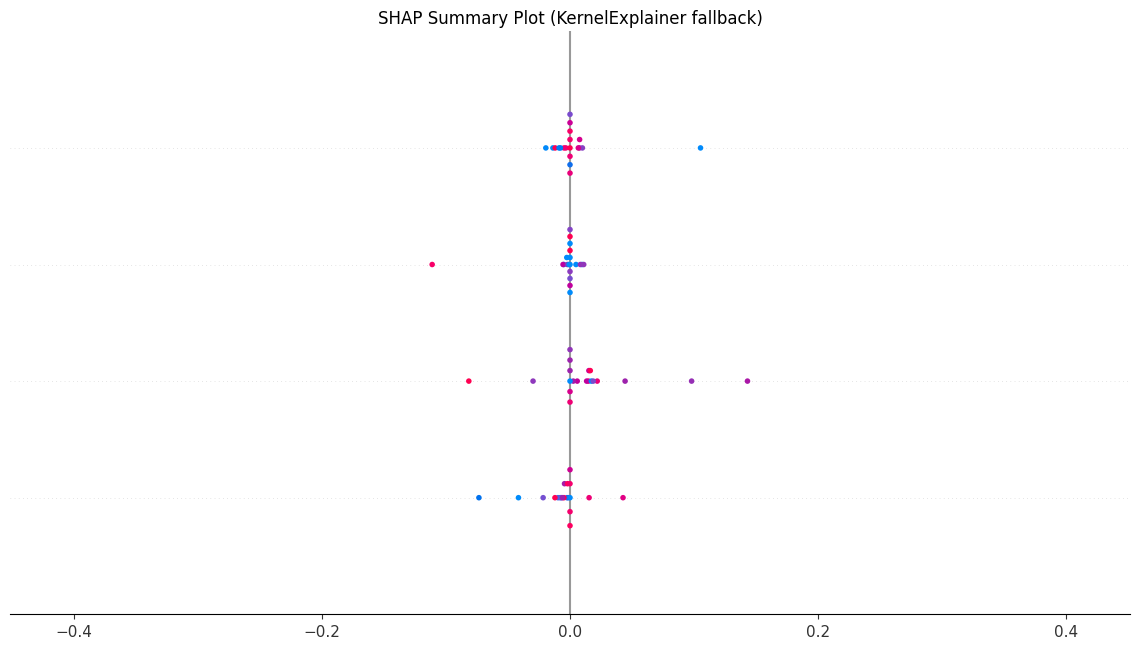


SHAP analysis completed.


In [ ]:
# =====================
# SHAP Analysis for Gradient Boosting Model
# =====================
import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.model_selection import train_test_split

# Load data
print("Loading data...")
df = pd.read_csv('employee_data_adasyn.csv')

# Convert string True/False to boolean for relevant columns
string_bool_columns = [col for col in df.columns if df[col].dtype == 'object' and
                       set(df[col].unique()).issubset({"True", "False"})]
for col in string_bool_columns:
    df[col] = df[col].map({"True": True, "False": False})

# Define features and target variable
X = df.drop('PerformanceScore_Encoded', axis=1)
y = df['PerformanceScore_Encoded'] - 1  # Convert to 0-based for XGBoost

# Get the original data split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Load the model
print("Loading gradient boosting model...")
model_path = 'gb_employee_model.pkl'
with open(model_path, 'rb') as file:
    best_model = pickle.load(file)

print("\nPerforming SHAP analysis...")

# Get the XGBoost model from the pipeline
xgb_model = best_model.named_steps['classifier']
# Get the preprocessor
preprocessor = best_model.named_steps['preprocessor']

# Create a function to transform data through the preprocessor
def transform_data(X_data):
    """Transform data through the sklearn pipeline's preprocessor"""
    return preprocessor.transform(X_data)

# Create background dataset for the explainer (using a subset of training data)
# Limit the number of background samples for efficiency
if len(X_train) > 100:
    X_background = X_train.sample(100, random_state=42)
else:
    X_background = X_train

# Process the background data through the preprocessor
X_background_processed = transform_data(X_background)

# Calculate SHAP values for a subset of the test data (for efficiency)
if len(X_test) > 100:
    X_shap = X_test.sample(100, random_state=42)
else:
    X_shap = X_test

# Process the test data subset through the preprocessor
X_shap_processed = transform_data(X_shap)

# Try different explainer approaches
try:
    print("Using TreeExplainer (optimized for tree models)...")
    # TreeExplainer is optimized for tree-based models like XGBoost
    explainer = shap.TreeExplainer(xgb_model)

    # Get SHAP values - for XGBoost multiclass, this returns a list of matrices (one per class)
    shap_values = explainer.shap_values(X_shap_processed)

    # For TreeExplainer with XGBoost, expected_value is available directly
    expected_values = explainer.expected_value

    # Number of classes
    if isinstance(shap_values, list):
        n_classes = len(shap_values)
        print(f"Number of classes detected: {n_classes}")
    else:
        n_classes = 1
        print("Binary classification detected")
        # Convert to list format for consistency
        shap_values = [shap_values]
        expected_values = [expected_values]

    # Try to get feature names after preprocessing
    try:
        # For newer scikit-learn versions
        feature_names = list(preprocessor.get_feature_names_out())
    except:
        # Fallback to generic feature names
        feature_names = [f"feature_{i}" for i in range(X_shap_processed.shape[1])]
        print("Using generic feature names for visualization")

    # Calculate average absolute SHAP values across all classes for overall importance
    overall_importance = np.zeros(X_shap_processed.shape[1])
    for i in range(n_classes):
        overall_importance += np.abs(shap_values[i]).mean(0)

    # Create feature importance DataFrame
    feature_importance = pd.DataFrame({
        'Feature': feature_names,
        'SHAP_Importance': overall_importance
    })
    feature_importance = feature_importance.sort_values('SHAP_Importance', ascending=False)

    print("\nTop 10 most important features according to SHAP:")
    print(feature_importance.head(10))

    # Map original class values back (0-based to 1-based)
    orig_classes = [(i+1) for i in range(n_classes)]

    # Create visualizations
    # 1. Summary plot for all classes
    plt.figure(figsize=(12, 8))
    shap.summary_plot(shap_values, X_shap_processed, feature_names=feature_names, show=False)
    plt.title('SHAP Summary Plot (All Classes)')
    plt.tight_layout()
    plt.savefig('gb_shap_summary.png')
    plt.show()

    # 2. Bar plot for overall feature importance
    plt.figure(figsize=(12, 8))
    sns.barplot(x='SHAP_Importance', y='Feature', data=feature_importance.head(15))
    plt.title('SHAP Feature Importance')
    plt.tight_layout()
    plt.savefig('gb_shap_importance_barplot.png')
    plt.show()

    # 3. SHAP summary bar plot (alternative visualization)
    plt.figure(figsize=(12, 8))
    shap.summary_plot(shap_values, X_shap_processed, feature_names=feature_names, plot_type="bar", show=False)
    plt.title('SHAP Feature Importance (Bar Plot)')
    plt.tight_layout()
    plt.savefig('gb_shap_importance_summary_bar.png')
    plt.show()

    # 4. Dependence plots for top 3 features
    # Choose the class with highest average predicted probability
    proba = best_model.predict_proba(X_shap)
    avg_proba = proba.mean(axis=0)
    class_for_plots = np.argmax(avg_proba)

    print(f"Using class {class_for_plots} (original {class_for_plots+1}) for dependence plots")

    # Create dependence plots for top 3 features
    for i, feature in enumerate(feature_importance.head(3)['Feature'].values):
        feature_idx = feature_names.index(feature)
        plt.figure(figsize=(10, 6))
        shap.dependence_plot(
            feature_idx,
            shap_values[class_for_plots],
            X_shap_processed,
            feature_names=feature_names,
            show=False
        )
        plt.title(f'SHAP Dependence Plot - {feature}')
        plt.tight_layout()
        plt.savefig(f'gb_shap_dependence_{i+1}.png')
        plt.show()

    # 5. Force plot for specific samples
    print("\nCreating SHAP force plots for sample predictions...")

    # Select a few samples with different predictions
    n_samples = min(5, len(X_shap))
    sample_indices = np.random.choice(len(X_shap), n_samples, replace=False)

    for i, idx in enumerate(sample_indices):
        # Get the sample
        sample = X_shap.iloc[idx:idx+1]
        sample_processed = transform_data(sample)

        # Get actual prediction
        pred_class = best_model.predict(sample)[0]
        pred_orig_class = pred_class + 1  # Convert back to original scale

        plt.figure(figsize=(14, 4))
        shap.force_plot(
            expected_values[pred_class],
            shap_values[pred_class][i if i < len(shap_values[pred_class]) else 0],
            features=sample_processed[0] if isinstance(sample_processed, np.ndarray) else sample_processed.iloc[0],
            feature_names=feature_names,
            matplotlib=True,
            show=False
        )
        plt.title(f'SHAP Force Plot for Sample {i+1} (Predicted Class: {pred_class} - Original Scale: {pred_orig_class})')
        plt.tight_layout()
        plt.savefig(f'gb_shap_force_plot_sample_{i+1}.png')
        plt.show()

        # Also print the top 5 contributors for this prediction
        feature_contribution = pd.DataFrame({
            'Feature': feature_names,
            'SHAP_Value': shap_values[pred_class][i if i < len(shap_values[pred_class]) else 0]
        })
        feature_contribution['AbsValue'] = np.abs(feature_contribution['SHAP_Value'])
        feature_contribution = feature_contribution.sort_values('AbsValue', ascending=False)

        print(f"\nTop 5 contributors for Sample {i+1} (Predicted Class: {pred_class} - Original Scale: {pred_orig_class}):")
        for _, row in feature_contribution.head(5).iterrows():
            direction = "increases" if row['SHAP_Value'] > 0 else "decreases"
            print(f"  {row['Feature']}: {row['SHAP_Value']:.4f} ({direction} prediction)")

    # 6. Decision plot (for tree-based models)
    try:
        print("\nCreating decision plots...")
        # Plot decision plot for a few samples
        plt.figure(figsize=(15, 10))

        # Get a few samples with different predictions
        different_pred_samples = []
        different_pred_indices = []

        # Try to find samples with different predictions
        unique_preds = set()
        for idx in range(min(30, len(X_shap))):
            pred = best_model.predict(X_shap.iloc[idx:idx+1])[0]
            if pred not in unique_preds and len(unique_preds) < min(5, n_classes):
                unique_preds.add(pred)
                different_pred_samples.append(transform_data(X_shap.iloc[idx:idx+1])[0])
                different_pred_indices.append(idx)

        # If we didn't find enough different predictions, just use the first few samples
        if len(different_pred_samples) < min(5, n_classes):
            different_pred_samples = [transform_data(X_shap.iloc[idx:idx+1])[0] for idx in range(min(5, len(X_shap)))]
            different_pred_indices = list(range(min(5, len(X_shap))))

        sample_names = [f"Sample {idx+1}" for idx in range(len(different_pred_samples))]

        # Create decision plot
        shap.decision_plot(
            expected_values[class_for_plots],
            shap_values[class_for_plots][different_pred_indices],
            feature_names=feature_names,
            highlight=0,  # Highlight first sample
            show=False
        )
        plt.title(f'SHAP Decision Plot - Class {class_for_plots} (Original {class_for_plots+1})')
        plt.tight_layout()
        plt.savefig('gb_shap_decision_plot.png')
        plt.show()
    except Exception as e:
        print(f"Error creating decision plot: {e}")

    # 7. Create class-specific summary plots
    print("\nCreating class-specific summary plots...")
    for class_idx in range(n_classes):
        try:
            plt.figure(figsize=(12, 8))
            shap.summary_plot(
                shap_values[class_idx],
                X_shap_processed,
                feature_names=feature_names,
                show=False
            )
            plt.title(f'SHAP Summary Plot - Class {class_idx} (Original {class_idx+1})')
            plt.tight_layout()
            plt.savefig(f'gb_shap_summary_class_{class_idx}.png')
            plt.show()
        except Exception as e:
            print(f"Error creating summary plot for class {class_idx}: {e}")

except Exception as e:
    print(f"Error in TreeExplainer approach: {e}")

    try:
        print("\nFalling back to KernelExplainer approach...")

        # Create a wrapper function for the model
        def model_predict_proba_wrapper(x):
            """Wrapper function that processes x through the entire pipeline"""
            # x is a numpy array in the preprocessed feature space
            # We need to transform it through preprocessor if it hasn't been
            # We assume x is already transformed in this implementation
            return xgb_model.predict_proba(x)

        # Create a KernelExplainer with the wrapper
        explainer = shap.KernelExplainer(model_predict_proba_wrapper, X_background_processed)

        # Calculate SHAP values for a smaller subset
        small_sample = X_shap_processed[:min(20, len(X_shap_processed))]
        shap_values = explainer.shap_values(small_sample)

        # Create summary plot
        plt.figure(figsize=(12, 8))
        shap.summary_plot(
            shap_values,
            small_sample,
            feature_names=[f"feature_{i}" for i in range(small_sample.shape[1])],
            show=False
        )
        plt.title('SHAP Summary Plot (KernelExplainer fallback)')
        plt.tight_layout()
        plt.savefig('gb_shap_summary_kernel.png')
        plt.show()

    except Exception as e2:
        print(f"Error in KernelExplainer approach: {e2}")

        print("\nUsing built-in XGBoost feature importance as final fallback...")

        # Use built-in feature importance from XGBoost
        importances = xgb_model.feature_importances_

        # Create DataFrame for feature importance
        try:
            # Try to get feature names
            try:
                feature_names = list(preprocessor.get_feature_names_out())
            except:
                feature_names = [f"feature_{i}" for i in range(len(importances))]

            feature_imp_df = pd.DataFrame({
                'Feature': feature_names,
                'Importance': importances
            }).sort_values('Importance', ascending=False)

            # Plot feature importance
            plt.figure(figsize=(12, 8))
            sns.barplot(x='Importance', y='Feature', data=feature_imp_df.head(15))
            plt.title('XGBoost Feature Importance')
            plt.tight_layout()
            plt.savefig('gb_native_importance.png')
            plt.show()

            print("\nTop 10 features by XGBoost importance:")
            print(feature_imp_df.head(10))

        except Exception as e3:
            print(f"Error extracting XGBoost feature importance: {e3}")

print("\nSHAP analysis completed.")

Loading data and model...

Performing comprehensive SHAP analysis for all classes...
Using TreeExplainer (optimized for tree models)...
Binary classification detected
Class labels (original scale): [1]

=== Overall Feature Importance (All Classes) ===
Error in TreeExplainer analysis: operands could not be broadcast together with shapes (15,) (15,4) (15,) 

Falling back to XGBoost's built-in feature importance...


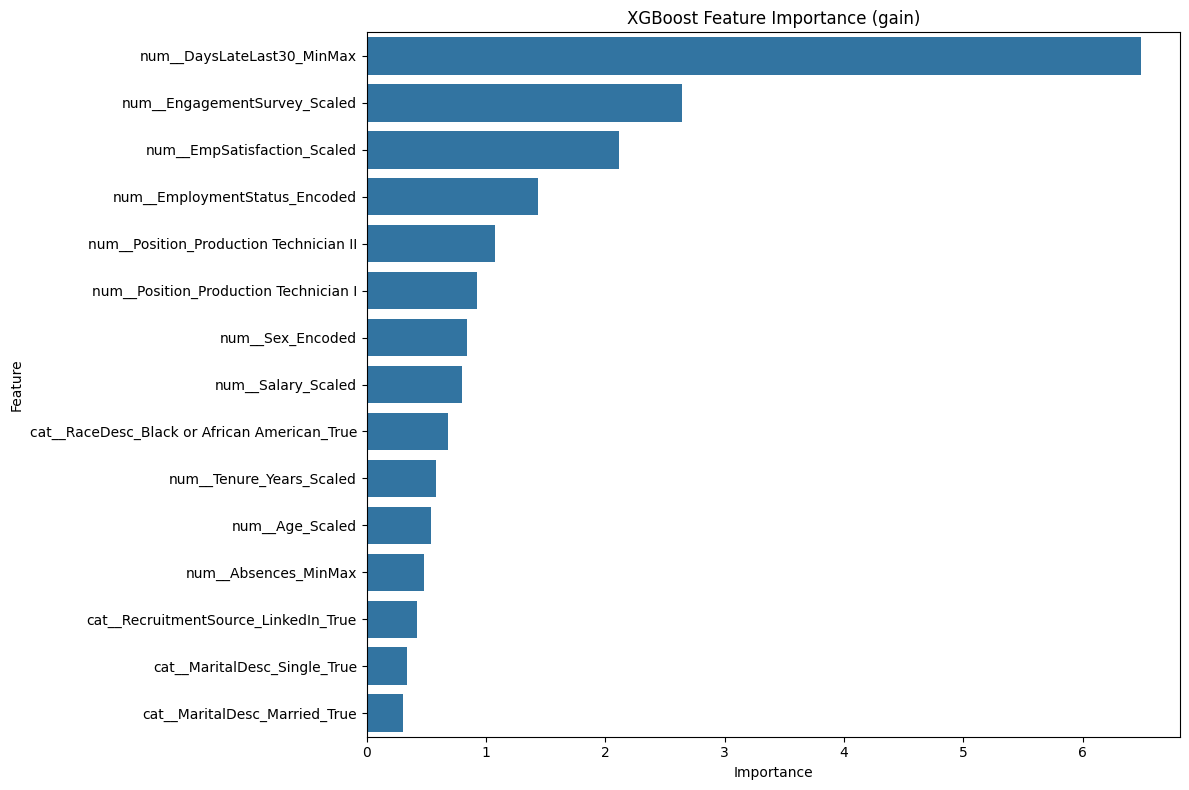

Top 10 features by XGBoost gain importance:
                                         Feature  Importance
0                     num__DaysLateLast30_MinMax    6.489534
1                   num__EngagementSurvey_Scaled    2.642005
5                    num__EmpSatisfaction_Scaled    2.117221
7                  num__EmploymentStatus_Encoded    1.439445
10        num__Position_Production Technician II    1.076525
9          num__Position_Production Technician I    0.925630
8                               num__Sex_Encoded    0.840493
4                             num__Salary_Scaled    0.797186
12  cat__RaceDesc_Black or African American_True    0.677818
2                       num__Tenure_Years_Scaled    0.580053


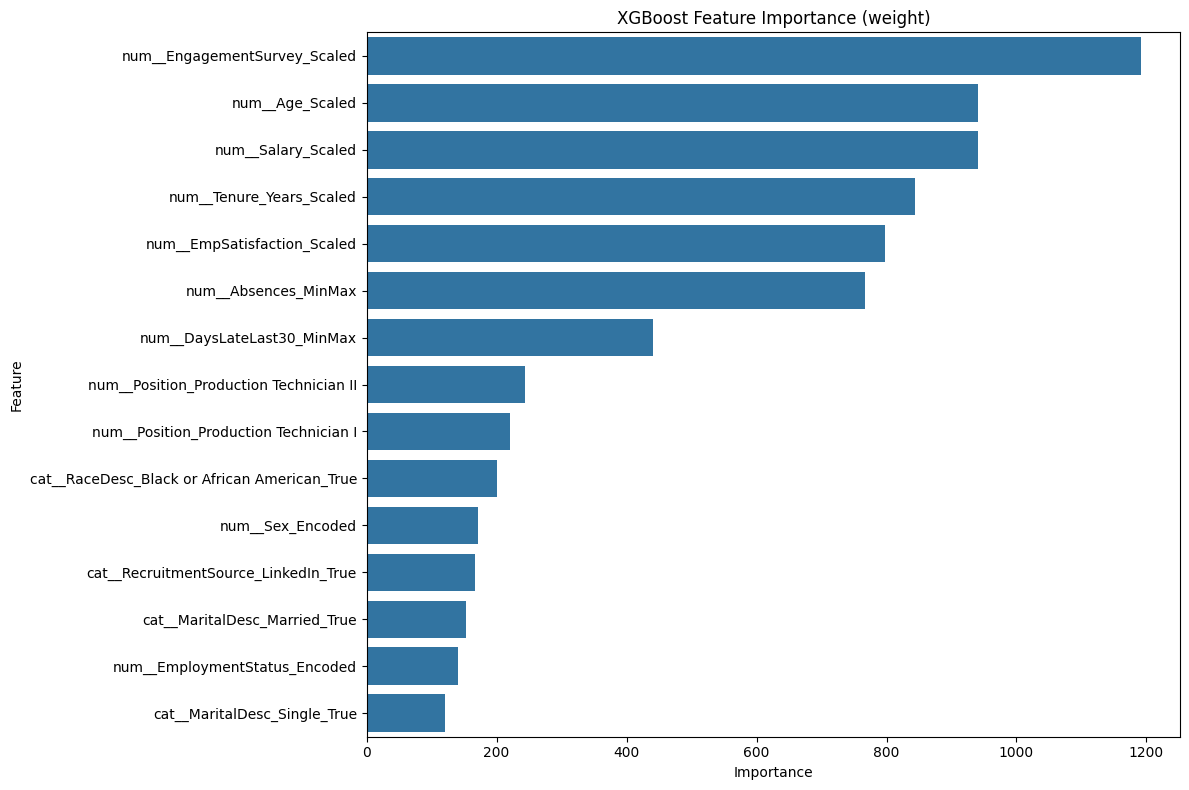


Top 10 features by XGBoost weight importance:
                                         Feature  Importance
1                   num__EngagementSurvey_Scaled      1192.0
6                                num__Age_Scaled       940.0
4                             num__Salary_Scaled       940.0
2                       num__Tenure_Years_Scaled       844.0
5                    num__EmpSatisfaction_Scaled       798.0
3                           num__Absences_MinMax       767.0
0                     num__DaysLateLast30_MinMax       441.0
10        num__Position_Production Technician II       243.0
9          num__Position_Production Technician I       221.0
12  cat__RaceDesc_Black or African American_True       200.0


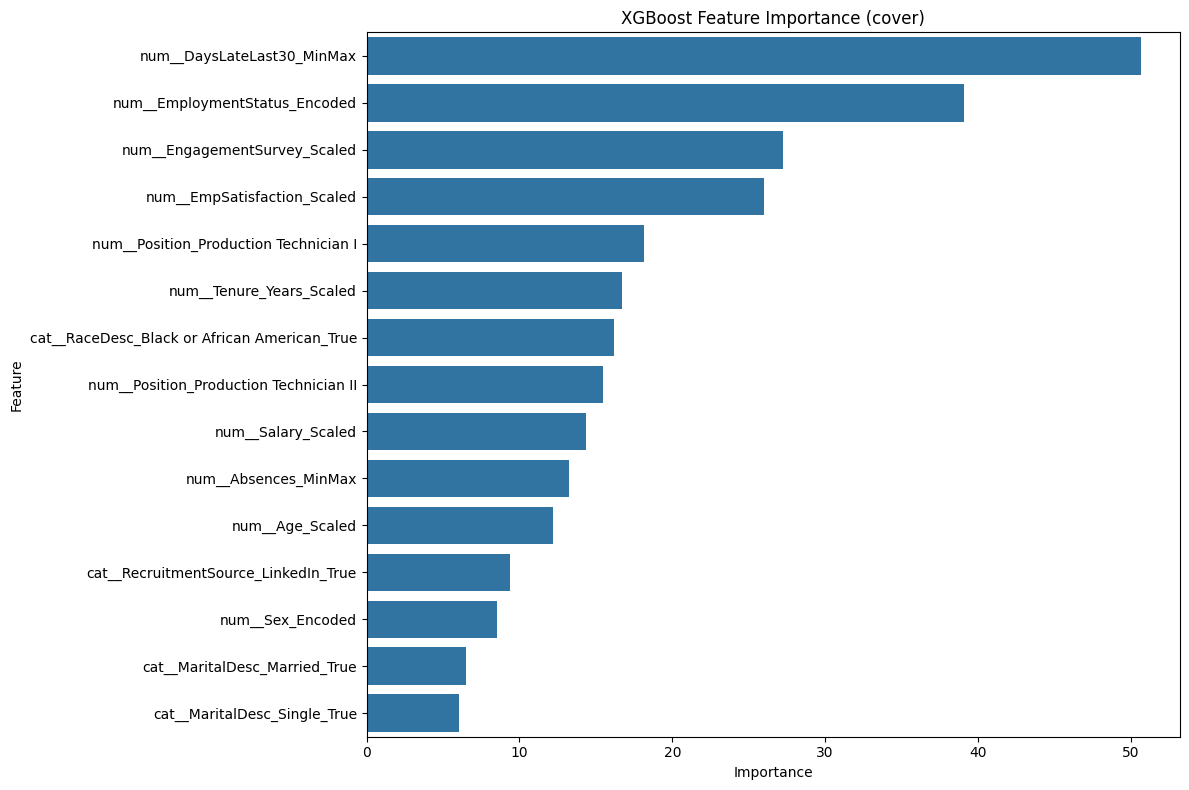


Top 10 features by XGBoost cover importance:
                                         Feature  Importance
0                     num__DaysLateLast30_MinMax   50.689018
7                  num__EmploymentStatus_Encoded   39.107933
1                   num__EngagementSurvey_Scaled   27.222359
5                    num__EmpSatisfaction_Scaled   25.994864
9          num__Position_Production Technician I   18.133400
2                       num__Tenure_Years_Scaled   16.721281
12  cat__RaceDesc_Black or African American_True   16.213758
10        num__Position_Production Technician II   15.485714
4                             num__Salary_Scaled   14.359529
3                           num__Absences_MinMax   13.226056


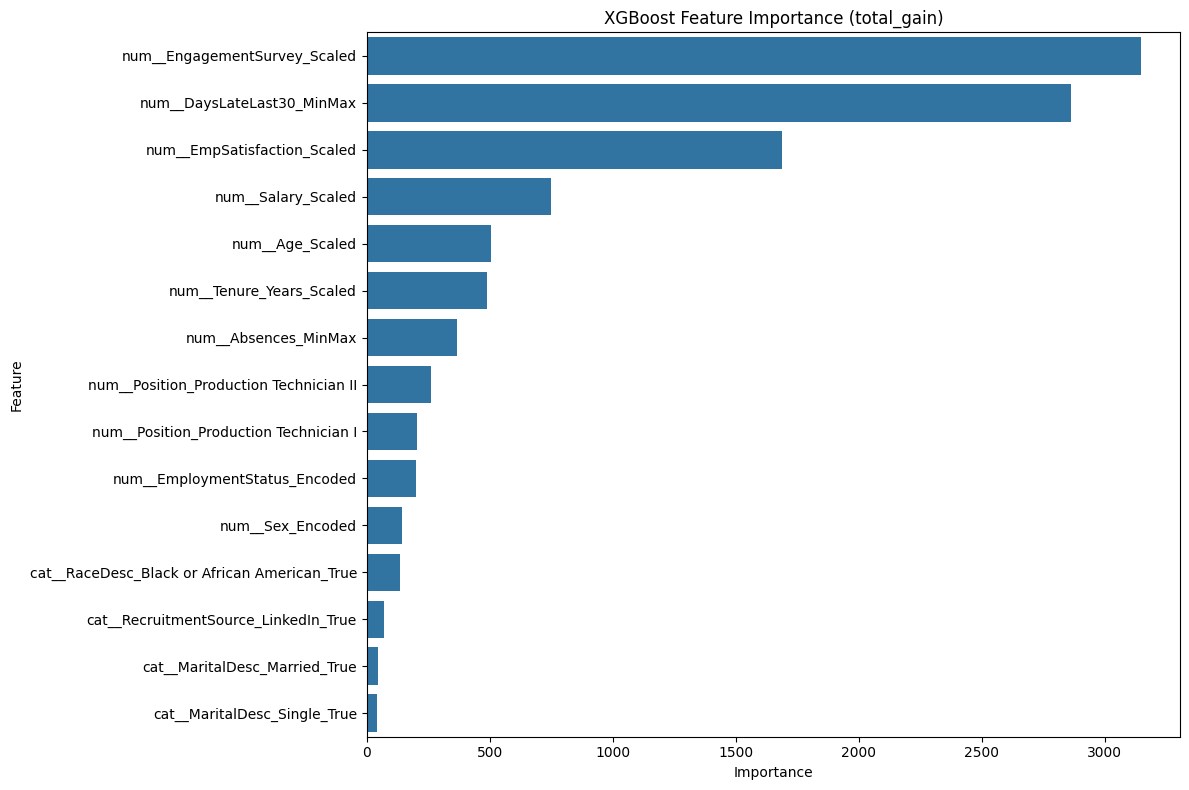


Top 10 features by XGBoost total_gain importance:
                                   Feature   Importance
1             num__EngagementSurvey_Scaled  3149.270508
0               num__DaysLateLast30_MinMax  2861.884521
5              num__EmpSatisfaction_Scaled  1689.542358
4                       num__Salary_Scaled   749.354614
6                          num__Age_Scaled   505.763275
2                 num__Tenure_Years_Scaled   489.564575
3                     num__Absences_MinMax   366.290527
10  num__Position_Production Technician II   261.595673
9    num__Position_Production Technician I   204.564224
7            num__EmploymentStatus_Encoded   201.522293


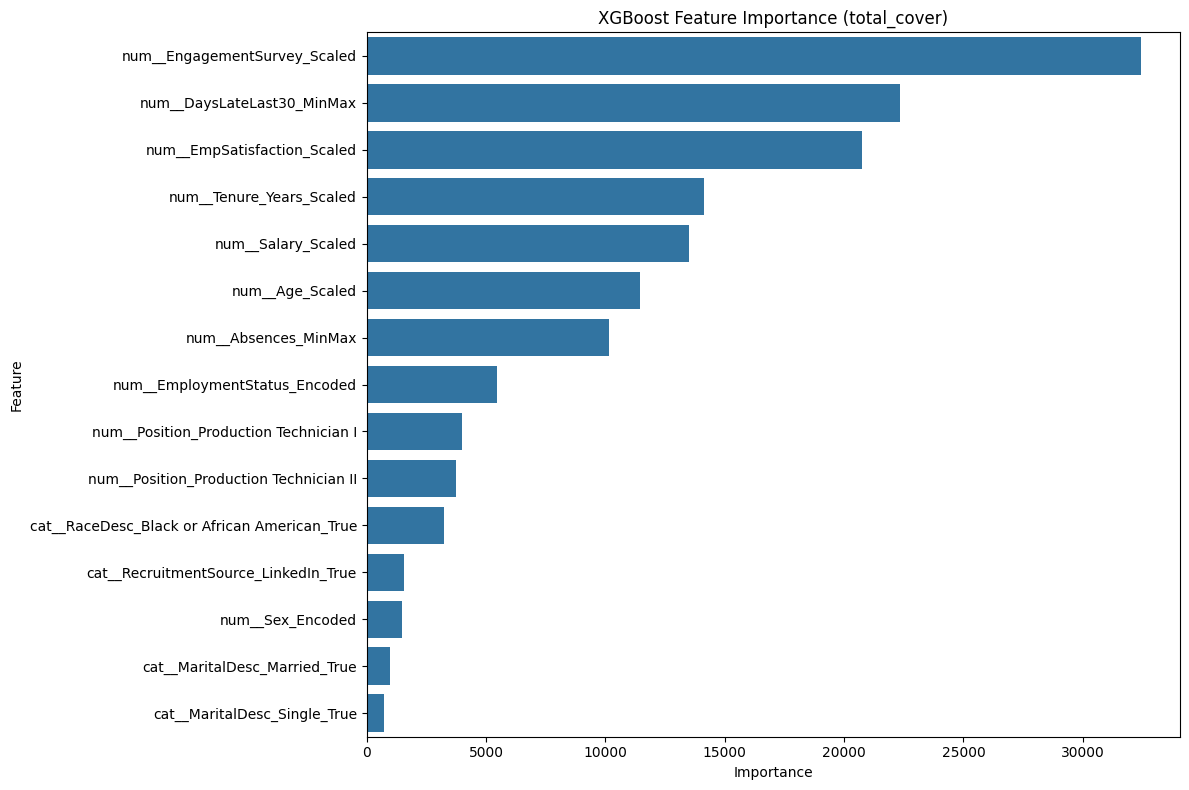


Top 10 features by XGBoost total_cover importance:
                                   Feature    Importance
1             num__EngagementSurvey_Scaled  32449.050781
0               num__DaysLateLast30_MinMax  22353.857422
5              num__EmpSatisfaction_Scaled  20743.900391
2                 num__Tenure_Years_Scaled  14112.761719
4                       num__Salary_Scaled  13497.958008
6                          num__Age_Scaled  11465.842773
3                     num__Absences_MinMax  10144.384766
7            num__EmploymentStatus_Encoded   5475.110840
9    num__Position_Production Technician I   4007.481201
10  num__Position_Production Technician II   3763.028564

Comprehensive SHAP analysis completed.


In [ ]:
# =====================
# Comprehensive SHAP Analysis for Gradient Boosting (All Classes)
# =====================
import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
import pickle
from sklearn.model_selection import train_test_split

print("Loading data and model...")

# Load data
df = pd.read_csv('employee_data_adasyn.csv')

# Convert string True/False to boolean for relevant columns
string_bool_columns = [col for col in df.columns if df[col].dtype == 'object' and
                       set(df[col].unique()).issubset({"True", "False"})]
for col in string_bool_columns:
    df[col] = df[col].map({"True": True, "False": False})

# Define features and target variable
X = df.drop('PerformanceScore_Encoded', axis=1)
y = df['PerformanceScore_Encoded'] - 1  # Convert to 0-based for XGBoost

# Get the original data split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Load the model
model_path = 'gb_employee_model.pkl'
with open(model_path, 'rb') as file:
    best_model = pickle.load(file)

# Get the XGBoost model from the pipeline
xgb_model = best_model.named_steps['classifier']

# Get the preprocessor
preprocessor = best_model.named_steps['preprocessor']

print("\nPerforming comprehensive SHAP analysis for all classes...")

# Function to transform data through the preprocessor
def transform_data(X_data):
    """Transform data through the sklearn pipeline's preprocessor"""
    return preprocessor.transform(X_data)

# Create a background dataset for the explainer (using a subset of training data)
# Limit the number of background samples for efficiency
if len(X_train) > 100:
    X_background = X_train.sample(100, random_state=42)
else:
    X_background = X_train

# Process the background data through the preprocessor
X_background_processed = transform_data(X_background)

# Calculate SHAP values for a subset of the test data (for efficiency)
if len(X_test) > 50:
    X_shap = X_test.sample(50, random_state=42)
else:
    X_shap = X_test

# Process the test data subset through the preprocessor
X_shap_processed = transform_data(X_shap)

# Try tree-based explainer approach
try:
    print("Using TreeExplainer (optimized for tree models)...")
    explainer = shap.TreeExplainer(xgb_model)

    # Get SHAP values - for XGBoost multiclass, this returns a list of matrices (one per class)
    shap_values = explainer.shap_values(X_shap_processed)

    # For TreeExplainer with XGBoost, expected_value is available directly
    expected_values = explainer.expected_value

    # Number of classes
    if isinstance(shap_values, list):
        n_classes = len(shap_values)
        print(f"Number of classes detected: {n_classes}")
    else:
        n_classes = 1
        print("Binary classification detected")
        # Convert to list format for consistency
        shap_values = [shap_values]
        expected_values = [expected_values]

    # Try to get feature names after preprocessing
    try:
        # For newer scikit-learn versions
        feature_names = list(preprocessor.get_feature_names_out())
    except:
        # Fallback to generic feature names
        feature_names = [f"feature_{i}" for i in range(X_shap_processed.shape[1])]
        print("Using generic feature names for visualization")

    # Get class labels - convert from 0-based back to original 1-based
    class_labels = [i+1 for i in range(n_classes)]
    print(f"Class labels (original scale): {class_labels}")

    # 1. GLOBAL FEATURE IMPORTANCE ACROSS ALL CLASSES
    # Calculate overall importance for all features
    print("\n=== Overall Feature Importance (All Classes) ===")
    overall_importance = np.zeros(X_shap_processed.shape[1])
    for i in range(n_classes):
        overall_importance += np.abs(shap_values[i]).mean(0)

    # Create feature importance DataFrame
    feature_importance = pd.DataFrame({
        'Feature': feature_names,
        'SHAP_Importance': overall_importance
    })
    feature_importance = feature_importance.sort_values('SHAP_Importance', ascending=False)

    print("Top 10 most important features (all classes combined):")
    print(feature_importance.head(10))

    # Create bar plot for overall feature importance
    plt.figure(figsize=(12, 8))
    sns.barplot(x='SHAP_Importance', y='Feature', data=feature_importance.head(15))
    plt.title('Overall SHAP Feature Importance (All Classes Combined)')
    plt.tight_layout()
    plt.savefig('gb_shap_importance_overall.png')
    plt.show()

    # 2. PER-CLASS FEATURE IMPORTANCE
    print("\n=== Per-Class Feature Importance ===")
    # Calculate and visualize feature importance for each class
    for i in range(n_classes):
        # Calculate mean absolute SHAP values for this class
        class_importance = np.abs(shap_values[i]).mean(0)

        # Create and sort DataFrame
        class_importance_df = pd.DataFrame({
            'Feature': feature_names,
            'SHAP_Importance': class_importance
        })
        class_importance_df = class_importance_df.sort_values('SHAP_Importance', ascending=False)

        print(f"\nTop 10 most important features for Class {i} (Original {class_labels[i]}):")
        print(class_importance_df.head(10))

        # Bar plot for this class
        plt.figure(figsize=(12, 8))
        sns.barplot(x='SHAP_Importance', y='Feature', data=class_importance_df.head(15))
        plt.title(f'SHAP Feature Importance for Class {i} (Original {class_labels[i]})')
        plt.tight_layout()
        plt.savefig(f'gb_shap_importance_class_{i}.png')
        plt.show()

    # 3. SUMMARY PLOTS FOR ALL CLASSES
    print("\n=== SHAP Summary Plots ===")
    # Create summary plots for all classes
    plt.figure(figsize=(12, 8))
    shap.summary_plot(shap_values, X_shap_processed, feature_names=feature_names, show=False)
    plt.title('SHAP Summary Plot (All Classes)')
    plt.tight_layout()
    plt.savefig('gb_shap_summary_all_classes.png')
    plt.show()

    # Create separate summary plots for each class
    for i in range(n_classes):
        plt.figure(figsize=(12, 8))
        shap.summary_plot(shap_values[i], X_shap_processed, feature_names=feature_names, show=False)
        plt.title(f'SHAP Summary Plot for Class {i} (Original {class_labels[i]})')
        plt.tight_layout()
        plt.savefig(f'gb_shap_summary_class_{i}.png')
        plt.show()

    # 4. DEPENDENCE PLOTS FOR TOP FEATURES PER CLASS
    print("\n=== SHAP Dependence Plots ===")
    # For each class, create dependence plots for the top 3 features
    for i in range(n_classes):
        # Get top features for this class
        class_importance = np.abs(shap_values[i]).mean(0)
        top_features_idx = np.argsort(-class_importance)[:3]  # Top 3 features
        top_features = [feature_names[idx] for idx in top_features_idx]

        print(f"\nCreating dependence plots for Class {i} (Original {class_labels[i]})'s top features: {top_features}")

        # Create dependence plots for each top feature
        for j, feature_idx in enumerate(top_features_idx):
            feature_name = feature_names[feature_idx]
            plt.figure(figsize=(10, 6))
            shap.dependence_plot(
                feature_idx,
                shap_values[i],
                X_shap_processed,
                feature_names=feature_names,
                show=False
            )
            plt.title(f'SHAP Dependence Plot - {feature_name} for Class {i} (Original {class_labels[i]})')
            plt.tight_layout()
            plt.savefig(f'gb_shap_dependence_class_{i}_{j+1}.png')
            plt.show()

    # 5. FORCE PLOTS FOR REPRESENTATIVE SAMPLES OF EACH CLASS
    print("\n=== SHAP Force Plots for Representative Samples ===")

    # Get predictions for the examples in X_shap
    y_pred = best_model.predict(X_shap)

    # For each class, find examples that are predicted as that class
    for i in range(n_classes):
        # Find indices of examples predicted as this class
        class_indices = np.where(y_pred == i)[0]

        if len(class_indices) > 0:
            # Take up to 2 examples from this class
            sample_count = min(2, len(class_indices))

            for j in range(sample_count):
                idx = class_indices[j]

                # Get the sample preprocessed
                sample_processed = X_shap_processed[idx]

                # Create force plot
                plt.figure(figsize=(14, 4))
                shap.force_plot(
                    expected_values[i],
                    shap_values[i][idx],
                    features=sample_processed,
                    feature_names=feature_names,
                    matplotlib=True,
                    show=False
                )
                plt.title(f'SHAP Force Plot for Class {i} (Original {class_labels[i]}) - Sample {j+1}')
                plt.tight_layout()
                plt.savefig(f'gb_shap_force_plot_class_{i}_sample_{j+1}.png')
                plt.show()

                # Print top contributors for this example
                feature_contribution = pd.DataFrame({
                    'Feature': feature_names,
                    'SHAP_Value': shap_values[i][idx]
                })
                feature_contribution['AbsValue'] = np.abs(feature_contribution['SHAP_Value'])
                feature_contribution = feature_contribution.sort_values('AbsValue', ascending=False)

                print(f"Top 5 contributors for Class {i} (Original {class_labels[i]}) - Sample {j+1}:")
                for _, row in feature_contribution.head(5).iterrows():
                    direction = "increases" if row['SHAP_Value'] > 0 else "decreases"
                    print(f"  {row['Feature']}: {row['SHAP_Value']:.4f} ({direction} probability)")
        else:
            print(f"No samples predicted as Class {i} (Original {class_labels[i]}) in the subset.")

    # 6. CLASS SEPARATION ANALYSIS
    print("\n=== Class Separation Analysis ===")

    # Create a DataFrame to analyze how each feature separates classes
    if n_classes > 1:  # Only meaningful for multi-class
        # Calculate mean SHAP value (not absolute) for each class and feature
        class_means = []
        for i in range(n_classes):
            mean_values = shap_values[i].mean(0)
            class_means.append(mean_values)

        # Find features with the most divergent SHAP values across classes
        class_means = np.array(class_means)
        feature_divergence = np.var(class_means, axis=0)

        # Create DataFrame for divergence
        divergence_df = pd.DataFrame({
            'Feature': feature_names,
            'Class_Divergence': feature_divergence
        }).sort_values('Class_Divergence', ascending=False)

        print("Features that best separate classes (highest variance in SHAP values):")
        print(divergence_df.head(10))

        # Bar plot for class divergence
        plt.figure(figsize=(12, 8))
        sns.barplot(x='Class_Divergence', y='Feature', data=divergence_df.head(15))
        plt.title('Features that Best Separate Classes')
        plt.tight_layout()
        plt.savefig('gb_shap_class_separation.png')
        plt.show()

        # For the top 3 class-separating features, show class comparison
        for f_idx, feature in enumerate(divergence_df.head(3)['Feature'].values):
            feature_idx = feature_names.index(feature)

            # Create a DataFrame of mean SHAP values for this feature across classes
            feature_class_df = pd.DataFrame({
                'Class': [f'Class {i} (Orig. {class_labels[i]})' for i in range(n_classes)],
                'Mean_SHAP': [class_means[i][feature_idx] for i in range(n_classes)]
            })

            # Plot class comparison
            plt.figure(figsize=(10, 6))
            sns.barplot(x='Class', y='Mean_SHAP', data=feature_class_df)
            plt.title(f'Mean SHAP Values for {feature} Across Classes')
            plt.axhline(y=0, color='r', linestyle='--')
            plt.tight_layout()
            plt.savefig(f'gb_shap_class_comparison_{f_idx+1}.png')
            plt.show()

    # 7. DECISION PLOTS
    try:
        print("\n=== Decision Plots for Class Comparison ===")

        # For each class, select a clear example
        for i in range(n_classes):
            # Find indices of examples predicted as this class with high probability
            y_proba = best_model.predict_proba(X_shap)
            class_indices = np.where((y_pred == i) & (y_proba[:, i] > 0.7))[0]

            if len(class_indices) > 0:
                # Take the example with highest probability
                idx = class_indices[np.argmax(y_proba[class_indices, i])]

                # Create a decision plot
                try:
                    plt.figure(figsize=(12, 8))
                    shap.decision_plot(
                        expected_values[i],
                        shap_values[i][idx],
                        feature_names=feature_names,
                        show=False
                    )
                    plt.title(f'SHAP Decision Plot for Class {i} (Original {class_labels[i]})')
                    plt.tight_layout()
                    plt.savefig(f'gb_shap_decision_plot_class_{i}.png')
                    plt.show()
                except Exception as e:
                    print(f"  Decision plot not supported or failed: {e}")
                    break  # Skip for other classes too
    except Exception as e:
        print(f"Decision plots functionality failed: {e}")

    # 8. FEATURE INTERACTION ANALYSIS
    # For tree-based models, we can use TreeExplainer's tree_shap interaction calculation
    try:
        print("\n=== Advanced Feature Interaction Analysis for Tree Models ===")

        # This is a modified approach specifically for tree-based models
        # Get feature importances from the XGBoost model
        feature_importances = xgb_model.feature_importances_

        # Create a DataFrame for interaction analysis
        importance_df = pd.DataFrame({
            'Feature': feature_names,
            'Importance': feature_importances
        }).sort_values('Importance', ascending=False)

        print("Top 10 most important features according to model's feature importance:")
        print(importance_df.head(10))

        # For the top feature, analyze its split conditions in the trees
        top_feature = importance_df.iloc[0]['Feature']
        top_feature_idx = feature_names.index(top_feature)

        print(f"\nAnalyzing interactions for top feature: {top_feature}")

        # Try to calculate SHAP interaction values for a small sample
        # This is computationally intensive, so we use a very small sample
        try:
            small_sample = X_shap_processed[:min(10, len(X_shap_processed))]

            # Use SHAP's interaction values if available
            interaction_values = explainer.shap_interaction_values(small_sample)

            # For each class, analyze interactions with the top feature
            for i in range(n_classes):
                # Get average absolute interaction values for the top feature
                if isinstance(interaction_values, list):
                    feature_interactions = np.abs(interaction_values[i][:, top_feature_idx, :]).mean(0)
                else:
                    feature_interactions = np.abs(interaction_values[:, top_feature_idx, :]).mean(0)

                # Create DataFrame
                feature_interaction_df = pd.DataFrame({
                    'Feature': feature_names,
                    'Interaction_Strength': feature_interactions
                }).sort_values('Interaction_Strength', ascending=False)

                # Remove self-interaction
                feature_interaction_df = feature_interaction_df[feature_interaction_df['Feature'] != top_feature]

                # Plot
                plt.figure(figsize=(12, 8))
                sns.barplot(x='Interaction_Strength', y='Feature', data=feature_interaction_df.head(10))
                plt.title(f'Top Feature Interactions with {top_feature} for Class {i} (Original {class_labels[i]})')
                plt.tight_layout()
                plt.savefig(f'gb_shap_interaction_class_{i}.png')
                plt.show()

                print(f"Top 5 features that interact with {top_feature} for Class {i} (Original {class_labels[i]}):")
                print(feature_interaction_df.head(5))
        except Exception as e:
            print(f"Detailed interaction analysis not available: {e}")
            print("Falling back to simpler interaction visualization...")

            # Fallback to standard dependence plots with hue for interactions
            for i in range(n_classes):
                # Get top 5 features for this class
                class_importance = np.abs(shap_values[i]).mean(0)
                top_features_idx = np.argsort(-class_importance)[:5]

                # For the top feature, create dependence plots with interaction color
                top_feature_idx = top_features_idx[0]
                top_feature = feature_names[top_feature_idx]

                # Try different features as interaction colors
                for j in range(1, min(4, len(top_features_idx))):
                    interaction_feature_idx = top_features_idx[j]
                    interaction_feature = feature_names[interaction_feature_idx]

                    plt.figure(figsize=(10, 6))
                    shap.dependence_plot(
                        top_feature_idx,
                        shap_values[i],
                        X_shap_processed,
                        feature_names=feature_names,
                        interaction_index=interaction_feature_idx,
                        show=False
                    )
                    plt.title(f'{top_feature} vs {interaction_feature} Interaction - Class {i} (Original {class_labels[i]})')
                    plt.tight_layout()
                    plt.savefig(f'gb_shap_interaction_plot_{i}_{j}.png')
                    plt.show()

    except Exception as e:
        print(f"Feature interaction analysis failed: {e}")

    # 9. WATERFALL PLOTS FOR DETAILED PREDICTION EXPLANATION
    # These are particularly helpful for tree-based models
    try:
        print("\n=== Waterfall Plots (Detailed Prediction Breakdown) ===")

        # For each class, create a waterfall plot for a representative example
        for i in range(n_classes):
            # Find indices of examples predicted as this class
            class_indices = np.where(y_pred == i)[0]

            if len(class_indices) > 0:
                # Take the first example
                idx = class_indices[0]

                plt.figure(figsize=(12, 8))
                shap.plots._waterfall.waterfall_legacy(
                    expected_values[i],
                    shap_values[i][idx],
                    feature_names=feature_names,
                    show=False
                )
                plt.title(f'SHAP Waterfall Plot for Class {i} (Original {class_labels[i]})')
                plt.tight_layout()
                plt.savefig(f'gb_shap_waterfall_class_{i}.png')
                plt.show()
            else:
                print(f"No samples predicted as Class {i} (Original {class_labels[i]}) in the subset.")

    except Exception as e:
        print(f"Waterfall plots not available: {e}")

    # 10. FEATURE CLUSTERING
    # Group related features by their impact patterns
    try:
        print("\n=== Feature Clustering by Impact Patterns ===")

        # Combine SHAP values from all classes
        all_shap_values = np.vstack([shap_values[i] for i in range(n_classes)])

        # Calculate correlation matrix between features based on their SHAP values
        shap_correlations = np.corrcoef(all_shap_values.T)

        # Create a heatmap
        plt.figure(figsize=(14, 12))
        sns.heatmap(
            shap_correlations,
            cmap='coolwarm',
            center=0,
            xticklabels=feature_names,
            yticklabels=feature_names
        )
        plt.title('SHAP Value Correlation Between Features')
        plt.tight_layout()
        plt.savefig('gb_shap_feature_correlation.png')
        plt.show()

        # Focus on top 15 most important features
        top_features = feature_importance.head(15)['Feature'].values
        top_indices = [feature_names.index(f) for f in top_features]

        # Subset correlation matrix
        top_correlations = shap_correlations[np.ix_(top_indices, top_indices)]

        # Create a heatmap for top features
        plt.figure(figsize=(12, 10))
        sns.heatmap(
            top_correlations,
            cmap='coolwarm',
            center=0,
            xticklabels=top_features,
            yticklabels=top_features,
            annot=True,
            fmt=".2f"
        )
        plt.title('SHAP Correlation Between Top 15 Features')
        plt.tight_layout()
        plt.savefig('gb_shap_top_feature_correlation.png')
        plt.show()

    except Exception as e:
        print(f"Feature clustering analysis failed: {e}")

except Exception as e:
    print(f"Error in TreeExplainer analysis: {e}")

    # Fallback to simpler analysis using XGBoost's built-in feature importance
    try:
        print("\nFalling back to XGBoost's built-in feature importance...")

        # Get feature importance from the model
        importance_type = 'gain'  # 'weight', 'gain', 'cover', 'total_gain', 'total_cover'
        importances = xgb_model.get_booster().get_score(importance_type=importance_type)

        # Match feature names
        try:
            feature_names = list(preprocessor.get_feature_names_out())
        except:
            feature_names = [f"f{i}" for i in range(X_shap_processed.shape[1])]

        # Convert to DataFrame
        importance_df = pd.DataFrame({
            'Feature': [feature_names[int(f.replace('f', ''))] if f.startswith('f') else f for f in importances.keys()],
            'Importance': list(importances.values())
        }).sort_values('Importance', ascending=False)

        # Plot
        plt.figure(figsize=(12, 8))
        sns.barplot(x='Importance', y='Feature', data=importance_df.head(15))
        plt.title(f'XGBoost Feature Importance ({importance_type})')
        plt.tight_layout()
        plt.savefig(f'gb_xgboost_importance_{importance_type}.png')
        plt.show()

        print(f"Top 10 features by XGBoost {importance_type} importance:")
        print(importance_df.head(10))

        # Try different importance types
        for imp_type in ['weight', 'cover', 'total_gain', 'total_cover']:
            try:
                imp = xgb_model.get_booster().get_score(importance_type=imp_type)
                imp_df = pd.DataFrame({
                    'Feature': [feature_names[int(f.replace('f', ''))] if f.startswith('f') else f for f in imp.keys()],
                    'Importance': list(imp.values())
                }).sort_values('Importance', ascending=False)

                plt.figure(figsize=(12, 8))
                sns.barplot(x='Importance', y='Feature', data=imp_df.head(15))
                plt.title(f'XGBoost Feature Importance ({imp_type})')
                plt.tight_layout()
                plt.savefig(f'gb_xgboost_importance_{imp_type}.png')
                plt.show()

                print(f"\nTop 10 features by XGBoost {imp_type} importance:")
                print(imp_df.head(10))
            except Exception as e:
                print(f"Could not calculate {imp_type} importance: {e}")

    except Exception as e:
        print(f"Fallback analysis failed: {e}")

print("\nComprehensive SHAP analysis completed.")

Loading data and model...
Class distribution in original data:
  Performance Score 1: 241 employees (25.1%)
  Performance Score 2: 240 employees (25.0%)
  Performance Score 3: 243 employees (25.3%)
  Performance Score 4: 235 employees (24.5%)

Performing Four Performance Classes (1-4) SHAP Analysis...
Using TreeExplainer (optimized for tree models)...
Number of classes detected: 100
Performance Score Classes: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100]

=== Global Feature Importance (All Performance Scores) ===
Error in TreeExplainer analysis: operands could not be broadcast together with shapes (15,) (4,) (15,) 

Falling back to XGBoost's bui

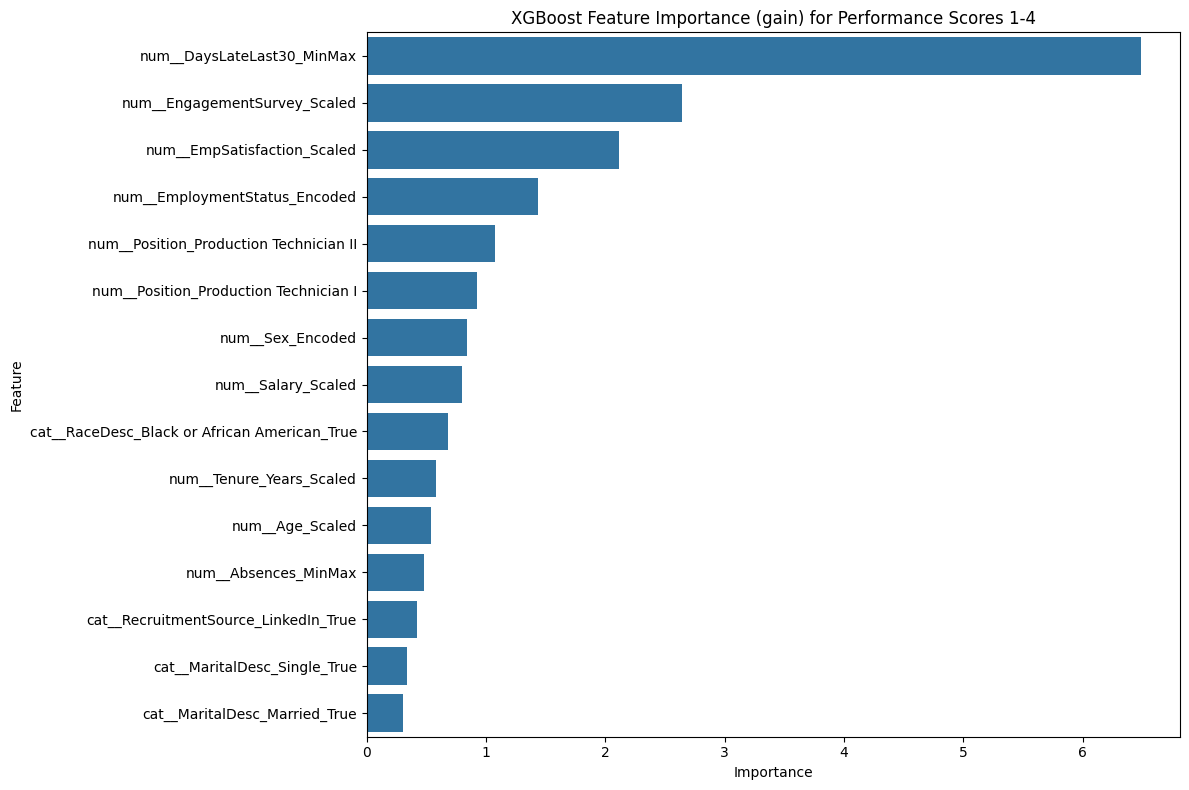

Top 10 features by XGBoost gain importance:
                                         Feature  Importance
0                     num__DaysLateLast30_MinMax    6.489534
1                   num__EngagementSurvey_Scaled    2.642005
5                    num__EmpSatisfaction_Scaled    2.117221
7                  num__EmploymentStatus_Encoded    1.439445
10        num__Position_Production Technician II    1.076525
9          num__Position_Production Technician I    0.925630
8                               num__Sex_Encoded    0.840493
4                             num__Salary_Scaled    0.797186
12  cat__RaceDesc_Black or African American_True    0.677818
2                       num__Tenure_Years_Scaled    0.580053

Four Performance Classes (1-4) SHAP analysis completed.


In [ ]:
# =====================
# Four Performance Classes (1-4) SHAP Comparison Analysis
# =====================
import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
import pickle
from sklearn.model_selection import train_test_split
from matplotlib.gridspec import GridSpec
import matplotlib.patches as mpatches

print("Loading data and model...")

# Load data
df = pd.read_csv('employee_data_adasyn.csv')

# Convert string True/False to boolean for relevant columns
string_bool_columns = [col for col in df.columns if df[col].dtype == 'object' and
                       set(df[col].unique()).issubset({"True", "False"})]
for col in string_bool_columns:
    df[col] = df[col].map({"True": True, "False": False})

# Define features and target variable
X = df.drop('PerformanceScore_Encoded', axis=1)
original_y = df['PerformanceScore_Encoded']  # Original 1-4 classes
y = original_y - 1  # Convert to 0-based for XGBoost

# Print class distribution
print("Class distribution in original data:")
for cls in sorted(original_y.unique()):
    count = sum(original_y == cls)
    percentage = count / len(original_y) * 100
    print(f"  Performance Score {cls}: {count} employees ({percentage:.1f}%)")

# Get the original data split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Load the model
model_path = 'gb_employee_model.pkl'
with open(model_path, 'rb') as file:
    best_model = pickle.load(file)

# Get the XGBoost model from the pipeline
xgb_model = best_model.named_steps['classifier']

# Get the preprocessor
preprocessor = best_model.named_steps['preprocessor']

print("\nPerforming Four Performance Classes (1-4) SHAP Analysis...")

# Function to transform data through the preprocessor
def transform_data(X_data):
    """Transform data through the sklearn pipeline's preprocessor"""
    return preprocessor.transform(X_data)

# Create a background dataset for the explainer (using a subset of training data)
# Limit the number of background samples for efficiency
if len(X_train) > 100:
    X_background = X_train.sample(100, random_state=42)
else:
    X_background = X_train

# Process the background data through the preprocessor
X_background_processed = transform_data(X_background)

# Calculate SHAP values for a subset of the test data (for efficiency)
if len(X_test) > 100:
    X_shap = X_test.sample(100, random_state=42)
else:
    X_shap = X_test

# Process the test data subset through the preprocessor
X_shap_processed = transform_data(X_shap)

# Try tree-based explainer approach
try:
    print("Using TreeExplainer (optimized for tree models)...")
    explainer = shap.TreeExplainer(xgb_model)

    # Get SHAP values - for XGBoost multiclass, this returns a list of matrices (one per class)
    shap_values = explainer.shap_values(X_shap_processed)

    # For TreeExplainer with XGBoost, expected_value is available directly
    expected_values = explainer.expected_value

    # Verify we have 4 classes
    n_classes = len(shap_values)
    print(f"Number of classes detected: {n_classes}")
    if n_classes != 4:
        print("Warning: Expected 4 classes for Performance Scores 1-4, but found", n_classes)

    # Try to get feature names after preprocessing
    try:
        # For newer scikit-learn versions
        feature_names = list(preprocessor.get_feature_names_out())
    except:
        # Fallback to generic feature names
        feature_names = [f"feature_{i}" for i in range(X_shap_processed.shape[1])]
        print("Using generic feature names for visualization")

    # Original class labels (1-4)
    original_class_labels = [i+1 for i in range(n_classes)]
    print(f"Performance Score Classes: {original_class_labels}")

    # Define a color palette for the 4 classes to ensure consistent colors across all plots
    # Using distinctive colors for each performance category
    class_colors = {
        0: '#1f77b4',  # Blue for Score 1
        1: '#ff7f0e',  # Orange for Score 2
        2: '#2ca02c',  # Green for Score 3
        3: '#d62728'   # Red for Score 4
    }

    # Define class labels for consistent use in all plots/tables
    class_labels = {
        0: "Performance Score 1 (Poor)",
        1: "Performance Score 2 (Average)",
        2: "Performance Score 3 (Good)",
        3: "Performance Score 4 (Excellent)"
    }

    # 1. GLOBAL FEATURE IMPORTANCE ACROSS ALL PERFORMANCE SCORES
    print("\n=== Global Feature Importance (All Performance Scores) ===")
    overall_importance = np.zeros(X_shap_processed.shape[1])
    for i in range(n_classes):
        overall_importance += np.abs(shap_values[i]).mean(0)

    # Create feature importance DataFrame
    feature_importance = pd.DataFrame({
        'Feature': feature_names,
        'SHAP_Importance': overall_importance
    })
    feature_importance = feature_importance.sort_values('SHAP_Importance', ascending=False)

    print("Top 15 most important features (all performance scores combined):")
    print(feature_importance.head(15))

    # Plot overall feature importance
    plt.figure(figsize=(12, 8))
    sns.barplot(x='SHAP_Importance', y='Feature', data=feature_importance.head(15))
    plt.title('Overall Feature Importance Across All Performance Scores (1-4)', fontsize=16)
    plt.tight_layout()
    plt.savefig('gb_shap_importance_overall_scores.png')
    plt.show()

    # 2. FEATURE IMPORTANCE BY PERFORMANCE SCORE (SIDE-BY-SIDE COMPARISON)
    print("\n=== Feature Importance by Performance Score (1-4) ===")

    # Create DataFrames for each performance score's feature importance
    class_importance_dfs = []
    for i in range(n_classes):
        # Calculate mean absolute SHAP values for this performance score
        class_importance = np.abs(shap_values[i]).mean(0)

        # Create DataFrame
        class_importance_df = pd.DataFrame({
            'Feature': feature_names,
            'SHAP_Importance': class_importance,
            'Performance Score': class_labels[i]
        })
        class_importance_dfs.append(class_importance_df)

    # Combine into a single DataFrame for comparison
    all_classes_importance = pd.concat(class_importance_dfs)

    # Get the top 15 most important features across all performance scores
    top_features = feature_importance.head(15)['Feature'].unique()

    # Filter for only these top features in the all-classes DataFrame
    top_features_importance = all_classes_importance[all_classes_importance['Feature'].isin(top_features)]

    # Create a bar plot showing importance comparison across performance scores
    plt.figure(figsize=(15, 12))
    g = sns.catplot(
        data=top_features_importance,
        kind="bar",
        x="SHAP_Importance",
        y="Feature",
        hue="Performance Score",
        palette=class_colors,
        height=10,
        aspect=1.5
    )
    plt.title('Feature Importance Comparison Across All Performance Scores (1-4)', fontsize=16)
    plt.tight_layout()
    plt.savefig('gb_shap_feature_importance_all_scores_comparison.png')
    plt.show()

    # 3. HEAT MAP OF FEATURE IMPORTANCE BY PERFORMANCE SCORE
    print("\n=== Heat Map: Feature Importance by Performance Score ===")

    # Create a matrix of feature importance values
    importance_matrix = np.zeros((len(top_features), n_classes))
    for i, feature in enumerate(top_features):
        for j in range(n_classes):
            feature_idx = feature_names.index(feature)
            importance_matrix[i, j] = np.abs(shap_values[j][:, feature_idx]).mean()

    # Create a heatmap
    plt.figure(figsize=(12, 10))
    sns.heatmap(
        importance_matrix,
        annot=True,
        fmt=".3f",
        cmap="YlGnBu",
        xticklabels=[f"Score {i+1}" for i in range(n_classes)],
        yticklabels=top_features
    )
    plt.title('Feature Importance Heat Map Across Performance Scores (1-4)', fontsize=16)
    plt.tight_layout()
    plt.savefig('gb_shap_feature_importance_heatmap_scores.png')
    plt.show()

    # 4. FEATURE IMPACT DIRECTION BY PERFORMANCE SCORE
    print("\n=== Feature Impact Direction by Performance Score ===")

    # For each feature, analyze whether it has a positive or negative effect on each performance score
    effect_matrix = np.zeros((len(top_features), n_classes))
    for i, feature in enumerate(top_features):
        feature_idx = feature_names.index(feature)
        for j in range(n_classes):
            # Get mean SHAP value (with sign) to determine positive/negative impact
            effect_matrix[i, j] = shap_values[j][:, feature_idx].mean()

    # Create a diverging heatmap (blue for negative, red for positive)
    plt.figure(figsize=(12, 10))
    sns.heatmap(
        effect_matrix,
        annot=True,
        fmt=".3f",
        cmap="coolwarm",
        center=0,
        xticklabels=[f"Score {i+1}" for i in range(n_classes)],
        yticklabels=top_features
    )
    plt.title('Feature Impact Direction Across Performance Scores (1-4)', fontsize=16)
    plt.tight_layout()
    plt.savefig('gb_shap_feature_effect_direction_scores.png')
    plt.show()

    # 5. GRID OF SHAP SUMMARY PLOTS FOR EACH PERFORMANCE SCORE
    print("\n=== SHAP Summary Plots for Each Performance Score (1-4) ===")

    # Create a grid of summary plots, one for each performance score
    fig = plt.figure(figsize=(20, 5 * n_classes))
    gs = GridSpec(n_classes, 1, figure=fig)

    for i in range(n_classes):
        ax = fig.add_subplot(gs[i, 0])
        shap.summary_plot(
            shap_values[i],
            X_shap_processed,
            feature_names=feature_names,
            show=False,
            ax=ax,
            color=class_colors[i]
        )
        ax.set_title(f'SHAP Summary: {class_labels[i]}', fontsize=14)

    plt.tight_layout()
    plt.savefig('gb_shap_summary_all_performance_scores_grid.png')
    plt.show()

    # 6. PERFORMANCE SCORE COMPARISON: KEY FEATURE CONTRIBUTIONS
    print("\n=== Comparative Analysis: Key Features for Each Performance Score ===")

    # Identify the top 5 features that contribute most to each performance score
    top_features_by_score = {}
    for i in range(n_classes):
        # Get mean absolute SHAP values for this score
        importance = np.abs(shap_values[i]).mean(0)

        # Get indices of top 5 features
        top_indices = np.argsort(-importance)[:5]

        # Get feature names
        top_features_by_score[i] = [feature_names[idx] for idx in top_indices]

        print(f"\nTop 5 features for {class_labels[i]}:")
        for idx, feature in enumerate(top_features_by_score[i]):
            feature_idx = feature_names.index(feature)
            importance_val = importance[feature_idx]
            direction = np.mean(shap_values[i][:, feature_idx])
            direction_str = "increases" if direction > 0 else "decreases"

            print(f"  {idx+1}. {feature} (Importance: {importance_val:.4f}, {direction_str} likelihood)")

    # Find common and unique features across performance scores
    all_top_features = set()
    for features in top_features_by_score.values():
        all_top_features.update(features)

    # Create a matrix showing which performance scores each feature is important for
    feature_score_matrix = np.zeros((len(all_top_features), n_classes))
    feature_list = list(all_top_features)

    for i, feature in enumerate(feature_list):
        for score in range(n_classes):
            if feature in top_features_by_score[score]:
                feature_score_matrix[i, score] = 1

    # Create a heatmap
    plt.figure(figsize=(10, len(all_top_features) * 0.5))
    sns.heatmap(
        feature_score_matrix,
        cmap="Blues",
        xticklabels=[f"Score {i+1}" for i in range(n_classes)],
        yticklabels=feature_list,
        cbar=False,
        linewidths=0.5
    )
    plt.title('Key Features by Performance Score', fontsize=16)
    plt.tight_layout()
    plt.savefig('gb_shap_key_features_by_score.png')
    plt.show()

    # 7. FEATURE VALUE DISTRIBUTIONS BY PERFORMANCE SCORE
    print("\n=== Feature Value Distributions by Performance Score ===")

    # Get the most important shared feature across different scores
    shared_features = []
    for feature in all_top_features:
        scores_count = sum(1 for score in range(n_classes) if feature in top_features_by_score[score])
        if scores_count > 1:
            shared_features.append((feature, scores_count))

    # Sort by number of scores that feature is important for
    shared_features.sort(key=lambda x: x[1], reverse=True)

    # Look at the top 3 shared features
    for feature, count in shared_features[:3]:
        feature_idx = feature_names.index(feature)

        print(f"\nAnalyzing {feature} (important for {count} performance scores):")

        # Create a plot showing SHAP values by performance score
        plt.figure(figsize=(12, 8))

        # Prepare data for plotting
        plot_data = []
        for i in range(n_classes):
            for val in shap_values[i][:, feature_idx]:
                plot_data.append({
                    'Performance Score': f"Score {i+1}",
                    'SHAP Value': val
                })

        plot_df = pd.DataFrame(plot_data)

        # Create a violin plot
        ax = sns.violinplot(
            x='Performance Score',
            y='SHAP Value',
            data=plot_df,
            palette=[class_colors[i] for i in range(n_classes)]
        )
        plt.title(f'SHAP Value Distribution by Performance Score for {feature}', fontsize=16)
        plt.axhline(y=0, color='r', linestyle='--')

        # Add median lines
        for i, violin in enumerate(ax.collections[::2]):
            score_data = plot_df[plot_df['Performance Score'] == f"Score {i+1}"]['SHAP Value']
            if len(score_data) > 0:
                median = score_data.median()
                plt.text(i, median, f'Median: {median:.3f}',
                         horizontalalignment='center',
                         verticalalignment='bottom',
                         fontweight='bold')

        plt.tight_layout()
        plt.savefig(f'gb_shap_distribution_{feature_names.index(feature)}.png')
        plt.show()

        # Create a scatter plot showing feature value vs SHAP value by performance score
        plt.figure(figsize=(12, 8))

        # Extract original feature values
        original_feature_idx = None
        try:
            # Try to map back to original feature if possible
            original_feature_idx = list(X.columns).index(feature)
        except:
            # If mapping fails, just use the transformed feature index
            pass

        # For each performance score, plot feature value vs SHAP value
        for i in range(n_classes):
            if original_feature_idx is not None:
                # If we could map back to original feature, use original values
                x_values = X_shap.iloc[:, original_feature_idx].values
            else:
                # Otherwise, use transformed values
                x_values = [row[feature_idx] for row in X_shap_processed]

            y_values = shap_values[i][:, feature_idx]

            plt.scatter(
                x_values,
                y_values,
                label=f"Score {i+1}",
                color=class_colors[i],
                alpha=0.7
            )

        plt.axhline(y=0, color='k', linestyle='--')
        plt.xlabel(f'Feature Value: {feature}')
        plt.ylabel('SHAP Value')
        plt.title(f'Feature Value vs SHAP Value by Performance Score for {feature}', fontsize=16)
        plt.legend()
        plt.tight_layout()
        plt.savefig(f'gb_shap_value_vs_feature_{feature_names.index(feature)}.png')
        plt.show()

    # 8. ARCHETYPAL EXAMPLES FOR EACH PERFORMANCE SCORE
    print("\n=== Archetypal Examples for Each Performance Score (1-4) ===")

    # For each performance score, identify a representative example
    probas = best_model.predict_proba(X_shap)
    predictions = best_model.predict(X_shap)

    archetype_instances = []

    for i in range(n_classes):
        # Find instances predicted as this performance score
        score_indices = np.where(predictions == i)[0]

        if len(score_indices) > 0:
            # Find the instance with highest confidence
            score_probas = probas[score_indices, i]
            archetype_idx = score_indices[np.argmax(score_probas)]
            confidence = probas[archetype_idx, i]

            archetype_instances.append({
                'score': i+1,
                'index': archetype_idx,
                'confidence': confidence
            })

            print(f"\nArchetypal example for Performance Score {i+1}:")
            print(f"  Confidence: {confidence:.4f}")

            # Create waterfall plot for detailed explanation
            try:
                plt.figure(figsize=(14, 10))
                shap.plots._waterfall.waterfall_legacy(
                    expected_values[i],
                    shap_values[i][archetype_idx],
                    feature_names=feature_names,
                    max_display=10,
                    show=False
                )
                plt.title(f'Why Performance Score {i+1}? (Confidence: {confidence:.4f})', fontsize=16)
                plt.tight_layout()
                plt.savefig(f'gb_shap_waterfall_score_{i+1}.png')
                plt.show()
            except Exception as e:
                print(f"  Waterfall plot not available: {e}")

                # Alternative: force plot
                plt.figure(figsize=(14, 6))
                shap.force_plot(
                    expected_values[i],
                    shap_values[i][archetype_idx],
                    feature_names=feature_names,
                    matplotlib=True,
                    show=False
                )
                plt.title(f'Why Performance Score {i+1}? (Confidence: {confidence:.4f})', fontsize=16)
                plt.tight_layout()
                plt.savefig(f'gb_shap_force_plot_score_{i+1}.png')
                plt.show()

            # Extract the most important features for this example
            feature_contributions = pd.DataFrame({
                'Feature': feature_names,
                'SHAP Value': shap_values[i][archetype_idx],
                'Abs Value': np.abs(shap_values[i][archetype_idx])
            }).sort_values('Abs Value', ascending=False)

            print("  Key factors for this performance score:")
            for _, row in feature_contributions.head(5).iterrows():
                direction = "increases" if row['SHAP Value'] > 0 else "decreases"
                print(f"    {row['Feature']}: {row['SHAP Value']:.4f} ({direction} likelihood)")
        else:
            print(f"No examples found for Performance Score {i+1}")

    # 9. PERFORMANCE SCORE PROGRESSION ANALYSIS
    print("\n=== Performance Score Progression Analysis ===")

    # Analyze what changes would cause an employee to move from one score to the next
    for i in range(n_classes - 1):
        current_score = i + 1
        next_score = i + 2

        print(f"\nProgression from Score {current_score} to Score {next_score}:")

        # Find archetypal examples for current and next score
        current_archetype = next((a for a in archetype_instances if a['score'] == current_score), None)
        next_archetype = next((a for a in archetype_instances if a['score'] == next_score), None)

        if current_archetype and next_archetype:
            current_idx = current_archetype['index']
            next_idx = next_archetype['index']

            # Compare SHAP values for these archetypes
            current_shap = shap_values[i][current_idx]
            next_shap = shap_values[i+1][next_idx]

            # Calculate differences
            diff_df = pd.DataFrame({
                'Feature': feature_names,
                f'Score {current_score} SHAP': current_shap,
                f'Score {next_score} SHAP': next_shap,
                'Difference': next_shap - current_shap
            })

            # Sort by absolute difference
            diff_df['Abs Difference'] = np.abs(diff_df['Difference'])
            diff_df = diff_df.sort_values('Abs Difference', ascending=False)

            print("  Key differences between these scores:")
            for _, row in diff_df.head(7).iterrows():
                change = "higher" if row['Difference'] > 0 else "lower"
                print(f"    {row['Feature']}: {abs(row['Difference']):.4f} ({change} in Score {next_score})")

            # Create a visualization of the differences
            plt.figure(figsize=(12, 8))

            # Show top 10 difference features
            top_diff = diff_df.head(10)

            # Create a bar chart
            plt.barh(
                top_diff['Feature'],
                top_diff['Difference'],
                color=[class_colors[i+1] if val > 0 else class_colors[i] for val in top_diff['Difference']]
            )

            plt.axvline(x=0, color='k', linestyle='--')
            plt.xlabel('SHAP Value Difference')
            plt.title(f'What Changes From Score {current_score} to Score {next_score}?', fontsize=16)

            # Add a legend
            handles = [
                mpatches.Patch(color=class_colors[i], label=f'Higher in Score {current_score}'),
                mpatches.Patch(color=class_colors[i+1], label=f'Higher in Score {next_score}')
            ]
            plt.legend(handles=handles)

            plt.tight_layout()
            plt.savefig(f'gb_shap_progression_{current_score}_to_{next_score}.png')
            plt.show()
        else:
            print("  Missing archetype examples for comparison")

    # 10. PERFORMANCE SCORE THRESHOLD ANALYSIS
    print("\n=== Performance Score Threshold Analysis ===")

    # Find boundary cases between performance scores
    for i in range(n_classes - 1):
        current_score = i
        next_score = i + 1

        print(f"\nThreshold between Score {current_score+1} and Score {next_score+1}:")

        # Find instances predicted as current score but with high probability for next score
        current_indices = np.where(predictions == current_score)[0]

        if len(current_indices) > 0:
            # Get probabilities
            current_probas = probas[current_indices]

            # Find instances with highest probability for next score
            next_score_probas = current_probas[:, next_score]
            boundary_idx = current_indices[np.argmax(next_score_probas)]

            # Get probabilities for this boundary case
            boundary_probas = probas[boundary_idx]

            print(f"  Found boundary case with:")
            print(f"    Score {current_score+1} probability: {boundary_probas[current_score]:.4f}")
            print(f"    Score {next_score+1} probability: {boundary_probas[next_score]:.4f}")

            # Create side-by-side comparison
            plt.figure(figsize=(20, 6))

            # Current score explanation
            plt.subplot(1, 2, 1)
            shap.force_plot(
                expected_values[current_score],
                shap_values[current_score][boundary_idx],
                feature_names=feature_names,
                matplotlib=True,
                show=False
            )
            plt.title(f'Why Score {current_score+1}? (Prob: {boundary_probas[current_score]:.4f})', fontsize=14)

            # Next score explanation
            plt.subplot(1, 2, 2)
            shap.force_plot(
                expected_values[next_score],
                shap_values[next_score][boundary_idx],
                feature_names=feature_names,
                matplotlib=True,
                show=False
            )
            plt.title(f'Why Not Score {next_score+1}? (Prob: {boundary_probas[next_score]:.4f})', fontsize=14)

            plt.tight_layout()
            plt.savefig(f'gb_shap_threshold_{current_score+1}_to_{next_score+1}.png')
            plt.show()

            # What would need to change to flip classification?
            # Compare SHAP values
            current_shap = shap_values[current_score][boundary_idx]
            next_shap = shap_values[next_score][boundary_idx]

            # Calculate differences
            flip_df = pd.DataFrame({
                'Feature': feature_names,
                f'Score {current_score+1} SHAP': current_shap,
                f'Score {next_score+1} SHAP': next_shap,
                'Difference': next_shap - current_shap  # Positive means favors next_score
            })

            # Sort by difference (focus on features favoring next score)
            flip_df = flip_df.sort_values('Difference', ascending=False)

            print("  Features that could push to Score", next_score+1, "if improved:")
            for _, row in flip_df.head(5).iterrows():
                if row['Difference'] > 0:  # Only show features favoring next score
                    print(f"    {row['Feature']}: {row['Difference']:.4f}")
        else:
            print(f"  No instances found for Score {current_score+1}")

    # 11. PERFORMANCE SCORE DECISION THRESHOLD VISUALIZATION
    print("\n=== Performance Score Decision Threshold Visualization ===")

    # Create decision plots for all scores side by side
    try:
        plt.figure(figsize=(6 * n_classes, 10))

        for i in range(n_classes):
            # Find instances predicted as this score
            score_indices = np.where(predictions == i)[0]

            if len(score_indices) > 0:
                # Select an instance with high confidence
                score_probas = probas[score_indices, i]
                example_idx = score_indices[np.argmax(score_probas)]

                plt.subplot(1, n_classes, i+1)
                shap.decision_plot(
                    expected_values[i],
                    shap_values[i][example_idx],
                    feature_names=feature_names,
                    show=False
                )
                plt.title(f'Decision Path for Score {i+1}', fontsize=14)

        plt.tight_layout()
        plt.savefig('gb_shap_decision_plot_all_scores.png')
        plt.show()
    except Exception as e:
        print(f"Decision plot visualization failed: {e}")

except Exception as e:
    print(f"Error in TreeExplainer analysis: {e}")

    # Fallback to simpler analysis using XGBoost's built-in feature importance
    try:
        print("\nFalling back to XGBoost's built-in feature importance...")

        # Get feature importance from the model
        importance_type = 'gain'  # 'weight', 'gain', 'cover', 'total_gain', 'total_cover'
        importances = xgb_model.get_booster().get_score(importance_type=importance_type)

        # Try to get feature names
        try:
            feature_names = list(preprocessor.get_feature_names_out())
        except:
            feature_names = [f"f{i}" for i in range(X_shap_processed.shape[1])]
            print("Using generic feature names for visualization")

        # Convert to DataFrame
        importance_df = pd.DataFrame({
            'Feature': [feature_names[int(f.replace('f', ''))] if f.startswith('f') else f for f in importances.keys()],
            'Importance': list(importances.values())
        }).sort_values('Importance', ascending=False)

        # Plot
        plt.figure(figsize=(12, 8))
        sns.barplot(x='Importance', y='Feature', data=importance_df.head(15))
        plt.title(f'XGBoost Feature Importance ({importance_type}) for Performance Scores 1-4')
        plt.tight_layout()
        plt.savefig(f'gb_xgboost_importance_{importance_type}.png')
        plt.show()

        print(f"Top 10 features by XGBoost {importance_type} importance:")
        print(importance_df.head(10))

    except Exception as e:
        print(f"Fallback analysis failed: {e}")

print("\nFour Performance Classes (1-4) SHAP analysis completed.")

Loading data and model...
Class distribution in original data:
  Performance Score 1: 241 employees (25.1%)
  Performance Score 2: 240 employees (25.0%)
  Performance Score 3: 243 employees (25.3%)
  Performance Score 4: 235 employees (24.5%)

Preparing for Class-by-Class SHAP Analysis...
Initializing TreeExplainer for class-by-class analysis...
Found 100 classes for analysis


============================== SHAP ANALYSIS FOR CLASS 1 ==============================

1. Feature Importance for Class 1
Error in SHAP analysis: All arrays must be of the same length

Falling back to XGBoost's built-in feature importance...


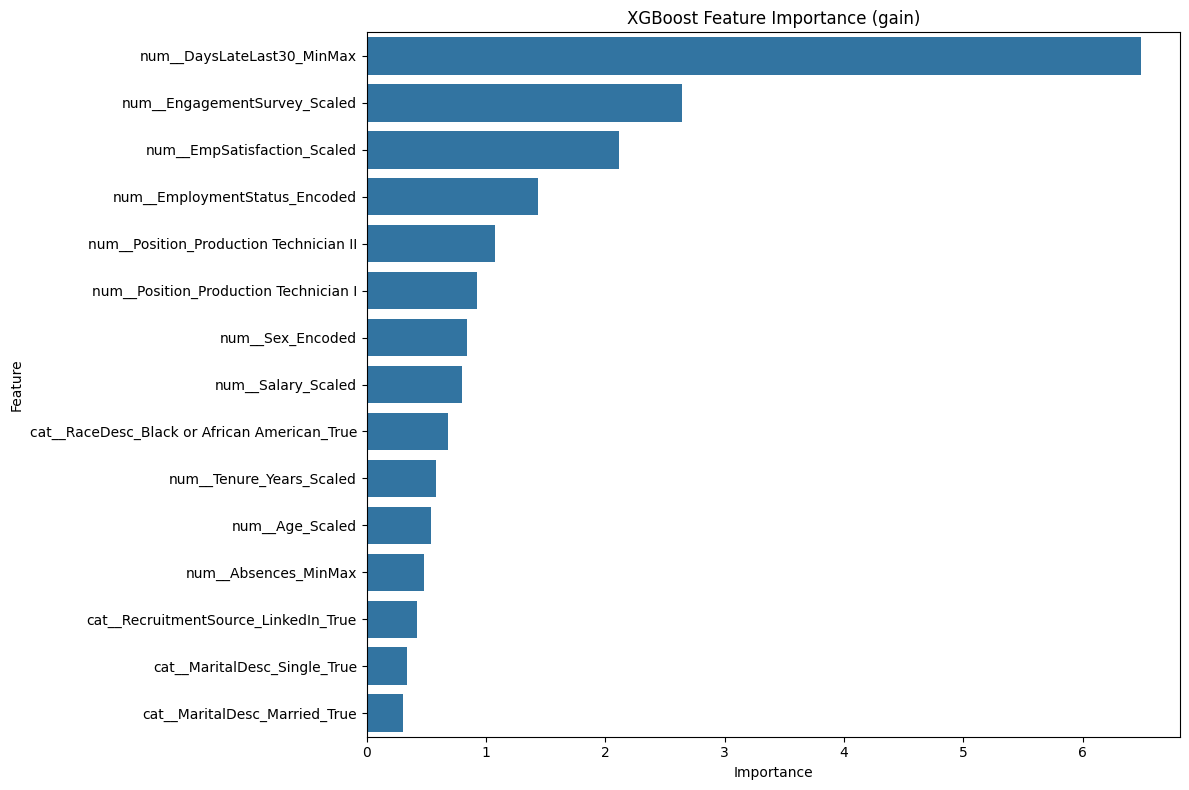

Top 10 features by XGBoost gain importance:
                                         Feature  Importance
0                     num__DaysLateLast30_MinMax    6.489534
1                   num__EngagementSurvey_Scaled    2.642005
5                    num__EmpSatisfaction_Scaled    2.117221
7                  num__EmploymentStatus_Encoded    1.439445
10        num__Position_Production Technician II    1.076525
9          num__Position_Production Technician I    0.925630
8                               num__Sex_Encoded    0.840493
4                             num__Salary_Scaled    0.797186
12  cat__RaceDesc_Black or African American_True    0.677818
2                       num__Tenure_Years_Scaled    0.580053

Class-by-Class SHAP Analysis Completed.
Outputs saved to class1_shap/, class2_shap/, class3_shap/, and class4_shap/ directories


In [ ]:
# =====================
# Class-by-Class SHAP Analysis (Separate Analysis for Each Class)
# =====================
import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
import pickle
from sklearn.model_selection import train_test_split
import os

print("Loading data and model...")

# Load data
df = pd.read_csv('employee_data_adasyn.csv')

# Convert string True/False to boolean for relevant columns
string_bool_columns = [col for col in df.columns if df[col].dtype == 'object' and
                       set(df[col].unique()).issubset({"True", "False"})]
for col in string_bool_columns:
    df[col] = df[col].map({"True": True, "False": False})

# Define features and target variable
X = df.drop('PerformanceScore_Encoded', axis=1)
original_y = df['PerformanceScore_Encoded']  # Original 1-4 classes
y = original_y - 1  # Convert to 0-based for XGBoost

# Print class distribution
print("Class distribution in original data:")
for cls in sorted(original_y.unique()):
    count = sum(original_y == cls)
    percentage = count / len(original_y) * 100
    print(f"  Performance Score {cls}: {count} employees ({percentage:.1f}%)")

# Get the original data split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Load the model
model_path = 'gb_employee_model.pkl'
with open(model_path, 'rb') as file:
    best_model = pickle.load(file)

# Get the XGBoost model from the pipeline
xgb_model = best_model.named_steps['classifier']

# Get the preprocessor
preprocessor = best_model.named_steps['preprocessor']

# Create directories for each class's outputs
for i in range(1, 5):
    os.makedirs(f'class{i}_shap', exist_ok=True)

print("\nPreparing for Class-by-Class SHAP Analysis...")

# Function to transform data through the preprocessor
def transform_data(X_data):
    """Transform data through the sklearn pipeline's preprocessor"""
    return preprocessor.transform(X_data)

# Create a background dataset for the explainer (using a subset of training data)
if len(X_train) > 100:
    X_background = X_train.sample(100, random_state=42)
else:
    X_background = X_train

# Process the background data through the preprocessor
X_background_processed = transform_data(X_background)

# Calculate SHAP values for a subset of the test data (for efficiency)
if len(X_test) > 100:
    X_shap = X_test.sample(100, random_state=42)
else:
    X_shap = X_test

# Process the test data subset through the preprocessor
X_shap_processed = transform_data(X_shap)

# Try to get feature names after preprocessing
try:
    # For newer scikit-learn versions
    feature_names = list(preprocessor.get_feature_names_out())
except:
    # Fallback to generic feature names
    feature_names = [f"feature_{i}" for i in range(X_shap_processed.shape[1])]
    print("Using generic feature names for visualization")

# Get predictions
probas = best_model.predict_proba(X_shap)
predictions = best_model.predict(X_shap)

# Define class colors for consistent visualization
class_colors = {
    0: '#1f77b4',  # Blue for Score 1
    1: '#ff7f0e',  # Orange for Score 2
    2: '#2ca02c',  # Green for Score 3
    3: '#d62728'   # Red for Score 4
}

# Initialize TreeExplainer
try:
    print("Initializing TreeExplainer for class-by-class analysis...")
    explainer = shap.TreeExplainer(xgb_model)

    # Get SHAP values for all classes
    shap_values = explainer.shap_values(X_shap_processed)

    # For TreeExplainer with XGBoost, expected_value is available directly
    expected_values = explainer.expected_value

    # Verify we have 4 classes
    n_classes = len(shap_values)
    print(f"Found {n_classes} classes for analysis")

    # Original class labels (1-4)
    original_class_labels = [i+1 for i in range(n_classes)]

    # ======================= ANALYSIS FOR CLASS 1 =======================
    class_idx = 0  # 0-based index for class 1
    class_label = class_idx + 1  # 1-based label (class 1)
    print(f"\n\n{'=' * 30} SHAP ANALYSIS FOR CLASS {class_label} {'=' * 30}")

    # 1. Feature Importance for Class 1
    print(f"\n1. Feature Importance for Class {class_label}")

    # Calculate mean absolute SHAP values for this class
    class_importance = np.abs(shap_values[class_idx]).mean(0)

    # Create and sort DataFrame
    class_importance_df = pd.DataFrame({
        'Feature': feature_names,
        'SHAP_Importance': class_importance
    })
    class_importance_df = class_importance_df.sort_values('SHAP_Importance', ascending=False)

    print(f"Top 15 most important features for Class {class_label}:")
    print(class_importance_df.head(15))

    # Bar plot for this class
    plt.figure(figsize=(12, 8))
    sns.barplot(x='SHAP_Importance', y='Feature', data=class_importance_df.head(15), color=class_colors[class_idx])
    plt.title(f'SHAP Feature Importance for Class {class_label}', fontsize=16)
    plt.tight_layout()
    plt.savefig(f'class{class_label}_shap/feature_importance.png')
    plt.show()

    # 2. SHAP Summary Plot for Class 1
    print(f"\n2. SHAP Summary Plot for Class {class_label}")

    plt.figure(figsize=(12, 8))
    shap.summary_plot(
        shap_values[class_idx],
        X_shap_processed,
        feature_names=feature_names,
        show=False,
        color=class_colors[class_idx]
    )
    plt.title(f'SHAP Summary Plot for Class {class_label}', fontsize=16)
    plt.tight_layout()
    plt.savefig(f'class{class_label}_shap/summary_plot.png')
    plt.show()

    # 3. Top Feature Dependence Plots for Class 1
    print(f"\n3. Feature Dependence Plots for Class {class_label}")

    # Get top 5 features for this class
    top_features = class_importance_df.head(5)['Feature'].values

    for i, feature in enumerate(top_features):
        feature_idx = feature_names.index(feature)

        plt.figure(figsize=(10, 6))
        shap.dependence_plot(
            feature_idx,
            shap_values[class_idx],
            X_shap_processed,
            feature_names=feature_names,
            show=False,
            color=class_colors[class_idx]
        )
        plt.title(f'SHAP Dependence Plot for Class {class_label}: {feature}', fontsize=16)
        plt.tight_layout()
        plt.savefig(f'class{class_label}_shap/dependence_plot_{i+1}.png')
        plt.show()

        print(f"  Created dependence plot for {feature}")

    # 4. Decision Plot for Class 1 (if available)
    print(f"\n4. Decision Plot for Class {class_label}")

    # Find instances predicted as this class
    class_instances = np.where(predictions == class_idx)[0]

    if len(class_instances) > 0:
        # Find instance with highest probability
        class_probas = probas[class_instances, class_idx]
        representative_idx = class_instances[np.argmax(class_probas)]
        confidence = probas[representative_idx, class_idx]

        try:
            plt.figure(figsize=(12, 8))
            shap.decision_plot(
                expected_values[class_idx],
                shap_values[class_idx][representative_idx],
                feature_names=feature_names,
                show=False
            )
            plt.title(f'SHAP Decision Plot for Class {class_label} (Confidence: {confidence:.4f})', fontsize=16)
            plt.tight_layout()
            plt.savefig(f'class{class_label}_shap/decision_plot.png')
            plt.show()

            print(f"  Created decision plot (confidence: {confidence:.4f})")
        except Exception as e:
            print(f"  Could not create decision plot: {e}")
    else:
        print(f"  No instances of Class {class_label} found in sample")

    # 5. Force Plots for Class 1 Examples
    print(f"\n5. Force Plots for Class {class_label} Examples")

    # Find instances predicted as this class
    if len(class_instances) > 0:
        # Take up to 3 examples
        num_examples = min(3, len(class_instances))

        # Sort by confidence
        class_probas = probas[class_instances, class_idx]
        sorted_indices = class_instances[np.argsort(-class_probas)]

        for i in range(num_examples):
            idx = sorted_indices[i]
            confidence = probas[idx, class_idx]

            plt.figure(figsize=(14, 4))
            shap.force_plot(
                expected_values[class_idx],
                shap_values[class_idx][idx],
                features=X_shap_processed[idx],
                feature_names=feature_names,
                matplotlib=True,
                show=False
            )
            plt.title(f'SHAP Force Plot for Class {class_label} - Example {i+1} (Confidence: {confidence:.4f})', fontsize=14)
            plt.tight_layout()
            plt.savefig(f'class{class_label}_shap/force_plot_{i+1}.png')
            plt.show()

            # Show top contributors
            contributions = pd.DataFrame({
                'Feature': feature_names,
                'SHAP_Value': shap_values[class_idx][idx],
                'Abs_Value': np.abs(shap_values[class_idx][idx])
            }).sort_values('Abs_Value', ascending=False)

            print(f"  Example {i+1} (Confidence: {confidence:.4f}) - Top contributors:")
            for _, row in contributions.head(5).iterrows():
                direction = "increases" if row['SHAP_Value'] > 0 else "decreases"
                print(f"    {row['Feature']}: {row['SHAP_Value']:.4f} ({direction} likelihood)")
    else:
        print(f"  No instances of Class {class_label} found in sample")

    # 6. Waterfall Plot for Class 1 (if available)
    print(f"\n6. Waterfall Plot for Class {class_label}")

    if len(class_instances) > 0:
        idx = sorted_indices[0]  # Use the highest confidence example
        confidence = probas[idx, class_idx]

        try:
            plt.figure(figsize=(12, 10))
            shap.plots._waterfall.waterfall_legacy(
                expected_values[class_idx],
                shap_values[class_idx][idx],
                feature_names=feature_names,
                max_display=15,
                show=False
            )
            plt.title(f'SHAP Waterfall Plot for Class {class_label} (Confidence: {confidence:.4f})', fontsize=16)
            plt.tight_layout()
            plt.savefig(f'class{class_label}_shap/waterfall_plot.png')
            plt.show()

            print(f"  Created waterfall plot (confidence: {confidence:.4f})")
        except Exception as e:
            print(f"  Could not create waterfall plot: {e}")

    # 7. Feature Interaction Analysis for Class 1 (if available)
    print(f"\n7. Feature Interaction Analysis for Class {class_label}")

    try:
        # Get the top feature for this class
        top_feature = class_importance_df.iloc[0]['Feature']
        top_feature_idx = feature_names.index(top_feature)

        print(f"  Analyzing interactions for top feature: {top_feature}")

        # Create dependence plots with color showing interactions with other features
        for j in range(1, min(4, len(class_importance_df))):
            interaction_feature = class_importance_df.iloc[j]['Feature']
            interaction_idx = feature_names.index(interaction_feature)

            plt.figure(figsize=(10, 6))
            shap.dependence_plot(
                top_feature_idx,
                shap_values[class_idx],
                X_shap_processed,
                feature_names=feature_names,
                interaction_index=interaction_idx,
                show=False
            )
            plt.title(f'Class {class_label}: {top_feature} vs {interaction_feature} Interaction', fontsize=16)
            plt.tight_layout()
            plt.savefig(f'class{class_label}_shap/interaction_plot_{j}.png')
            plt.show()

            print(f"  Created interaction plot with {interaction_feature}")
    except Exception as e:
        print(f"  Feature interaction analysis failed: {e}")

    # ======================= ANALYSIS FOR CLASS 2 =======================
    class_idx = 1  # 0-based index for class 2
    class_label = class_idx + 1  # 1-based label (class 2)
    print(f"\n\n{'=' * 30} SHAP ANALYSIS FOR CLASS {class_label} {'=' * 30}")

    # 1. Feature Importance for Class 2
    print(f"\n1. Feature Importance for Class {class_label}")

    # Calculate mean absolute SHAP values for this class
    class_importance = np.abs(shap_values[class_idx]).mean(0)

    # Create and sort DataFrame
    class_importance_df = pd.DataFrame({
        'Feature': feature_names,
        'SHAP_Importance': class_importance
    })
    class_importance_df = class_importance_df.sort_values('SHAP_Importance', ascending=False)

    print(f"Top 15 most important features for Class {class_label}:")
    print(class_importance_df.head(15))

    # Bar plot for this class
    plt.figure(figsize=(12, 8))
    sns.barplot(x='SHAP_Importance', y='Feature', data=class_importance_df.head(15), color=class_colors[class_idx])
    plt.title(f'SHAP Feature Importance for Class {class_label}', fontsize=16)
    plt.tight_layout()
    plt.savefig(f'class{class_label}_shap/feature_importance.png')
    plt.show()

    # 2. SHAP Summary Plot for Class 2
    print(f"\n2. SHAP Summary Plot for Class {class_label}")

    plt.figure(figsize=(12, 8))
    shap.summary_plot(
        shap_values[class_idx],
        X_shap_processed,
        feature_names=feature_names,
        show=False,
        color=class_colors[class_idx]
    )
    plt.title(f'SHAP Summary Plot for Class {class_label}', fontsize=16)
    plt.tight_layout()
    plt.savefig(f'class{class_label}_shap/summary_plot.png')
    plt.show()

    # 3. Top Feature Dependence Plots for Class 2
    print(f"\n3. Feature Dependence Plots for Class {class_label}")

    # Get top 5 features for this class
    top_features = class_importance_df.head(5)['Feature'].values

    for i, feature in enumerate(top_features):
        feature_idx = feature_names.index(feature)

        plt.figure(figsize=(10, 6))
        shap.dependence_plot(
            feature_idx,
            shap_values[class_idx],
            X_shap_processed,
            feature_names=feature_names,
            show=False,
            color=class_colors[class_idx]
        )
        plt.title(f'SHAP Dependence Plot for Class {class_label}: {feature}', fontsize=16)
        plt.tight_layout()
        plt.savefig(f'class{class_label}_shap/dependence_plot_{i+1}.png')
        plt.show()

        print(f"  Created dependence plot for {feature}")

    # 4. Decision Plot for Class 2 (if available)
    print(f"\n4. Decision Plot for Class {class_label}")

    # Find instances predicted as this class
    class_instances = np.where(predictions == class_idx)[0]

    if len(class_instances) > 0:
        # Find instance with highest probability
        class_probas = probas[class_instances, class_idx]
        representative_idx = class_instances[np.argmax(class_probas)]
        confidence = probas[representative_idx, class_idx]

        try:
            plt.figure(figsize=(12, 8))
            shap.decision_plot(
                expected_values[class_idx],
                shap_values[class_idx][representative_idx],
                feature_names=feature_names,
                show=False
            )
            plt.title(f'SHAP Decision Plot for Class {class_label} (Confidence: {confidence:.4f})', fontsize=16)
            plt.tight_layout()
            plt.savefig(f'class{class_label}_shap/decision_plot.png')
            plt.show()

            print(f"  Created decision plot (confidence: {confidence:.4f})")
        except Exception as e:
            print(f"  Could not create decision plot: {e}")
    else:
        print(f"  No instances of Class {class_label} found in sample")

    # 5. Force Plots for Class 2 Examples
    print(f"\n5. Force Plots for Class {class_label} Examples")

    # Find instances predicted as this class
    if len(class_instances) > 0:
        # Take up to 3 examples
        num_examples = min(3, len(class_instances))

        # Sort by confidence
        class_probas = probas[class_instances, class_idx]
        sorted_indices = class_instances[np.argsort(-class_probas)]

        for i in range(num_examples):
            idx = sorted_indices[i]
            confidence = probas[idx, class_idx]

            plt.figure(figsize=(14, 4))
            shap.force_plot(
                expected_values[class_idx],
                shap_values[class_idx][idx],
                features=X_shap_processed[idx],
                feature_names=feature_names,
                matplotlib=True,
                show=False
            )
            plt.title(f'SHAP Force Plot for Class {class_label} - Example {i+1} (Confidence: {confidence:.4f})', fontsize=14)
            plt.tight_layout()
            plt.savefig(f'class{class_label}_shap/force_plot_{i+1}.png')
            plt.show()

            # Show top contributors
            contributions = pd.DataFrame({
                'Feature': feature_names,
                'SHAP_Value': shap_values[class_idx][idx],
                'Abs_Value': np.abs(shap_values[class_idx][idx])
            }).sort_values('Abs_Value', ascending=False)

            print(f"  Example {i+1} (Confidence: {confidence:.4f}) - Top contributors:")
            for _, row in contributions.head(5).iterrows():
                direction = "increases" if row['SHAP_Value'] > 0 else "decreases"
                print(f"    {row['Feature']}: {row['SHAP_Value']:.4f} ({direction} likelihood)")
    else:
        print(f"  No instances of Class {class_label} found in sample")

    # 6. Waterfall Plot for Class 2 (if available)
    print(f"\n6. Waterfall Plot for Class {class_label}")

    if len(class_instances) > 0:
        idx = sorted_indices[0]  # Use the highest confidence example
        confidence = probas[idx, class_idx]

        try:
            plt.figure(figsize=(12, 10))
            shap.plots._waterfall.waterfall_legacy(
                expected_values[class_idx],
                shap_values[class_idx][idx],
                feature_names=feature_names,
                max_display=15,
                show=False
            )
            plt.title(f'SHAP Waterfall Plot for Class {class_label} (Confidence: {confidence:.4f})', fontsize=16)
            plt.tight_layout()
            plt.savefig(f'class{class_label}_shap/waterfall_plot.png')
            plt.show()

            print(f"  Created waterfall plot (confidence: {confidence:.4f})")
        except Exception as e:
            print(f"  Could not create waterfall plot: {e}")

    # 7. Feature Interaction Analysis for Class 2 (if available)
    print(f"\n7. Feature Interaction Analysis for Class {class_label}")

    try:
        # Get the top feature for this class
        top_feature = class_importance_df.iloc[0]['Feature']
        top_feature_idx = feature_names.index(top_feature)

        print(f"  Analyzing interactions for top feature: {top_feature}")

        # Create dependence plots with color showing interactions with other features
        for j in range(1, min(4, len(class_importance_df))):
            interaction_feature = class_importance_df.iloc[j]['Feature']
            interaction_idx = feature_names.index(interaction_feature)

            plt.figure(figsize=(10, 6))
            shap.dependence_plot(
                top_feature_idx,
                shap_values[class_idx],
                X_shap_processed,
                feature_names=feature_names,
                interaction_index=interaction_idx,
                show=False
            )
            plt.title(f'Class {class_label}: {top_feature} vs {interaction_feature} Interaction', fontsize=16)
            plt.tight_layout()
            plt.savefig(f'class{class_label}_shap/interaction_plot_{j}.png')
            plt.show()

            print(f"  Created interaction plot with {interaction_feature}")
    except Exception as e:
        print(f"  Feature interaction analysis failed: {e}")

    # ======================= ANALYSIS FOR CLASS 3 =======================
    class_idx = 2  # 0-based index for class 3
    class_label = class_idx + 1  # 1-based label (class 3)
    print(f"\n\n{'=' * 30} SHAP ANALYSIS FOR CLASS {class_label} {'=' * 30}")

    # 1. Feature Importance for Class 3
    print(f"\n1. Feature Importance for Class {class_label}")

    # Calculate mean absolute SHAP values for this class
    class_importance = np.abs(shap_values[class_idx]).mean(0)

    # Create and sort DataFrame
    class_importance_df = pd.DataFrame({
        'Feature': feature_names,
        'SHAP_Importance': class_importance
    })
    class_importance_df = class_importance_df.sort_values('SHAP_Importance', ascending=False)

    print(f"Top 15 most important features for Class {class_label}:")
    print(class_importance_df.head(15))

    # Bar plot for this class
    plt.figure(figsize=(12, 8))
    sns.barplot(x='SHAP_Importance', y='Feature', data=class_importance_df.head(15), color=class_colors[class_idx])
    plt.title(f'SHAP Feature Importance for Class {class_label}', fontsize=16)
    plt.tight_layout()
    plt.savefig(f'class{class_label}_shap/feature_importance.png')
    plt.show()

    # 2. SHAP Summary Plot for Class 3
    print(f"\n2. SHAP Summary Plot for Class {class_label}")

    plt.figure(figsize=(12, 8))
    shap.summary_plot(
        shap_values[class_idx],
        X_shap_processed,
        feature_names=feature_names,
        show=False,
        color=class_colors[class_idx]
    )
    plt.title(f'SHAP Summary Plot for Class {class_label}', fontsize=16)
    plt.tight_layout()
    plt.savefig(f'class{class_label}_shap/summary_plot.png')
    plt.show()

    # 3. Top Feature Dependence Plots for Class 3
    print(f"\n3. Feature Dependence Plots for Class {class_label}")

    # Get top 5 features for this class
    top_features = class_importance_df.head(5)['Feature'].values

    for i, feature in enumerate(top_features):
        feature_idx = feature_names.index(feature)

        plt.figure(figsize=(10, 6))
        shap.dependence_plot(
            feature_idx,
            shap_values[class_idx],
            X_shap_processed,
            feature_names=feature_names,
            show=False,
            color=class_colors[class_idx]
        )
        plt.title(f'SHAP Dependence Plot for Class {class_label}: {feature}', fontsize=16)
        plt.tight_layout()
        plt.savefig(f'class{class_label}_shap/dependence_plot_{i+1}.png')
        plt.show()

        print(f"  Created dependence plot for {feature}")

    # 4. Decision Plot for Class 3 (if available)
    print(f"\n4. Decision Plot for Class {class_label}")

    # Find instances predicted as this class
    class_instances = np.where(predictions == class_idx)[0]

    if len(class_instances) > 0:
        # Find instance with highest probability
        class_probas = probas[class_instances, class_idx]
        representative_idx = class_instances[np.argmax(class_probas)]
        confidence = probas[representative_idx, class_idx]

        try:
            plt.figure(figsize=(12, 8))
            shap.decision_plot(
                expected_values[class_idx],
                shap_values[class_idx][representative_idx],
                feature_names=feature_names,
                show=False
            )
            plt.title(f'SHAP Decision Plot for Class {class_label} (Confidence: {confidence:.4f})', fontsize=16)
            plt.tight_layout()
            plt.savefig(f'class{class_label}_shap/decision_plot.png')
            plt.show()

            print(f"  Created decision plot (confidence: {confidence:.4f})")
        except Exception as e:
            print(f"  Could not create decision plot: {e}")
    else:
        print(f"  No instances of Class {class_label} found in sample")

    # 5. Force Plots for Class 3 Examples
    print(f"\n5. Force Plots for Class {class_label} Examples")

    # Find instances predicted as this class
    if len(class_instances) > 0:
        # Take up to 3 examples
        num_examples = min(3, len(class_instances))

        # Sort by confidence
        class_probas = probas[class_instances, class_idx]
        sorted_indices = class_instances[np.argsort(-class_probas)]

        for i in range(num_examples):
            idx = sorted_indices[i]
            confidence = probas[idx, class_idx]

            plt.figure(figsize=(14, 4))
            shap.force_plot(
                expected_values[class_idx],
                shap_values[class_idx][idx],
                features=X_shap_processed[idx],
                feature_names=feature_names,
                matplotlib=True,
                show=False
            )
            plt.title(f'SHAP Force Plot for Class {class_label} - Example {i+1} (Confidence: {confidence:.4f})', fontsize=14)
            plt.tight_layout()
            plt.savefig(f'class{class_label}_shap/force_plot_{i+1}.png')
            plt.show()

            # Show top contributors
            contributions = pd.DataFrame({
                'Feature': feature_names,
                'SHAP_Value': shap_values[class_idx][idx],
                'Abs_Value': np.abs(shap_values[class_idx][idx])
            }).sort_values('Abs_Value', ascending=False)

            print(f"  Example {i+1} (Confidence: {confidence:.4f}) - Top contributors:")
            for _, row in contributions.head(5).iterrows():
                direction = "increases" if row['SHAP_Value'] > 0 else "decreases"
                print(f"    {row['Feature']}: {row['SHAP_Value']:.4f} ({direction} likelihood)")
    else:
        print(f"  No instances of Class {class_label} found in sample")

    # 6. Waterfall Plot for Class 3 (if available)
    print(f"\n6. Waterfall Plot for Class {class_label}")

    if len(class_instances) > 0:
        idx = sorted_indices[0]  # Use the highest confidence example
        confidence = probas[idx, class_idx]

        try:
            plt.figure(figsize=(12, 10))
            shap.plots._waterfall.waterfall_legacy(
                expected_values[class_idx],
                shap_values[class_idx][idx],
                feature_names=feature_names,
                max_display=15,
                show=False
            )
            plt.title(f'SHAP Waterfall Plot for Class {class_label} (Confidence: {confidence:.4f})', fontsize=16)
            plt.tight_layout()
            plt.savefig(f'class{class_label}_shap/waterfall_plot.png')
            plt.show()

            print(f"  Created waterfall plot (confidence: {confidence:.4f})")
        except Exception as e:
            print(f"  Could not create waterfall plot: {e}")

    # 7. Feature Interaction Analysis for Class 3 (if available)
    print(f"\n7. Feature Interaction Analysis for Class {class_label}")

    try:
        # Get the top feature for this class
        top_feature = class_importance_df.iloc[0]['Feature']
        top_feature_idx = feature_names.index(top_feature)

        print(f"  Analyzing interactions for top feature: {top_feature}")

        # Create dependence plots with color showing interactions with other features
        for j in range(1, min(4, len(class_importance_df))):
            interaction_feature = class_importance_df.iloc[j]['Feature']
            interaction_idx = feature_names.index(interaction_feature)

            plt.figure(figsize=(10, 6))
            shap.dependence_plot(
                top_feature_idx,
                shap_values[class_idx],
                X_shap_processed,
                feature_names=feature_names,
                interaction_index=interaction_idx,
                show=False
            )
            plt.title(f'Class {class_label}: {top_feature} vs {interaction_feature} Interaction', fontsize=16)
            plt.tight_layout()
            plt.savefig(f'class{class_label}_shap/interaction_plot_{j}.png')
            plt.show()

            print(f"  Created interaction plot with {interaction_feature}")
    except Exception as e:
        print(f"  Feature interaction analysis failed: {e}")

    # ======================= ANALYSIS FOR CLASS 4 =======================
    class_idx = 3  # 0-based index for class 4
    class_label = class_idx + 1  # 1-based label (class 4)
    print(f"\n\n{'=' * 30} SHAP ANALYSIS FOR CLASS {class_label} {'=' * 30}")

    # 1. Feature Importance for Class 4
    print(f"\n1. Feature Importance for Class {class_label}")

    # Calculate mean absolute SHAP values for this class
    class_importance = np.abs(shap_values[class_idx]).mean(0)

    # Create and sort DataFrame
    class_importance_df = pd.DataFrame({
        'Feature': feature_names,
        'SHAP_Importance': class_importance
    })
    class_importance_df = class_importance_df.sort_values('SHAP_Importance', ascending=False)

    print(f"Top 15 most important features for Class {class_label}:")
    print(class_importance_df.head(15))

    # Bar plot for this class
    plt.figure(figsize=(12, 8))
    sns.barplot(x='SHAP_Importance', y='Feature', data=class_importance_df.head(15), color=class_colors[class_idx])
    plt.title(f'SHAP Feature Importance for Class {class_label}', fontsize=16)
    plt.tight_layout()
    plt.savefig(f'class{class_label}_shap/feature_importance.png')
    plt.show()

    # 2. SHAP Summary Plot for Class 4
    print(f"\n2. SHAP Summary Plot for Class {class_label}")

    plt.figure(figsize=(12, 8))
    shap.summary_plot(
        shap_values[class_idx],
        X_shap_processed,
        feature_names=feature_names,
        show=False,
        color=class_colors[class_idx]
    )
    plt.title(f'SHAP Summary Plot for Class {class_label}', fontsize=16)
    plt.tight_layout()
    plt.savefig(f'class{class_label}_shap/summary_plot.png')
    plt.show()

    # 3. Top Feature Dependence Plots for Class 4
    print(f"\n3. Feature Dependence Plots for Class {class_label}")

    # Get top 5 features for this class
    top_features = class_importance_df.head(5)['Feature'].values

    for i, feature in enumerate(top_features):
        feature_idx = feature_names.index(feature)

        plt.figure(figsize=(10, 6))
        shap.dependence_plot(
            feature_idx,
            shap_values[class_idx],
            X_shap_processed,
            feature_names=feature_names,
            show=False,
            color=class_colors[class_idx]
        )
        plt.title(f'SHAP Dependence Plot for Class {class_label}: {feature}', fontsize=16)
        plt.tight_layout()
        plt.savefig(f'class{class_label}_shap/dependence_plot_{i+1}.png')
        plt.show()

        print(f"  Created dependence plot for {feature}")

    # 4. Decision Plot for Class 4 (if available)
    print(f"\n4. Decision Plot for Class {class_label}")

    # Find instances predicted as this class
    class_instances = np.where(predictions == class_idx)[0]

    if len(class_instances) > 0:
        # Find instance with highest probability
        class_probas = probas[class_instances, class_idx]
        representative_idx = class_instances[np.argmax(class_probas)]
        confidence = probas[representative_idx, class_idx]

        try:
            plt.figure(figsize=(12, 8))
            shap.decision_plot(
                expected_values[class_idx],
                shap_values[class_idx][representative_idx],
                feature_names=feature_names,
                show=False
            )
            plt.title(f'SHAP Decision Plot for Class {class_label} (Confidence: {confidence:.4f})', fontsize=16)
            plt.tight_layout()
            plt.savefig(f'class{class_label}_shap/decision_plot.png')
            plt.show()

            print(f"  Created decision plot (confidence: {confidence:.4f})")
        except Exception as e:
            print(f"  Could not create decision plot: {e}")
    else:
        print(f"  No instances of Class {class_label} found in sample")

    # 5. Force Plots for Class 4 Examples
    print(f"\n5. Force Plots for Class {class_label} Examples")

    # Find instances predicted as this class
    if len(class_instances) > 0:
        # Take up to 3 examples
        num_examples = min(3, len(class_instances))

        # Sort by confidence
        class_probas = probas[class_instances, class_idx]
        sorted_indices = class_instances[np.argsort(-class_probas)]

        for i in range(num_examples):
            idx = sorted_indices[i]
            confidence = probas[idx, class_idx]

            plt.figure(figsize=(14, 4))
            shap.force_plot(
                expected_values[class_idx],
                shap_values[class_idx][idx],
                features=X_shap_processed[idx],
                feature_names=feature_names,
                matplotlib=True,
                show=False
            )
            plt.title(f'SHAP Force Plot for Class {class_label} - Example {i+1} (Confidence: {confidence:.4f})', fontsize=14)
            plt.tight_layout()
            plt.savefig(f'class{class_label}_shap/force_plot_{i+1}.png')
            plt.show()

            # Show top contributors
            contributions = pd.DataFrame({
                'Feature': feature_names,
                'SHAP_Value': shap_values[class_idx][idx],
                'Abs_Value': np.abs(shap_values[class_idx][idx])
            }).sort_values('Abs_Value', ascending=False)

            print(f"  Example {i+1} (Confidence: {confidence:.4f}) - Top contributors:")
            for _, row in contributions.head(5).iterrows():
                direction = "increases" if row['SHAP_Value'] > 0 else "decreases"
                print(f"    {row['Feature']}: {row['SHAP_Value']:.4f} ({direction} likelihood)")
    else:
        print(f"  No instances of Class {class_label} found in sample")

    # 6. Waterfall Plot for Class 4 (if available)
    print(f"\n6. Waterfall Plot for Class {class_label}")

    if len(class_instances) > 0:
        idx = sorted_indices[0]  # Use the highest confidence example
        confidence = probas[idx, class_idx]

        try:
            plt.figure(figsize=(12, 10))
            shap.plots._waterfall.waterfall_legacy(
                expected_values[class_idx],
                shap_values[class_idx][idx],
                feature_names=feature_names,
                max_display=15,
                show=False
            )
            plt.title(f'SHAP Waterfall Plot for Class {class_label} (Confidence: {confidence:.4f})', fontsize=16)
            plt.tight_layout()
            plt.savefig(f'class{class_label}_shap/waterfall_plot.png')
            plt.show()

            print(f"  Created waterfall plot (confidence: {confidence:.4f})")
        except Exception as e:
            print(f"  Could not create waterfall plot: {e}")

    # 7. Feature Interaction Analysis for Class 4 (if available)
    print(f"\n7. Feature Interaction Analysis for Class {class_label}")

    try:
        # Get the top feature for this class
        top_feature = class_importance_df.iloc[0]['Feature']
        top_feature_idx = feature_names.index(top_feature)

        print(f"  Analyzing interactions for top feature: {top_feature}")

        # Create dependence plots with color showing interactions with other features
        for j in range(1, min(4, len(class_importance_df))):
            interaction_feature = class_importance_df.iloc[j]['Feature']
            interaction_idx = feature_names.index(interaction_feature)

            plt.figure(figsize=(10, 6))
            shap.dependence_plot(
                top_feature_idx,
                shap_values[class_idx],
                X_shap_processed,
                feature_names=feature_names,
                interaction_index=interaction_idx,
                show=False
            )
            plt.title(f'Class {class_label}: {top_feature} vs {interaction_feature} Interaction', fontsize=16)
            plt.tight_layout()
            plt.savefig(f'class{class_label}_shap/interaction_plot_{j}.png')
            plt.show()

            print(f"  Created interaction plot with {interaction_feature}")
    except Exception as e:
        print(f"  Feature interaction analysis failed: {e}")

except Exception as e:
    print(f"Error in SHAP analysis: {e}")

    # Fallback to simpler analysis using XGBoost's built-in feature importance
    try:
        print("\nFalling back to XGBoost's built-in feature importance...")

        # Get feature importance from the model
        importance_type = 'gain'  # 'weight', 'gain', 'cover', 'total_gain', 'total_cover'
        importances = xgb_model.get_booster().get_score(importance_type=importance_type)

        # Try to get feature names
        try:
            feature_names = list(preprocessor.get_feature_names_out())
        except:
            feature_names = [f"f{i}" for i in range(X_shap_processed.shape[1])]
            print("Using generic feature names for visualization")

        # Convert to DataFrame
        importance_df = pd.DataFrame({
            'Feature': [feature_names[int(f.replace('f', ''))] if f.startswith('f') else f for f in importances.keys()],
            'Importance': list(importances.values())
        }).sort_values('Importance', ascending=False)

        # Plot
        plt.figure(figsize=(12, 8))
        sns.barplot(x='Importance', y='Feature', data=importance_df.head(15))
        plt.title(f'XGBoost Feature Importance ({importance_type})')
        plt.tight_layout()
        plt.savefig(f'xgboost_importance_{importance_type}.png')
        plt.show()

        print(f"Top 10 features by XGBoost {importance_type} importance:")
        print(importance_df.head(10))

    except Exception as e:
        print(f"Fallback analysis failed: {e}")

print("\nClass-by-Class SHAP Analysis Completed.")
print("Outputs saved to class1_shap/, class2_shap/, class3_shap/, and class4_shap/ directories")

Loading dataset...
Loading model...

Model loaded successfully!
Model type: <class 'sklearn.pipeline.Pipeline'>
Pipeline steps: dict_keys(['preprocessor', 'classifier'])
n_estimators: 200
learning_rate: 0.1
max_depth: 7
subsample: 1.0
colsample_bytree: 0.8
Training set size: 767 samples, 15 features
Test set size: 192 samples, 15 features

Class distribution:
Training set:
  Class 2 (original 3): 25.29% (194 samples)
  Class 0 (original 1): 25.16% (193 samples)
  Class 1 (original 2): 25.03% (192 samples)
  Class 3 (original 4): 24.51% (188 samples)
Test set:
  Class 2 (original 3): 25.52% (49 samples)
  Class 1 (original 2): 25.00% (48 samples)
  Class 0 (original 1): 25.00% (48 samples)
  Class 3 (original 4): 24.48% (47 samples)
COMPREHENSIVE OVERFITTING ANALYSIS FOR GRADIENT BOOSTING

1. ACCURACY GAP ANALYSIS
Training Accuracy: 1.0000
Test Accuracy: 0.9323
Accuracy Gap (Δ): 0.0677

Detailed Per-Class Accuracy Analysis:
Class      Original   Train Acc  Test Acc   Gap        Status  

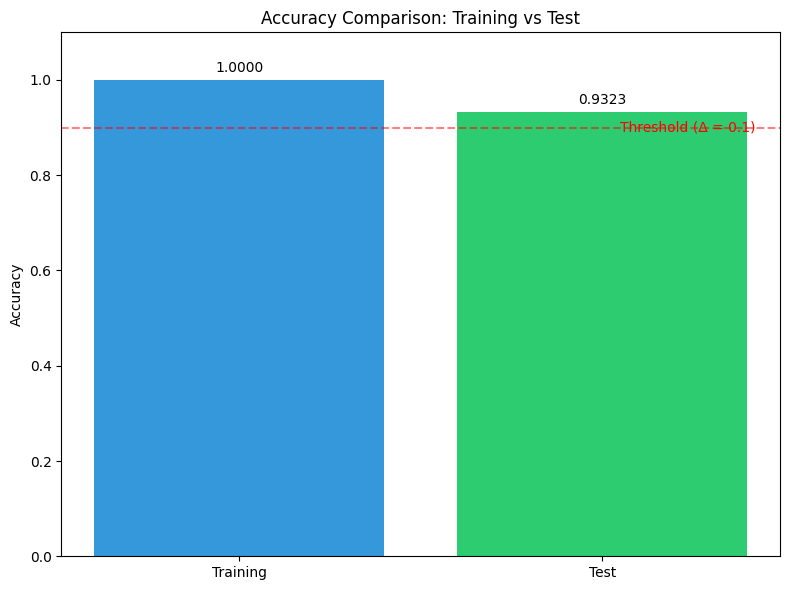


2. LEARNING CURVES ANALYSIS
Average gap between training and validation: 0.1407
Are curves converging? No
Are curves stable? No

Detailed Learning Curve Data:
Training Size   Train Score     Train Std       Val Score       Val Std         Gap            
------------------------------------------------------------------------------------------
58292           nan         nan         nan         nan         NaN
117351          nan         nan         nan         nan         NaN
176410          nan         nan         nan         nan         NaN
234702          nan         nan         nan         nan         NaN
293761          nan         nan         nan         nan         NaN
352820          1.0000         0.0000         0.7998         0.0801         0.2002
411112          1.0000         0.0000         0.8155         0.0802         0.1845
470171          1.0000         0.0000         0.8332         0.0446         0.1668
529230          1.0000         0.0000         0.9197         0.0

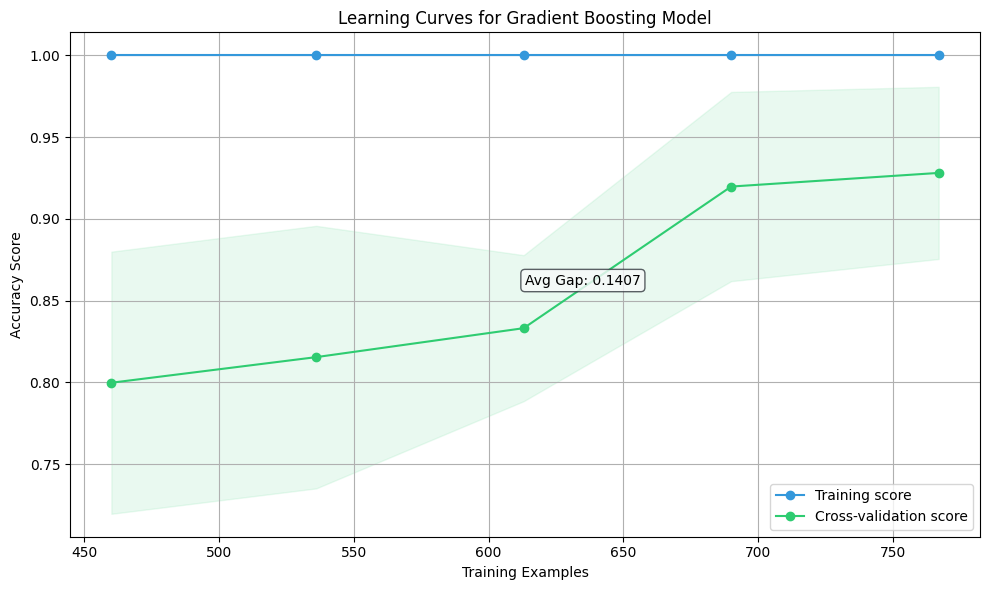


3. ROC ANALYSIS AND AUC COMPARISON
Training Set Macro-AUC: 1.0000
Test Set Macro-AUC: 0.9906
AUC Gap (Δ): 0.0094

Detailed Class-Specific ROC Analysis:
Class      Original   Train AUC    Test AUC     AUC Gap      Status    
----------------------------------------------------------------------
0          1          1.0000      1.0000      0.0000      ✅ OK
1          2          1.0000      1.0000      -0.0000      ✅ OK
2          3          1.0000      0.9813      0.0187      ✅ OK
3          4          1.0000      0.9812      0.0188      ✅ OK

Optimal Operating Points (Test Set):
Class 0 (original 1): Threshold=0.9228, Sensitivity=1.0000, Specificity=1.0000
Class 1 (original 2): Threshold=0.5350, Sensitivity=1.0000, Specificity=1.0000
Class 2 (original 3): Threshold=0.1382, Sensitivity=1.0000, Specificity=0.9231
Class 3 (original 4): Threshold=0.0988, Sensitivity=0.9362, Specificity=0.9034

✅ No significant overfitting detected based on AUC gap (ΔAUC ≤ 0.05)
   The AUC gap of 0.94% sug

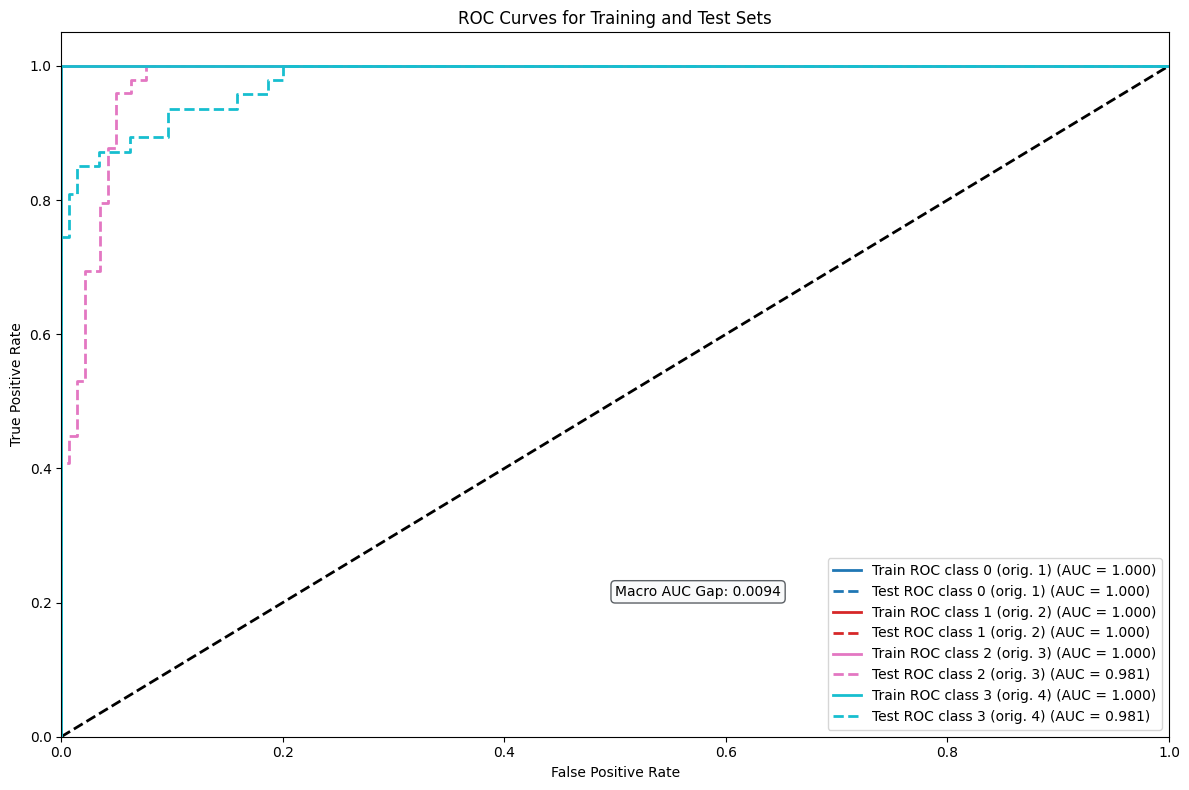

<Figure size 1000x600 with 0 Axes>

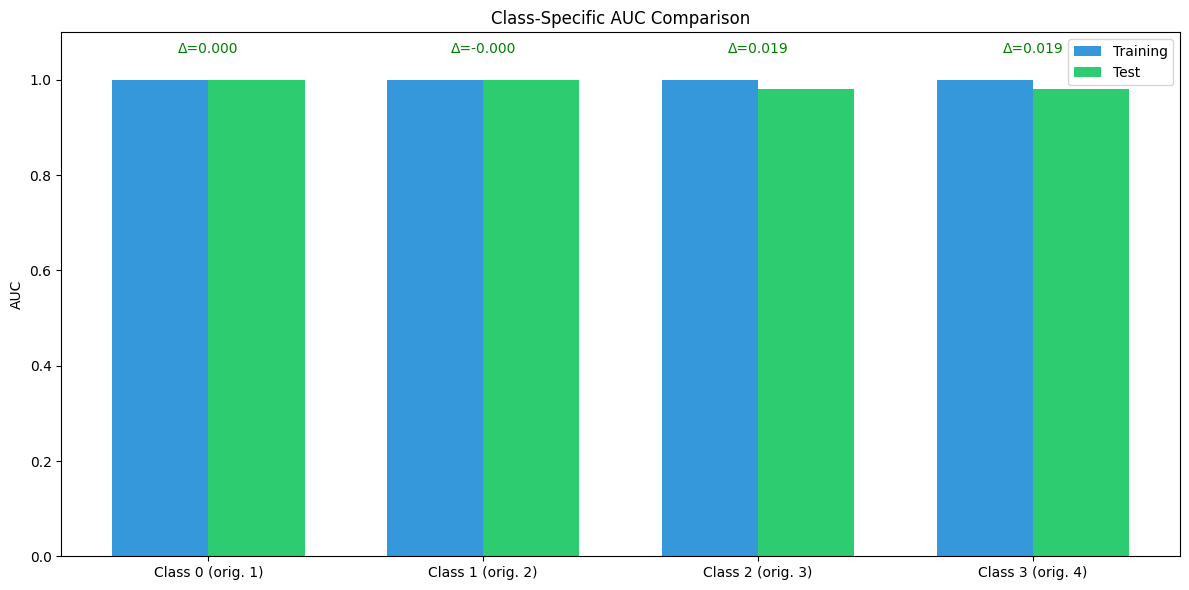


4. CLASS-SPECIFIC METRICS ANALYSIS

Detailed Class-specific Metrics:
Class      Original   Metric     Train      Test       Diff       Status    
----------------------------------------------------------------------
0          1          Precision  1.0000    1.0000    0.0000    ✅ OK
                      Recall     1.0000    1.0000    0.0000    ✅ OK
                      F1-Score   1.0000    1.0000    0.0000    ✅ OK
----------------------------------------------------------------------
1          2          Precision  1.0000    0.9796    0.0204    ✅ OK
                      Recall     1.0000    1.0000    0.0000    ✅ OK
                      F1-Score   1.0000    0.9897    0.0103    ✅ OK
----------------------------------------------------------------------
2          3          Precision  1.0000    0.8600    0.1400    ⚠️ Issue
                      Recall     1.0000    0.8776    0.1224    ⚠️ Issue
                      F1-Score   1.0000    0.8687    0.1313    ⚠️ Issue
----------------

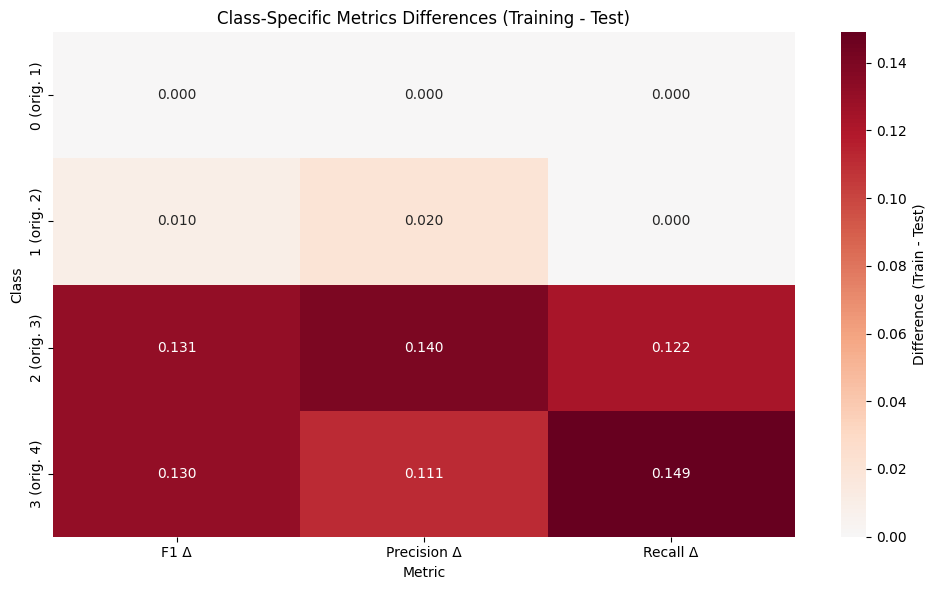


5. PREDICTION CONFIDENCE ANALYSIS

Confidence Statistics:
Statistic       Training        Test            Difference     
------------------------------------------------------------
Mean            0.9916        0.9516        0.0399
Median          0.9962        0.9943        0.0019
Min             0.8881        0.4812        0.4069
Max             0.9997        0.9997        0.0000
Std Dev         0.0121        0.1021        -0.0900

Confidence Distribution by Threshold:
Threshold  Training %      Test %          Difference      Status    
-----------------------------------------------------------------
≥ 0.5      100.00%         99.48%         0.52%           ✅ OK
≥ 0.6      100.00%         97.40%         2.60%           ✅ OK
≥ 0.7      100.00%         94.27%         5.73%           ✅ OK
≥ 0.8      100.00%         90.62%         9.38%           ✅ OK
≥ 0.9      99.87%         86.46%         13.41%           ⚠️ Issue
≥ 0.95     97.91%         78.65%         19.27%           ⚠️ Issue

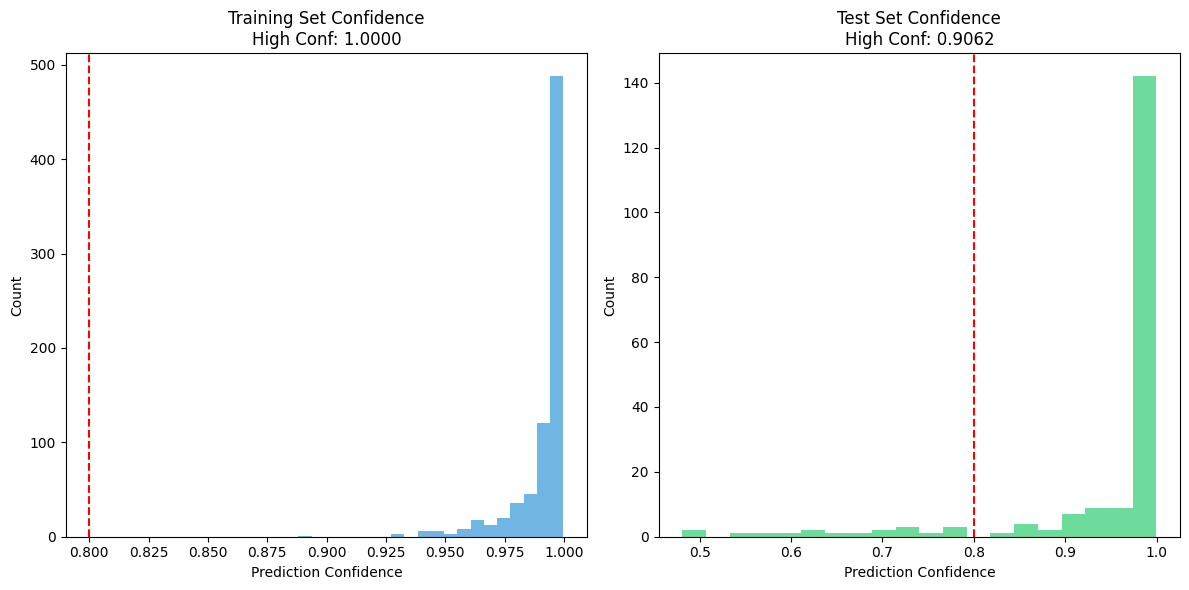

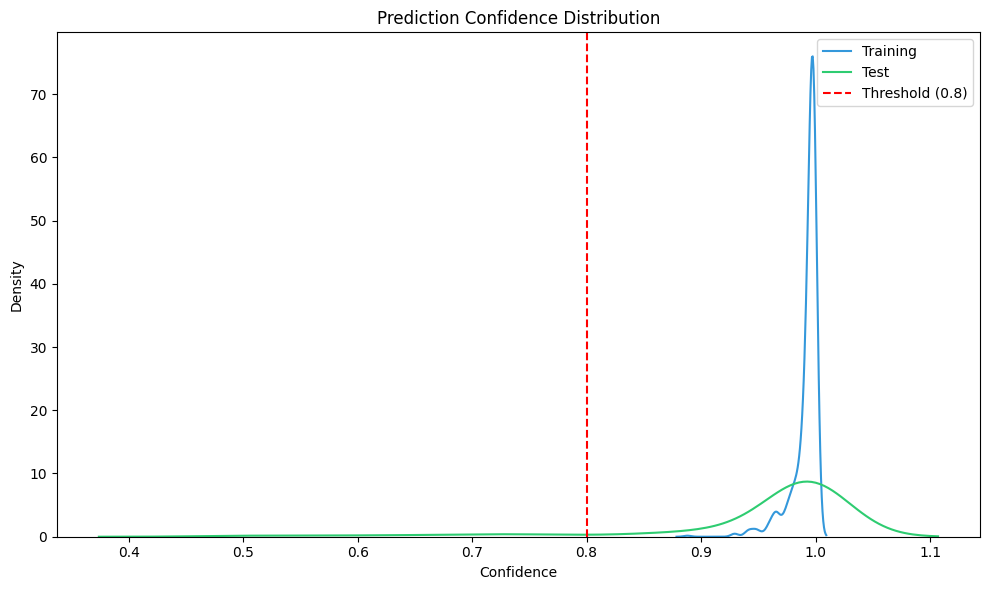


6. TREE-BASED PARAMETER ANALYSIS
Current parameters: n_estimators=200, max_depth=7, learning_rate=0.1

Analyzing effect of n_estimators (number of trees):
n_estimators Train Acc    Test Acc     Gap        Status    
--------------------------------------------------------
10           0.9583       0.8906       0.0677    ✅ OK
50           1.0000       0.9375       0.0625    ✅ OK
100          1.0000       0.9271       0.0729    ✅ OK
200          1.0000       0.9375       0.0625    ✅ OK
500          1.0000       0.9323       0.0677    ✅ OK

Analyzing effect of max_depth:
max_depth    Train Acc    Test Acc     Gap        Status    
--------------------------------------------------------
3            0.9974       0.9115       0.0859    ✅ OK
5            1.0000       0.9531       0.0469    ✅ OK
7            1.0000       0.9375       0.0625    ✅ OK
10           1.0000       0.9323       0.0677    ✅ OK
15           1.0000       0.9323       0.0677    ✅ OK


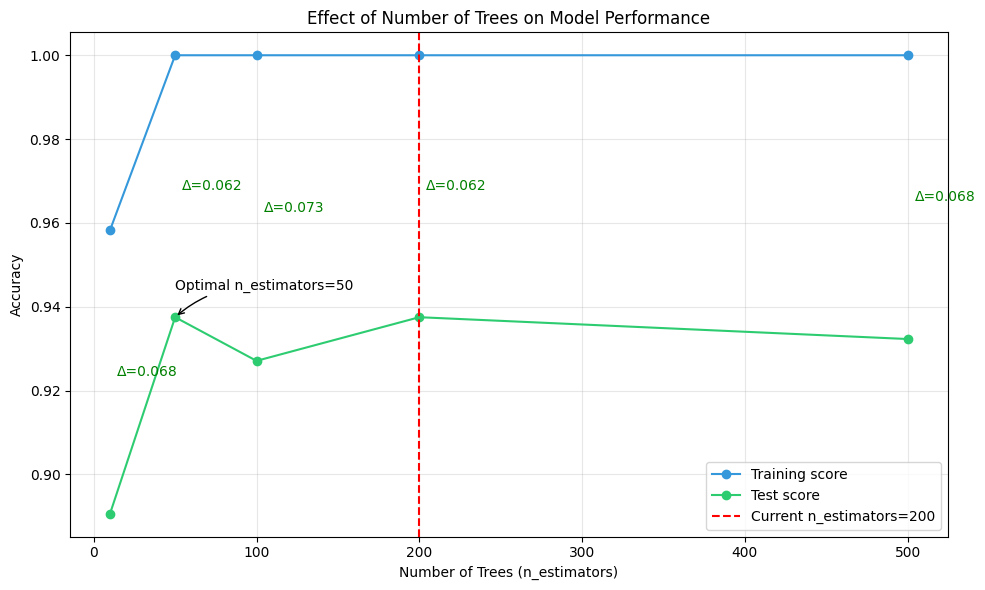

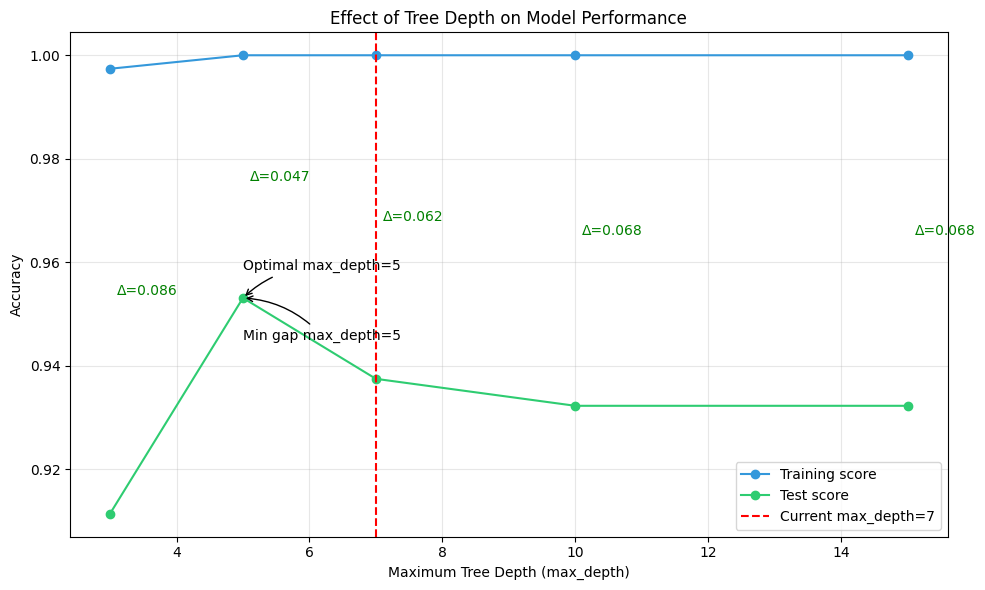


Parameter recommendations:

n_estimators (number of trees):
- Optimal for test accuracy: 50
  Train accuracy: 1.0000, Test accuracy: 0.9375, Gap: 0.0625

max_depth:
- Minimum gap (best generalization): 5
  Train accuracy: 1.0000, Test accuracy: 0.9531, Gap: 0.0469
- Optimal for test accuracy: 5
  Train accuracy: 1.0000, Test accuracy: 0.9531, Gap: 0.0469

Current model configuration:
- n_estimators: 200
- max_depth: 7
  Current train accuracy: 1.0000, test accuracy: 0.9375

⚠️ Recommendations for parameter adjustments:
- decrease n_estimators from 200 to 50 for better test accuracy
- Change max_depth from 7 to 5 for both better generalization and test accuracy

7. CROSS-VALIDATION STABILITY ASSESSMENT
Cross-validation scores: [0.921875   0.95833333 0.953125   0.92708333 0.95811518]
Mean accuracy: 0.9437
Standard deviation: 0.0159
Range: 0.0365
Minimum: 0.9219
Maximum: 0.9583
Coefficient of variation: 0.0168

Detailed Fold-by-Fold Analysis:
Fold   Accuracy   Precision  Recall     F1   

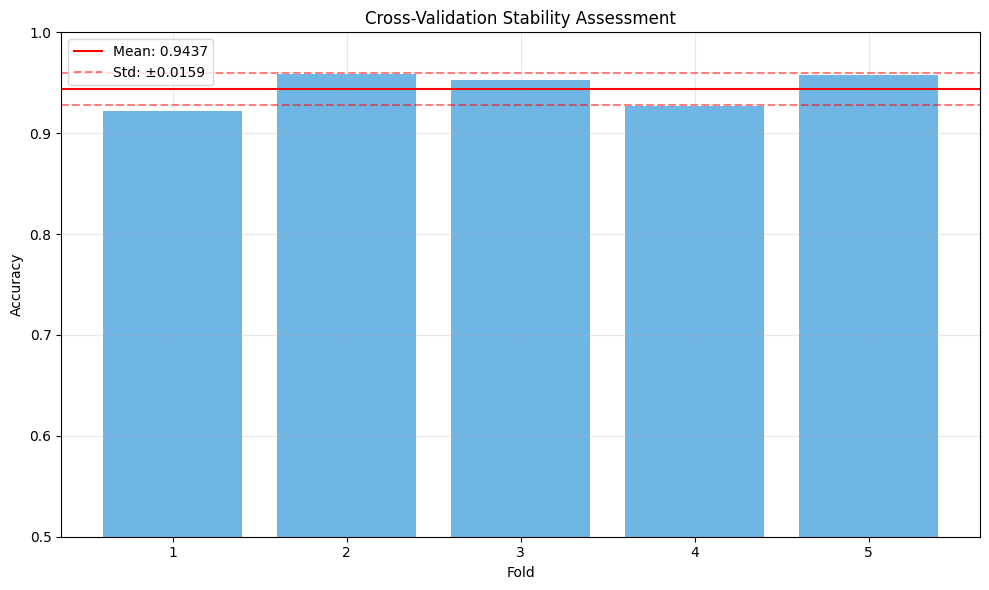

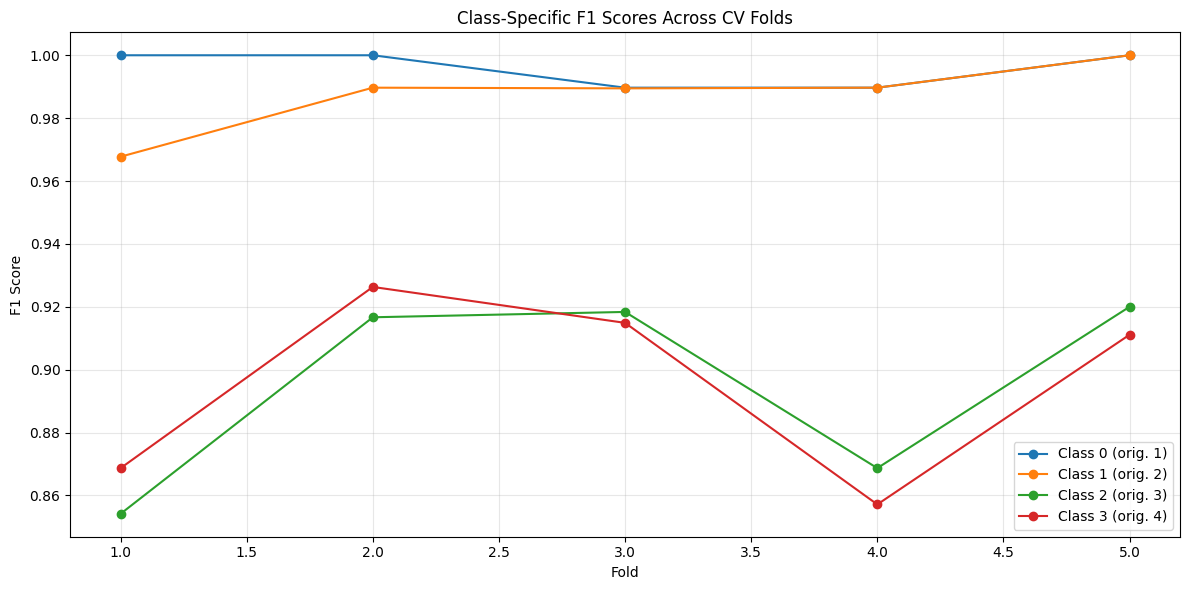


8. FEATURE IMPORTANCE ANALYSIS

Top 15 Important Features:
                                         Feature  Importance
0                     num__DaysLateLast30_MinMax    0.352353
1                   num__EngagementSurvey_Scaled    0.122912
7                  num__EmploymentStatus_Encoded    0.086063
5                    num__EmpSatisfaction_Scaled    0.082905
10        num__Position_Production Technician II    0.060306
12  cat__RaceDesc_Black or African American_True    0.052726
9          num__Position_Production Technician I    0.044067
4                             num__Salary_Scaled    0.034600
11                 cat__MaritalDesc_Married_True    0.033287
8                               num__Sex_Encoded    0.030429
6                                num__Age_Scaled    0.029690
2                       num__Tenure_Years_Scaled    0.020691
14          cat__RecruitmentSource_LinkedIn_True    0.019260
3                           num__Absences_MinMax    0.018777
13                  cat__

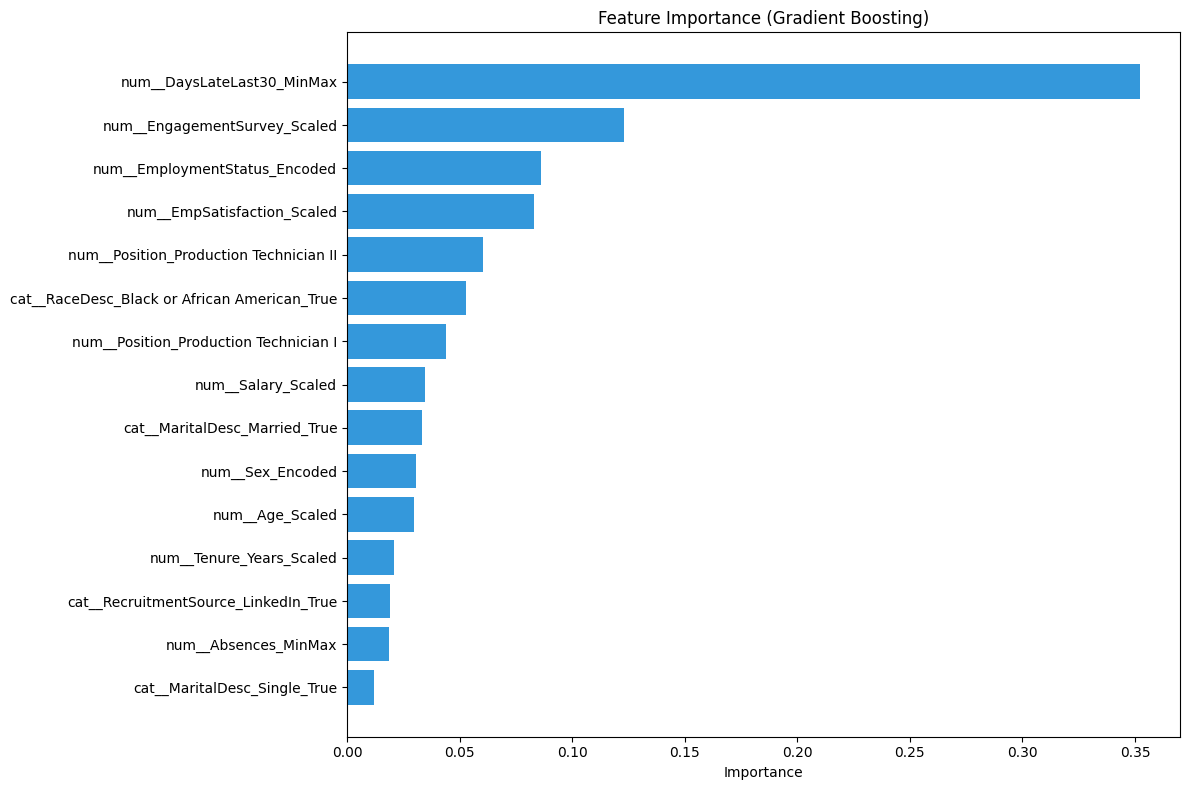

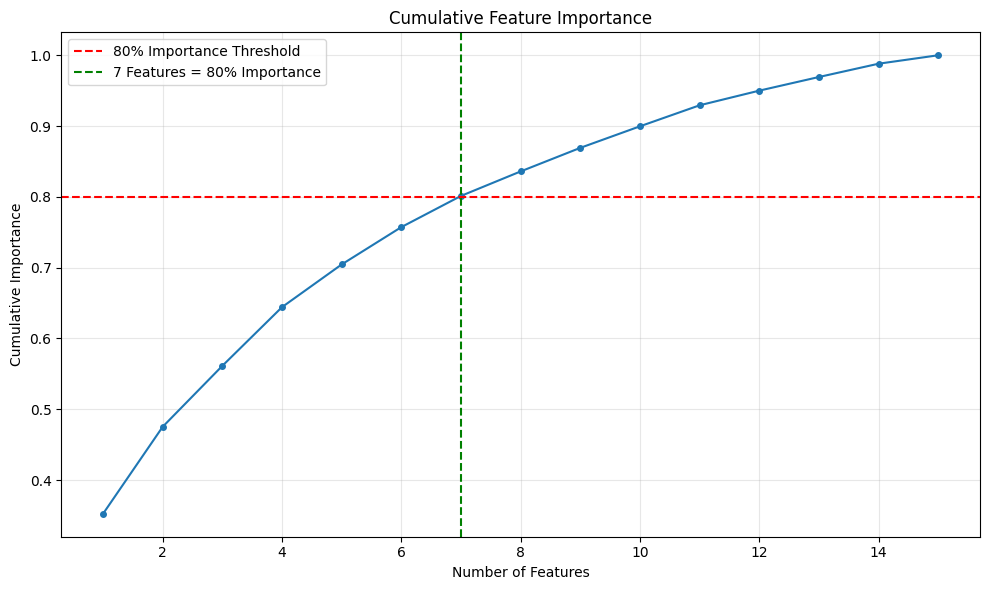


GRADIENT BOOSTING OVERFITTING ANALYSIS SUMMARY

Overfitting Indicators:
----------------------------------------------------------------------
Indicator                 Value      Status     Interpretation           
----------------------------------------------------------------------
Accuracy Gap              0.0677     ✅ OK       Acceptable gap           
Learning Curve Gap        0.1407     ⚠️ ISSUE   Poor generalization      
AUC Gap                   0.0094     ✅ OK       Consistent ranking       
Confidence Gap            0.0938     ✅ OK       Well-calibrated          
Cross-validation Stability 0.0159     ✅ OK       Stable performance       
----------------------------------------------------------------------

Class-specific overfitting detected in: [np.int64(3), np.int64(4)] (0-based: [np.int64(2), np.int64(3)])

⚠️ OVERALL ASSESSMENT: Slight overfitting detected
The model shows a minor sign of overfitting but is generally acceptable.
The main concern is in the Learning Cu

In [ ]:
# Overfitting Detection for Gradient Boosting Employee Model
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import learning_curve, StratifiedKFold, cross_val_score
from sklearn.metrics import (
    accuracy_score, roc_curve, auc, precision_recall_fscore_support,
    roc_auc_score, classification_report, confusion_matrix
)
from sklearn.preprocessing import label_binarize
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from xgboost import XGBClassifier
import pickle
import warnings
warnings.filterwarnings('ignore')

# Load the dataset
print("Loading dataset...")
df = pd.read_csv('employee_data_adasyn.csv')

# Convert string True/False to boolean for relevant columns
string_bool_columns = [col for col in df.columns if df[col].dtype == 'object' and
                       set(df[col].unique()).issubset({"True", "False"})]
for col in string_bool_columns:
    df[col] = df[col].map({"True": True, "False": False})

# Define features and target variable
X = df.drop('PerformanceScore_Encoded', axis=1)
y = df['PerformanceScore_Encoded'] - 1  # Convert to 0-based for XGBoost

print("Loading model...")
# Load the trained model - update the path to your saved model
model_path = 'gb_employee_model.pkl'
with open(model_path, 'rb') as file:
    best_model = pickle.load(file)

print("\nModel loaded successfully!")
print(f"Model type: {type(best_model)}")
print(f"Pipeline steps: {best_model.named_steps.keys()}")

# Get XGBoost parameters
xgb_params = best_model.named_steps['classifier'].get_params()
print(f"n_estimators: {xgb_params['n_estimators']}")
print(f"learning_rate: {xgb_params['learning_rate']}")
print(f"max_depth: {xgb_params['max_depth']}")
print(f"subsample: {xgb_params['subsample']}")
print(f"colsample_bytree: {xgb_params['colsample_bytree']}")

# Get the original data split that was used for training
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training set size: {X_train.shape[0]} samples, {X_train.shape[1]} features")
print(f"Test set size: {X_test.shape[0]} samples, {X_test.shape[1]} features")

# Print class distribution
train_class_dist = pd.Series(y_train).value_counts(normalize=True)
test_class_dist = pd.Series(y_test).value_counts(normalize=True)
print("\nClass distribution:")
print("Training set:")
for cls, pct in train_class_dist.items():
    print(f"  Class {cls} (original {cls+1}): {pct:.2%} ({sum(y_train == cls)} samples)")
print("Test set:")
for cls, pct in test_class_dist.items():
    print(f"  Class {cls} (original {cls+1}): {pct:.2%} ({sum(y_test == cls)} samples)")

# ========================= 1. Comparing Metrics on Training and Test Sets =========================
def check_accuracy_gap():
    # Get predictions on training and test sets
    y_train_pred = best_model.predict(X_train)
    y_test_pred = best_model.predict(X_test)

    # Calculate accuracies
    train_accuracy = accuracy_score(y_train, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    accuracy_gap = train_accuracy - test_accuracy

    print("\n1. ACCURACY GAP ANALYSIS")
    print(f"Training Accuracy: {train_accuracy:.4f}")
    print(f"Test Accuracy: {test_accuracy:.4f}")
    print(f"Accuracy Gap (Δ): {accuracy_gap:.4f}")

    # More detailed analysis
    print("\nDetailed Per-Class Accuracy Analysis:")
    classes = sorted(np.unique(y))

    print(f"{'Class':<10} {'Original':<10} {'Train Acc':<10} {'Test Acc':<10} {'Gap':<10} {'Status':<10}")
    print("-" * 60)

    for cls in classes:
        # Calculate per-class accuracy
        train_cls_acc = accuracy_score(y_train[y_train == cls], y_train_pred[y_train == cls])
        test_cls_acc = accuracy_score(y_test[y_test == cls], y_test_pred[y_test == cls])
        cls_gap = train_cls_acc - test_cls_acc

        status = "⚠️ Issue" if cls_gap > 0.1 else "✅ OK"
        print(f"{cls:<10} {cls+1:<10} {train_cls_acc:.4f}     {test_cls_acc:.4f}     {cls_gap:.4f}     {status}")

    # Add confusion matrices
    print("\nTraining Set Confusion Matrix:")
    train_cm = confusion_matrix(y_train, y_train_pred)
    print(pd.DataFrame(train_cm, index=classes, columns=classes))

    print("\nTest Set Confusion Matrix:")
    test_cm = confusion_matrix(y_test, y_test_pred)
    print(pd.DataFrame(test_cm, index=classes, columns=classes))

    if accuracy_gap > 0.1:
        print("\n⚠️ Potential overfitting detected! (Δ > 0.1)")
        print(f"   The model performs {accuracy_gap:.2%} better on training data compared to test data.")
        print("   This suggests the model may have learned noise or patterns specific to the training data.")
    else:
        print("\n✅ No significant overfitting detected based on accuracy gap (Δ ≤ 0.1)")
        print(f"   The gap of {accuracy_gap:.2%} is within acceptable limits for generalization.")

    # Visualization of accuracy comparison
    plt.figure(figsize=(8, 6))
    bars = plt.bar(['Training', 'Test'], [train_accuracy, test_accuracy], color=['#3498db', '#2ecc71'])
    plt.ylim(0, 1.1)
    plt.ylabel('Accuracy')
    plt.title('Accuracy Comparison: Training vs Test')

    # Add text labels above bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.4f}', ha='center', va='bottom')

    # Add a horizontal line for the threshold
    plt.axhline(y=train_accuracy - 0.1, color='r', linestyle='--', alpha=0.5)
    plt.text(1.05, train_accuracy - 0.1, 'Threshold (Δ = 0.1)', color='r', va='center')

    plt.tight_layout()
    plt.show()

    return train_accuracy, test_accuracy, accuracy_gap

# ========================= 2. Learning Curves Analysis =========================
def plot_learning_curves():
    print("\n2. LEARNING CURVES ANALYSIS")

    # Get the pipeline steps from the model
    preprocessor = best_model.named_steps['preprocessor']
    classifier = best_model.named_steps['classifier']

    # Create a new pipeline for learning curve evaluation
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', classifier)
    ])

    # Calculate learning curves
    train_sizes = np.linspace(0.1, 1.0, 10)
    train_sizes, train_scores, val_scores = learning_curve(
        pipeline, X, y, train_sizes=train_sizes, cv=5, scoring='accuracy', random_state=42, n_jobs=-1
    )

    # Calculate mean and standard deviation for training set scores
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)

    # Calculate mean and standard deviation for validation set scores
    val_mean = np.mean(val_scores, axis=1)
    val_std = np.std(val_scores, axis=1)

    # Calculate the gap between training and validation curves
    gap = train_mean - val_mean

    # Use np.nanmean to handle potential NaN values
    avg_gap = np.nanmean(gap)

    # Handle the case where avg_gap is still NaN
    if np.isnan(avg_gap):
        print("Warning: NaN values detected in gap calculation")
        # Filter out NaN values for a more robust calculation
        valid_gaps = gap[~np.isnan(gap)]
        if len(valid_gaps) > 0:
            avg_gap = np.mean(valid_gaps)
            print(f"Recalculated average gap using {len(valid_gaps)} valid values: {avg_gap:.4f}")
        else:
            avg_gap = 0.0
            print("Unable to calculate average gap, setting to 0.0")

    # Determine if the curves are converging
    if not np.isnan(gap[0]) and not np.isnan(gap[-1]):
        converging = gap[-1] < gap[0]
    else:
        converging = False
        print("Warning: Unable to determine convergence due to NaN values")

    # Determine if curves are stable (low standard deviation in later points)
    late_std_train = np.mean(train_std[-3:])
    late_std_val = np.mean(val_std[-3:])
    stable = late_std_train < 0.03 and late_std_val < 0.03

    print(f"Average gap between training and validation: {avg_gap:.4f}")
    print(f"Are curves converging? {'Yes' if converging else 'No'}")
    print(f"Are curves stable? {'Yes' if stable else 'No'}")

    # Print detailed data for each point on the learning curve
    print("\nDetailed Learning Curve Data:")
    print(f"{'Training Size':<15} {'Train Score':<15} {'Train Std':<15} {'Val Score':<15} {'Val Std':<15} {'Gap':<15}")
    print("-" * 90)

    for i, size in enumerate(train_sizes):
        gap_value = gap[i] if not np.isnan(gap[i]) else "NaN"
        gap_str = f"{gap_value:.4f}" if not isinstance(gap_value, str) else gap_value
        print(f"{int(size * X_train.shape[0]):<15} {train_mean[i]:.4f}         {train_std[i]:.4f}         {val_mean[i]:.4f}         {val_std[i]:.4f}         {gap_str}")

    # Additional insights about what the curves indicate
    print("\nLearning Curve Interpretation:")
    if train_mean[-1] > 0.9 and avg_gap > 0.1:
        print("- High training score with significant gap indicates overfitting")
    elif train_mean[-1] < 0.8 and avg_gap < 0.05:
        print("- Low scores on both curves with small gap suggests underfitting")
    elif converging and stable:
        print("- Converging and stable curves indicate good generalization")

    if not np.isnan(gap[0]) and not np.isnan(gap[-1]):
        print(f"- Starting gap (with {int(train_sizes[0] * X_train.shape[0])} samples): {gap[0]:.4f}")
        print(f"- Ending gap (with {int(train_sizes[-1] * X_train.shape[0])} samples): {gap[-1]:.4f}")

    if avg_gap > 0.1:
        print("\n⚠️ Potential overfitting detected! (avg gap > 0.1)")
        print("   The persistent gap between training and validation scores suggests")
        print("   the model is not generalizing well to unseen data.")
    else:
        print("\n✅ No significant overfitting detected based on learning curves (avg gap ≤ 0.1)")
        print("   The model seems to generalize well as the gap is acceptable.")

    # Plot learning curves
    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_mean, 'o-', color='#3498db', label='Training score')
    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color='#3498db')

    plt.plot(train_sizes, val_mean, 'o-', color='#2ecc71', label='Cross-validation score')
    plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.1, color='#2ecc71')

    plt.title('Learning Curves for Gradient Boosting Model')
    plt.xlabel('Training Examples')
    plt.ylabel('Accuracy Score')
    plt.grid(True)
    plt.legend(loc='best')

    # Add annotation for the gap with proper formatting
    plt.annotate(f'Avg Gap: {avg_gap:.4f}',
                xy=(0.5, 0.5), xycoords='axes fraction',
                bbox=dict(boxstyle="round,pad=0.3", fc="#f8f9fa", ec="#343a40", alpha=0.8))

    plt.tight_layout()
    plt.show()

    return avg_gap, converging, stable

# ========================= 3. ROC Analysis and AUC Comparison =========================
def perform_roc_analysis():
    print("\n3. ROC ANALYSIS AND AUC COMPARISON")

    # Get the number of classes
    n_classes = len(np.unique(y))

    # Binarize the output for multi-class ROC analysis
    y_train_bin = label_binarize(y_train, classes=sorted(np.unique(y)))
    y_test_bin = label_binarize(y_test, classes=sorted(np.unique(y)))

    # Get probability predictions
    y_train_score = best_model.predict_proba(X_train)
    y_test_score = best_model.predict_proba(X_test)

    # Calculate ROC curve and AUC for each class
    fpr_train = dict()
    tpr_train = dict()
    roc_auc_train = dict()

    fpr_test = dict()
    tpr_test = dict()
    roc_auc_test = dict()

    # Store optimal thresholds
    optimal_thresholds_train = dict()
    optimal_thresholds_test = dict()

    for i in range(n_classes):
        fpr_train[i], tpr_train[i], thresholds_train = roc_curve(y_train_bin[:, i], y_train_score[:, i])
        roc_auc_train[i] = auc(fpr_train[i], tpr_train[i])

        # Find optimal threshold (closest to top-left corner)
        optimal_idx_train = np.argmax(tpr_train[i] - fpr_train[i])
        optimal_thresholds_train[i] = thresholds_train[optimal_idx_train]

        fpr_test[i], tpr_test[i], thresholds_test = roc_curve(y_test_bin[:, i], y_test_score[:, i])
        roc_auc_test[i] = auc(fpr_test[i], tpr_test[i])

        # Find optimal threshold (closest to top-left corner)
        optimal_idx_test = np.argmax(tpr_test[i] - fpr_test[i])
        optimal_thresholds_test[i] = thresholds_test[optimal_idx_test]

    # Calculate macro-average AUC
    macro_auc_train = np.mean([roc_auc_train[i] for i in range(n_classes)])
    macro_auc_test = np.mean([roc_auc_test[i] for i in range(n_classes)])
    auc_gap = macro_auc_train - macro_auc_test

    print(f"Training Set Macro-AUC: {macro_auc_train:.4f}")
    print(f"Test Set Macro-AUC: {macro_auc_test:.4f}")
    print(f"AUC Gap (Δ): {auc_gap:.4f}")

    # Detailed class-specific ROC analysis
    print("\nDetailed Class-Specific ROC Analysis:")
    print(f"{'Class':<10} {'Original':<10} {'Train AUC':<12} {'Test AUC':<12} {'AUC Gap':<12} {'Status':<10}")
    print("-" * 70)

    for i in range(n_classes):
        class_gap = roc_auc_train[i] - roc_auc_test[i]
        status = "⚠️ Issue" if class_gap > 0.05 else "✅ OK"

        print(f"{i:<10} {i+1:<10} {roc_auc_train[i]:.4f}      {roc_auc_test[i]:.4f}      {class_gap:.4f}      {status}")

    # Calculate and print optimal sensitivity, specificity at chosen threshold
    print("\nOptimal Operating Points (Test Set):")
    for i in range(n_classes):
        # We need to use the class-specific thresholds
        # The optimal index was already found when calculating optimal_thresholds_test
        optimal_idx_test = np.argmax(tpr_test[i] - fpr_test[i])
        sensitivity = tpr_test[i][optimal_idx_test]
        specificity = 1 - fpr_test[i][optimal_idx_test]

        print(f"Class {i} (original {i+1}): Threshold={optimal_thresholds_test[i]:.4f}, Sensitivity={sensitivity:.4f}, Specificity={specificity:.4f}")

    # Interpretation of results
    if auc_gap > 0.05:
        print("\n⚠️ Potential overfitting detected! (ΔAUC > 0.05)")
        print(f"   The model's discriminative ability is {auc_gap:.2%} better on training data")
        print("   compared to test data, suggesting it's learning patterns specific to the training set.")
    else:
        print("\n✅ No significant overfitting detected based on AUC gap (ΔAUC ≤ 0.05)")
        print(f"   The AUC gap of {auc_gap:.2%} suggests good generalization of the model's discriminative ability.")

    # Plot ROC curves
    plt.figure(figsize=(12, 8))

    # Plot macro-average ROC curve for training
    plt.plot([0, 1], [0, 1], 'k--', lw=2)

    # Plot class-specific ROC curves
    colors = plt.cm.tab10(np.linspace(0, 1, n_classes))

    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr_train[i], tpr_train[i], color=color, lw=2, linestyle='-',
                 label=f'Train ROC class {i} (orig. {i+1}) (AUC = {roc_auc_train[i]:.3f})')

        plt.plot(fpr_test[i], tpr_test[i], color=color, lw=2, linestyle='--',
                 label=f'Test ROC class {i} (orig. {i+1}) (AUC = {roc_auc_test[i]:.3f})')

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves for Training and Test Sets')
    plt.legend(loc="lower right")

    # Add annotation for the gap
    plt.annotate(f'Macro AUC Gap: {auc_gap:.4f}',
                xy=(0.5, 0.2), xycoords='axes fraction',
                bbox=dict(boxstyle="round,pad=0.3", fc="#f8f9fa", ec="#343a40", alpha=0.8))

    plt.tight_layout()
    plt.show()

    # Bar chart comparing class-specific AUCs
    plt.figure(figsize=(10, 6))

    class_labels = [f'Class {i} (orig. {i+1})' for i in range(n_classes)]
    x = np.arange(len(class_labels))
    width = 0.35

    train_aucs = [roc_auc_train[i] for i in range(n_classes)]
    test_aucs = [roc_auc_test[i] for i in range(n_classes)]

    fig, ax = plt.subplots(figsize=(12, 6))
    bars1 = ax.bar(x - width/2, train_aucs, width, label='Training', color='#3498db')
    bars2 = ax.bar(x + width/2, test_aucs, width, label='Test', color='#2ecc71')

    ax.set_ylim(0, 1.1)
    ax.set_ylabel('AUC')
    ax.set_title('Class-Specific AUC Comparison')
    ax.set_xticks(x)
    ax.set_xticklabels(class_labels)
    ax.legend()

    # Add AUC gap annotations
    for i in range(n_classes):
        gap = train_aucs[i] - test_aucs[i]
        ax.annotate(f'Δ={gap:.3f}',
                   xy=(i, max(train_aucs[i], test_aucs[i]) + 0.05),
                   ha='center', va='bottom',
                   color='red' if gap > 0.05 else 'green')

    plt.tight_layout()
    plt.show()

    return macro_auc_train, macro_auc_test, auc_gap

# ========================= 4. Class-Specific Metrics Analysis =========================
def analyze_class_metrics():
    print("\n4. CLASS-SPECIFIC METRICS ANALYSIS")

    # Get predictions
    y_train_pred = best_model.predict(X_train)
    y_test_pred = best_model.predict(X_test)

    # Calculate metrics for training set
    precision_train, recall_train, f1_train, _ = precision_recall_fscore_support(y_train, y_train_pred, average=None)

    # Calculate metrics for test set
    precision_test, recall_test, f1_test, _ = precision_recall_fscore_support(y_test, y_test_pred, average=None)

    # Calculate differences
    precision_diff = precision_train - precision_test
    recall_diff = recall_train - recall_test
    f1_diff = f1_train - f1_test

    # Calculate macro and weighted averages
    train_report = classification_report(y_train, y_train_pred, output_dict=True)
    test_report = classification_report(y_test, y_test_pred, output_dict=True)

    # Check for overfitting in each class
    classes = sorted(np.unique(y))

    # Print class-specific metrics with more details
    print("\nDetailed Class-specific Metrics:")
    print(f"{'Class':<10} {'Original':<10} {'Metric':<10} {'Train':<10} {'Test':<10} {'Diff':<10} {'Status':<10}")
    print("-" * 70)

    # Define a function to determine metric status
    def get_status(diff, threshold=0.1):
        if diff > threshold:
            return "⚠️ Issue"
        elif diff < -threshold:
            return "⚠️ Lower"
        else:
            return "✅ OK"

    # Track problematic classes
    overfit_classes = []
    underperform_classes = []

    for i, cls in enumerate(classes):
        # Check precision
        p_status = get_status(precision_diff[i])
        print(f"{cls:<10} {cls+1:<10} {'Precision':<10} {precision_train[i]:.4f}    {precision_test[i]:.4f}    {precision_diff[i]:.4f}    {p_status}")

        # Check recall
        r_status = get_status(recall_diff[i])
        print(f"{'':<10} {'':<10} {'Recall':<10} {recall_train[i]:.4f}    {recall_test[i]:.4f}    {recall_diff[i]:.4f}    {r_status}")

        # Check F1
        f1_status = get_status(f1_diff[i])
        print(f"{'':<10} {'':<10} {'F1-Score':<10} {f1_train[i]:.4f}    {f1_test[i]:.4f}    {f1_diff[i]:.4f}    {f1_status}")

        # Add separator between classes
        if i < len(classes) - 1:
            print("-" * 70)

        # Track if class has overfitting issues
        if abs(precision_diff[i]) > 0.1 or abs(recall_diff[i]) > 0.1 or abs(f1_diff[i]) > 0.1:
            if precision_diff[i] > 0.1 or recall_diff[i] > 0.1 or f1_diff[i] > 0.1:
                overfit_classes.append(cls)
            else:
                underperform_classes.append(cls)

    # Print aggregated metrics
    print("\nAggregated Metrics:")
    print(f"{'Average':<10} {'Metric':<10} {'Train':<10} {'Test':<10} {'Diff':<10} {'Status':<10}")
    print("-" * 60)

    # Macro averages
    macro_precision_diff = train_report['macro avg']['precision'] - test_report['macro avg']['precision']
    macro_recall_diff = train_report['macro avg']['recall'] - test_report['macro avg']['recall']
    macro_f1_diff = train_report['macro avg']['f1-score'] - test_report['macro avg']['f1-score']

    print(f"{'Macro':<10} {'Precision':<10} {train_report['macro avg']['precision']:.4f}    {test_report['macro avg']['precision']:.4f}    {macro_precision_diff:.4f}    {get_status(macro_precision_diff)}")
    print(f"{'':<10} {'Recall':<10} {train_report['macro avg']['recall']:.4f}    {test_report['macro avg']['recall']:.4f}    {macro_recall_diff:.4f}    {get_status(macro_recall_diff)}")
    print(f"{'':<10} {'F1-Score':<10} {train_report['macro avg']['f1-score']:.4f}    {test_report['macro avg']['f1-score']:.4f}    {macro_f1_diff:.4f}    {get_status(macro_f1_diff)}")

    # Weighted averages
    weighted_precision_diff = train_report['weighted avg']['precision'] - test_report['weighted avg']['precision']
    weighted_recall_diff = train_report['weighted avg']['recall'] - test_report['weighted avg']['recall']
    weighted_f1_diff = train_report['weighted avg']['f1-score'] - test_report['weighted avg']['f1-score']

    print("-" * 60)
    print(f"{'Weighted':<10} {'Precision':<10} {train_report['weighted avg']['precision']:.4f}    {test_report['weighted avg']['precision']:.4f}    {weighted_precision_diff:.4f}    {get_status(weighted_precision_diff)}")
    print(f"{'':<10} {'Recall':<10} {train_report['weighted avg']['recall']:.4f}    {test_report['weighted avg']['recall']:.4f}    {weighted_recall_diff:.4f}    {get_status(weighted_recall_diff)}")
    print(f"{'':<10} {'F1-Score':<10} {train_report['weighted avg']['f1-score']:.4f}    {test_report['weighted avg']['f1-score']:.4f}    {weighted_f1_diff:.4f}    {get_status(weighted_f1_diff)}")

    # Summary of findings
    if overfit_classes:
        print(f"\n⚠️ Potential class-specific overfitting detected in classes: {[c+1 for c in overfit_classes]} (0-based: {overfit_classes})")
        print("   This indicates the model has learned patterns specific to these classes in the training data")
        print("   that do not generalize well to the test set.")

    if underperform_classes:
        print(f"\n⚠️ Classes performing better on test than training: {[c+1 for c in underperform_classes]} (0-based: {underperform_classes})")
        print("   This unusual pattern could indicate sampling issues, data leakage, or class imbalance problems.")

    if not overfit_classes and not underperform_classes:
        print("\n✅ No significant class-specific overfitting detected")
        print("   All classes show consistent performance between training and test sets.")

    # Create a heatmap of metric differences
    metrics_diff = pd.DataFrame({
        'Class': [f"{c} (orig. {c+1})" for c in classes],
        'Precision Δ': precision_diff,
        'Recall Δ': recall_diff,
        'F1 Δ': f1_diff
    })

    metrics_diff_pivot = metrics_diff.melt(id_vars=['Class'], var_name='Metric', value_name='Difference')
    pivot_table = metrics_diff_pivot.pivot(index='Class', columns='Metric', values='Difference')

    plt.figure(figsize=(10, 6))
    sns.heatmap(pivot_table, annot=True, cmap='RdBu_r', center=0, fmt='.3f', cbar_kws={'label': 'Difference (Train - Test)'})
    plt.title('Class-Specific Metrics Differences (Training - Test)')
    plt.tight_layout()
    plt.show()

    return metrics_diff, overfit_classes, underperform_classes

# ========================= 5. Prediction Confidence Analysis =========================
def analyze_prediction_confidence():
    print("\n5. PREDICTION CONFIDENCE ANALYSIS")

    # Get probability predictions
    y_train_proba = best_model.predict_proba(X_train)
    y_test_proba = best_model.predict_proba(X_test)

    # Get the max probability for each prediction (confidence)
    train_confidence = np.max(y_train_proba, axis=1)
    test_confidence = np.max(y_test_proba, axis=1)

    # Basic statistics
    print("\nConfidence Statistics:")
    print(f"{'Statistic':<15} {'Training':<15} {'Test':<15} {'Difference':<15}")
    print("-" * 60)

    # Mean confidence
    mean_train_conf = np.mean(train_confidence)
    mean_test_conf = np.mean(test_confidence)
    print(f"{'Mean':<15} {mean_train_conf:.4f}        {mean_test_conf:.4f}        {mean_train_conf - mean_test_conf:.4f}")

    # Median confidence
    median_train_conf = np.median(train_confidence)
    median_test_conf = np.median(test_confidence)
    print(f"{'Median':<15} {median_train_conf:.4f}        {median_test_conf:.4f}        {median_train_conf - median_test_conf:.4f}")

    # Min confidence
    min_train_conf = np.min(train_confidence)
    min_test_conf = np.min(test_confidence)
    print(f"{'Min':<15} {min_train_conf:.4f}        {min_test_conf:.4f}        {min_train_conf - min_test_conf:.4f}")

    # Max confidence
    max_train_conf = np.max(train_confidence)
    max_test_conf = np.max(test_confidence)
    print(f"{'Max':<15} {max_train_conf:.4f}        {max_test_conf:.4f}        {max_train_conf - max_test_conf:.4f}")

    # Standard deviation
    std_train_conf = np.std(train_confidence)
    std_test_conf = np.std(test_confidence)
    print(f"{'Std Dev':<15} {std_train_conf:.4f}        {std_test_conf:.4f}        {std_train_conf - std_test_conf:.4f}")

    # Calculate confidence thresholds
    thresholds = [0.5, 0.6, 0.7, 0.8, 0.9, 0.95]

    print("\nConfidence Distribution by Threshold:")
    print(f"{'Threshold':<10} {'Training %':<15} {'Test %':<15} {'Difference':<15} {'Status':<10}")
    print("-" * 65)

    for threshold in thresholds:
        train_above = np.mean(train_confidence >= threshold)
        test_above = np.mean(test_confidence >= threshold)
        diff = train_above - test_above

        status = "⚠️ Issue" if diff > 0.1 else "✅ OK"

        print(f"≥ {threshold:<8} {train_above:.2%}         {test_above:.2%}         {diff:.2%}           {status}")

    # Calculate high confidence proportions
    high_conf_threshold = 0.8
    train_high_conf = np.mean(train_confidence >= high_conf_threshold)
    test_high_conf = np.mean(test_confidence >= high_conf_threshold)

    # Class-specific confidence analysis
    classes = sorted(np.unique(y))

    print("\nClass-Specific Confidence Analysis:")
    print(f"{'Class':<10} {'Original':<10} {'Train Mean':<15} {'Test Mean':<15} {'Difference':<15} {'Status':<10}")
    print("-" * 75)

    for cls in classes:
        # Get indices for this class
        train_cls_idx = (y_train == cls)
        test_cls_idx = (y_test == cls)

        # Calculate mean confidence for the class
        train_cls_conf = np.mean(train_confidence[train_cls_idx])
        test_cls_conf = np.mean(test_confidence[test_cls_idx])
        diff = train_cls_conf - test_cls_conf

        status = "⚠️ Issue" if diff > 0.1 else "✅ OK"

        print(f"{cls:<10} {cls+1:<10} {train_cls_conf:.4f}        {test_cls_conf:.4f}        {diff:.4f}          {status}")

    # Decision quality analysis
    train_pred = best_model.predict(X_train)
    test_pred = best_model.predict(X_test)

    # Correct prediction confidence
    train_correct = (train_pred == y_train)
    test_correct = (test_pred == y_test)

    # Mean confidence for correct and incorrect predictions
    train_correct_conf = np.mean(train_confidence[train_correct])
    train_incorrect_conf = np.mean(train_confidence[~train_correct])
    test_correct_conf = np.mean(test_confidence[test_correct])
    test_incorrect_conf = np.mean(test_confidence[~test_correct])

    print("\nConfidence for Correct vs Incorrect Predictions:")
    print(f"{'Prediction':<12} {'Training':<15} {'Test':<15} {'Difference':<15}")
    print("-" * 57)
    print(f"{'Correct':<12} {train_correct_conf:.4f}        {test_correct_conf:.4f}        {train_correct_conf - test_correct_conf:.4f}")
    print(f"{'Incorrect':<12} {train_incorrect_conf:.4f}        {test_incorrect_conf:.4f}        {train_incorrect_conf - test_incorrect_conf:.4f}")
    print(f"{'Difference':<12} {train_correct_conf - train_incorrect_conf:.4f}        {test_correct_conf - test_incorrect_conf:.4f}")

    # Overall confidence gap assessment
    conf_gap = train_high_conf - test_high_conf

    if conf_gap > 0.1:
        print("\n⚠️ Potential overfitting detected! (confidence gap > 0.1)")
        print(f"   The model is {conf_gap:.2%} more confident on training data than test data,")
        print("   suggesting it may be too certain about patterns specific to the training set.")
    else:
        print("\n✅ No significant overfitting detected based on prediction confidence")
        print(f"   The confidence gap of {conf_gap:.2%} is within acceptable limits.")

    # Plot confidence histograms
    plt.figure(figsize=(12, 6))

    # Training set confidence histogram
    plt.subplot(1, 2, 1)
    plt.hist(train_confidence, bins=20, alpha=0.7, color='#3498db')
    plt.axvline(x=high_conf_threshold, color='r', linestyle='--')
    plt.title(f'Training Set Confidence\nHigh Conf: {train_high_conf:.4f}')
    plt.xlabel('Prediction Confidence')
    plt.ylabel('Count')

    # Test set confidence histogram
    plt.subplot(1, 2, 2)
    plt.hist(test_confidence, bins=20, alpha=0.7, color='#2ecc71')
    plt.axvline(x=high_conf_threshold, color='r', linestyle='--')
    plt.title(f'Test Set Confidence\nHigh Conf: {test_high_conf:.4f}')
    plt.xlabel('Prediction Confidence')
    plt.ylabel('Count')

    plt.tight_layout()
    plt.show()

    # Compare overall confidence distributions
    plt.figure(figsize=(10, 6))
    sns.kdeplot(train_confidence, label='Training', color='#3498db')
    sns.kdeplot(test_confidence, label='Test', color='#2ecc71')
    plt.axvline(x=high_conf_threshold, color='r', linestyle='--', label=f'Threshold ({high_conf_threshold})')
    plt.title('Prediction Confidence Distribution')
    plt.xlabel('Confidence')
    plt.ylabel('Density')
    plt.legend()
    plt.tight_layout()
    plt.show()

    return train_high_conf, test_high_conf, conf_gap

# ========================= 6. Tree-Based Parameter Analysis =========================
def analyze_tree_parameters():
    print("\n6. TREE-BASED PARAMETER ANALYSIS")

    # Identify the classifier and preprocessor from the pipeline
    preprocessor = best_model.named_steps['preprocessor']
    xgb_params = best_model.named_steps['classifier'].get_params()

    # Current parameters
    current_n_estimators = xgb_params['n_estimators']
    current_max_depth = xgb_params['max_depth']
    current_learning_rate = xgb_params['learning_rate']

    print(f"Current parameters: n_estimators={current_n_estimators}, max_depth={current_max_depth}, learning_rate={current_learning_rate}")

    # Define parameter ranges to test
    n_estimators_values = [10, 50, 100, 200, 500]
    max_depth_values = [3, 5, 7, 10, 15]

    # If current values are not in our lists, add them
    if current_n_estimators not in n_estimators_values:
        n_estimators_values.append(current_n_estimators)
        n_estimators_values.sort()

    if current_max_depth not in max_depth_values:
        max_depth_values.append(current_max_depth)
        max_depth_values.sort()

    # First, analyze n_estimators (number of trees)
    print("\nAnalyzing effect of n_estimators (number of trees):")
    print(f"{'n_estimators':<12} {'Train Acc':<12} {'Test Acc':<12} {'Gap':<10} {'Status':<10}")
    print("-" * 56)

    n_train_scores = []
    n_test_scores = []

    for n_estimators in n_estimators_values:
        # Create new classifier with current parameters but varying n_estimators
        xgb = XGBClassifier(
            n_estimators=n_estimators,
            max_depth=current_max_depth,
            learning_rate=current_learning_rate,
            random_state=42,
            eval_metric='mlogloss'
        )

        # Create pipeline with the same preprocessor
        pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('classifier', xgb)
        ])

        # Fit the model
        pipeline.fit(X_train, y_train)

        # Get scores
        train_score = pipeline.score(X_train, y_train)
        test_score = pipeline.score(X_test, y_test)
        gap = train_score - test_score

        n_train_scores.append(train_score)
        n_test_scores.append(test_score)

        # Print results
        status = "⚠️ Issue" if gap > 0.1 else "✅ OK"
        print(f"{n_estimators:<12} {train_score:.4f}       {test_score:.4f}       {gap:.4f}    {status}")

    # Next, analyze max_depth
    print("\nAnalyzing effect of max_depth:")
    print(f"{'max_depth':<12} {'Train Acc':<12} {'Test Acc':<12} {'Gap':<10} {'Status':<10}")
    print("-" * 56)

    d_train_scores = []
    d_test_scores = []

    for max_depth in max_depth_values:
        # Create new classifier with current parameters but varying max_depth
        xgb = XGBClassifier(
            n_estimators=current_n_estimators,
            max_depth=max_depth,
            learning_rate=current_learning_rate,
            random_state=42,
            eval_metric='mlogloss'
        )

        # Create pipeline with the same preprocessor
        pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('classifier', xgb)
        ])

        # Fit the model
        pipeline.fit(X_train, y_train)

        # Get scores
        train_score = pipeline.score(X_train, y_train)
        test_score = pipeline.score(X_test, y_test)
        gap = train_score - test_score

        d_train_scores.append(train_score)
        d_test_scores.append(test_score)

        # Print results
        status = "⚠️ Issue" if gap > 0.1 else "✅ OK"
        print(f"{max_depth:<12} {train_score:.4f}       {test_score:.4f}       {gap:.4f}    {status}")

    # Find optimal parameters
    n_opt_idx = np.argmax(n_test_scores)
    n_opt = n_estimators_values[n_opt_idx]

    d_min_gap_idx = np.argmin(np.array(d_train_scores) - np.array(d_test_scores))
    d_min_gap = max_depth_values[d_min_gap_idx]

    d_opt_idx = np.argmax(d_test_scores)
    d_opt = max_depth_values[d_opt_idx]

    # Plot n_estimators analysis
    plt.figure(figsize=(10, 6))
    plt.plot(n_estimators_values, n_train_scores, 'o-', color='#3498db', label='Training score')
    plt.plot(n_estimators_values, n_test_scores, 'o-', color='#2ecc71', label='Test score')

    # Mark the current value
    current_idx = n_estimators_values.index(current_n_estimators)
    plt.axvline(x=current_n_estimators, color='r', linestyle='--', label=f'Current n_estimators={current_n_estimators}')

    plt.title('Effect of Number of Trees on Model Performance')
    plt.xlabel('Number of Trees (n_estimators)')
    plt.ylabel('Accuracy')
    plt.grid(True, alpha=0.3)
    plt.legend(loc='best')

    # Add annotations
    plt.annotate(f'Optimal n_estimators={n_opt}',
                xy=(n_opt, n_test_scores[n_opt_idx]),
                xytext=(0, 20), textcoords='offset points',
                arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=.2"))

    # Add gap labels
    for i, n in enumerate(n_estimators_values):
        gap = n_train_scores[i] - n_test_scores[i]
        plt.annotate(f'Δ={gap:.3f}',
                    xy=(n, (n_train_scores[i] + n_test_scores[i])/2),
                    xytext=(5, 0), textcoords='offset points',
                    ha='left', va='center',
                    color='red' if gap > 0.1 else 'green')

    plt.tight_layout()
    plt.show()

    # Plot max_depth analysis
    plt.figure(figsize=(10, 6))
    plt.plot(max_depth_values, d_train_scores, 'o-', color='#3498db', label='Training score')
    plt.plot(max_depth_values, d_test_scores, 'o-', color='#2ecc71', label='Test score')

    # Mark the current value
    current_idx = max_depth_values.index(current_max_depth)
    plt.axvline(x=current_max_depth, color='r', linestyle='--', label=f'Current max_depth={current_max_depth}')

    plt.title('Effect of Tree Depth on Model Performance')
    plt.xlabel('Maximum Tree Depth (max_depth)')
    plt.ylabel('Accuracy')
    plt.grid(True, alpha=0.3)
    plt.legend(loc='best')

    # Add annotations
    plt.annotate(f'Min gap max_depth={d_min_gap}',
                xy=(d_min_gap, d_test_scores[d_min_gap_idx]),
                xytext=(0, -30), textcoords='offset points',
                arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=.2"))

    plt.annotate(f'Optimal max_depth={d_opt}',
                xy=(d_opt, d_test_scores[d_opt_idx]),
                xytext=(0, 20), textcoords='offset points',
                arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=.2"))

    # Add gap labels
    for i, d in enumerate(max_depth_values):
        gap = d_train_scores[i] - d_test_scores[i]
        plt.annotate(f'Δ={gap:.3f}',
                    xy=(d, (d_train_scores[i] + d_test_scores[i])/2),
                    xytext=(5, 0), textcoords='offset points',
                    ha='left', va='center',
                    color='red' if gap > 0.1 else 'green')

    plt.tight_layout()
    plt.show()

    # Recommendations
    print(f"\nParameter recommendations:")

    print("\nn_estimators (number of trees):")
    print(f"- Optimal for test accuracy: {n_opt}")
    print(f"  Train accuracy: {n_train_scores[n_opt_idx]:.4f}, Test accuracy: {n_test_scores[n_opt_idx]:.4f}, Gap: {n_train_scores[n_opt_idx] - n_test_scores[n_opt_idx]:.4f}")

    print("\nmax_depth:")
    print(f"- Minimum gap (best generalization): {d_min_gap}")
    print(f"  Train accuracy: {d_train_scores[d_min_gap_idx]:.4f}, Test accuracy: {d_test_scores[d_min_gap_idx]:.4f}, Gap: {d_train_scores[d_min_gap_idx] - d_test_scores[d_min_gap_idx]:.4f}")

    print(f"- Optimal for test accuracy: {d_opt}")
    print(f"  Train accuracy: {d_train_scores[d_opt_idx]:.4f}, Test accuracy: {d_test_scores[d_opt_idx]:.4f}, Gap: {d_train_scores[d_opt_idx] - d_test_scores[d_opt_idx]:.4f}")

    print(f"\nCurrent model configuration:")
    print(f"- n_estimators: {current_n_estimators}")
    print(f"- max_depth: {current_max_depth}")
    current_n_idx = n_estimators_values.index(current_n_estimators)
    current_d_idx = max_depth_values.index(current_max_depth)
    print(f"  Current train accuracy: {n_train_scores[current_n_idx]:.4f}, test accuracy: {n_test_scores[current_n_idx]:.4f}")

    # Print specific recommendations
    if current_n_estimators != n_opt or current_max_depth != d_opt:
        print("\n⚠️ Recommendations for parameter adjustments:")

        if current_n_estimators != n_opt:
            action = "increase" if n_opt > current_n_estimators else "decrease"
            print(f"- {action} n_estimators from {current_n_estimators} to {n_opt} for better test accuracy")

        if current_max_depth != d_min_gap and current_max_depth != d_opt:
            if d_min_gap == d_opt:
                print(f"- Change max_depth from {current_max_depth} to {d_opt} for both better generalization and test accuracy")
            else:
                print(f"- Consider changing max_depth from {current_max_depth} to either:")
                print(f"  * {d_min_gap} for best generalization (smallest gap)")
                print(f"  * {d_opt} for highest test accuracy")
    else:
        print("\n✅ Current parameters appear optimal based on this analysis")

    return n_estimators_values, n_train_scores, n_test_scores, max_depth_values, d_train_scores, d_test_scores

# ========================= 7. Cross-Validation Stability Assessment =========================
def assess_cv_stability():
    print("\n7. CROSS-VALIDATION STABILITY ASSESSMENT")

    # Define cross-validation
    n_splits = 5
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    # Get the classifier and preprocessor from the pipeline
    classifier = best_model.named_steps['classifier']
    preprocessor = best_model.named_steps['preprocessor']

    # Create a new pipeline for cross-validation
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', classifier)
    ])

    # Perform cross-validation for accuracy
    cv_scores = cross_val_score(pipeline, X, y, cv=cv, scoring='accuracy')

    # Calculate stability metrics
    cv_mean = np.mean(cv_scores)
    cv_std = np.std(cv_scores)
    cv_range = np.max(cv_scores) - np.min(cv_scores)
    cv_min = np.min(cv_scores)
    cv_max = np.max(cv_scores)

    print(f"Cross-validation scores: {cv_scores}")
    print(f"Mean accuracy: {cv_mean:.4f}")
    print(f"Standard deviation: {cv_std:.4f}")
    print(f"Range: {cv_range:.4f}")
    print(f"Minimum: {cv_min:.4f}")
    print(f"Maximum: {cv_max:.4f}")
    print(f"Coefficient of variation: {cv_std/cv_mean:.4f}")

    # Get more detailed metrics for each fold
    print("\nDetailed Fold-by-Fold Analysis:")
    print(f"{'Fold':<6} {'Accuracy':<10} {'Precision':<10} {'Recall':<10} {'F1':<10} {'ROC AUC':<10}")
    print("-" * 56)

    fold_metrics = []

    for i, (train_idx, val_idx) in enumerate(cv.split(X, y)):
        X_fold_train, X_fold_val = X.iloc[train_idx], X.iloc[val_idx]
        y_fold_train, y_fold_val = y.iloc[train_idx], y.iloc[val_idx]

        # Train the model
        pipeline.fit(X_fold_train, y_fold_train)

        # Get predictions
        y_fold_pred = pipeline.predict(X_fold_val)

        # Calculate metrics
        accuracy = accuracy_score(y_fold_val, y_fold_pred)
        precision, recall, f1, _ = precision_recall_fscore_support(y_fold_val, y_fold_pred, average='weighted')

        # Get probabilities for AUC
        if hasattr(pipeline, "predict_proba"):
            y_fold_proba = pipeline.predict_proba(X_fold_val)

            # For multiclass problems, we use weighted average of one-vs-rest AUCs
            if len(np.unique(y)) > 2:
                y_fold_bin = label_binarize(y_fold_val, classes=sorted(np.unique(y)))
                n_classes = y_fold_bin.shape[1]

                auc_scores = []
                for cls in range(n_classes):
                    if len(np.unique(y_fold_bin[:, cls])) > 1:  # Check if there are both positive and negative samples
                        auc_scores.append(roc_auc_score(y_fold_bin[:, cls], y_fold_proba[:, cls]))

                roc_auc = np.mean(auc_scores) if auc_scores else 'N/A'
            else:
                roc_auc = roc_auc_score(y_fold_val, y_fold_proba[:, 1])
        else:
            roc_auc = 'N/A'

        fold_metrics.append({
            'fold': i + 1,
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'roc_auc': roc_auc
        })

        print(f"{i+1:<6} {accuracy:.4f}     {precision:.4f}     {recall:.4f}     {f1:.4f}     {roc_auc if isinstance(roc_auc, str) else roc_auc:.4f}")

    # Calculate variation in metrics
    metrics_df = pd.DataFrame(fold_metrics)

    metrics_to_analyze = ['accuracy', 'precision', 'recall', 'f1']
    metrics_stats = {}

    for metric in metrics_to_analyze:
        metric_values = metrics_df[metric]
        metrics_stats[metric] = {
            'mean': np.mean(metric_values),
            'std': np.std(metric_values),
            'cv': np.std(metric_values) / np.mean(metric_values)
        }

    print("\nMetrics Variation Analysis:")
    print(f"{'Metric':<10} {'Mean':<10} {'Std Dev':<10} {'CV':<10} {'Status':<10}")
    print("-" * 50)

    for metric, stats in metrics_stats.items():
        status = "⚠️ Issue" if stats['cv'] > 0.05 else "✅ OK"
        print(f"{metric:<10} {stats['mean']:.4f}     {stats['std']:.4f}     {stats['cv']:.4f}     {status}")

    # Analyze class-specific stability
    print("\nClass-Specific Stability Analysis:")

    classes = sorted(np.unique(y))
    class_f1_scores = {}

    for cls in classes:
        class_f1_scores[cls] = []

    for i, (train_idx, val_idx) in enumerate(cv.split(X, y)):
        X_fold_train, X_fold_val = X.iloc[train_idx], X.iloc[val_idx]
        y_fold_train, y_fold_val = y.iloc[train_idx], y.iloc[val_idx]

        # Train the model
        pipeline.fit(X_fold_train, y_fold_train)

        # Get predictions
        y_fold_pred = pipeline.predict(X_fold_val)

        # Calculate class-specific F1 scores
        _, _, f1_scores, _ = precision_recall_fscore_support(y_fold_val, y_fold_pred, average=None)

        for j, cls in enumerate(classes):
            if j < len(f1_scores):
                class_f1_scores[cls].append(f1_scores[j])

    print(f"{'Class':<10} {'Original':<10} {'Mean F1':<10} {'Std Dev':<10} {'CV':<10} {'Status':<10}")
    print("-" * 60)

    unstable_classes = []

    for cls, scores in class_f1_scores.items():
        mean_f1 = np.mean(scores)
        std_f1 = np.std(scores)
        cv_f1 = std_f1 / mean_f1 if mean_f1 > 0 else float('inf')

        status = "⚠️ Issue" if cv_f1 > 0.1 else "✅ OK"
        if cv_f1 > 0.1:
            unstable_classes.append(cls)

        print(f"{cls:<10} {cls+1:<10} {mean_f1:.4f}     {std_f1:.4f}     {cv_f1:.4f}     {status}")

    # Evaluate stability
    if cv_std > 0.05:
        print("\n⚠️ High variance across folds detected (std > 0.05)")
        print(f"   This suggests the model's performance is sensitive to the specific data split.")
        print("   Consider using techniques like ensembling or more regularization.")
    else:
        print("\n✅ Model is stable across cross-validation folds (std ≤ 0.05)")
        print("   The model consistently performs well across different data splits.")

    if unstable_classes:
        print(f"\n⚠️ Unstable class performance detected for classes: {[c+1 for c in unstable_classes]} (0-based: {unstable_classes})")
        print("   These classes show high variability in F1 scores across folds.")
        print("   Consider collecting more data for these classes or applying class-specific techniques.")

    # Visualize the cross-validation results
    plt.figure(figsize=(10, 6))

    # Plot each fold score
    plt.bar(range(1, len(cv_scores) + 1), cv_scores, color='#3498db', alpha=0.7)

    # Add mean line
    plt.axhline(y=cv_mean, color='r', linestyle='-', label=f'Mean: {cv_mean:.4f}')

    # Add std bounds
    plt.axhline(y=cv_mean + cv_std, color='r', linestyle='--', alpha=0.5,
                label=f'Std: ±{cv_std:.4f}')
    plt.axhline(y=cv_mean - cv_std, color='r', linestyle='--', alpha=0.5)

    plt.title('Cross-Validation Stability Assessment')
    plt.xlabel('Fold')
    plt.ylabel('Accuracy')
    plt.xticks(range(1, len(cv_scores) + 1))
    plt.ylim(0.5, 1.0)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Plot class-specific performance across folds
    plt.figure(figsize=(12, 6))

    for i, (cls, scores) in enumerate(class_f1_scores.items()):
        plt.plot(range(1, n_splits + 1), scores, 'o-', label=f'Class {cls} (orig. {cls+1})')

    plt.title('Class-Specific F1 Scores Across CV Folds')
    plt.xlabel('Fold')
    plt.ylabel('F1 Score')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

    return cv_mean, cv_std, cv_range, unstable_classes

# ========================= 8. Feature Importance Analysis =========================
def analyze_feature_importance():
    print("\n8. FEATURE IMPORTANCE ANALYSIS")

    # Get feature importance from the model (assuming it's accessible)
    if hasattr(best_model.named_steps['classifier'], 'feature_importances_'):
        # Get feature names (this is specific to the preprocessing pipeline)
        feature_names = []

        # Try to extract feature names
        try:
            # For newer scikit-learn versions
            feature_names = list(best_model.named_steps['preprocessor'].get_feature_names_out())
        except:
            # Alternative approach for older scikit-learn or as fallback
            # This is a simplified approach and might not work for all preprocessing pipelines
            feature_names = X.columns.tolist()
            print("Using original feature names as fallback.")

        # Get the feature importances
        importances = best_model.named_steps['classifier'].feature_importances_

        if len(importances) != len(feature_names):
            print(f"Warning: Feature importance shape ({len(importances)}) doesn't match feature names ({len(feature_names)})")
            # Create generic feature names if mismatch
            feature_names = [f"Feature_{i}" for i in range(len(importances))]

        # Create a DataFrame for easier analysis
        importance_df = pd.DataFrame({
            'Feature': feature_names,
            'Importance': importances
        }).sort_values('Importance', ascending=False)

        # Display top N features
        top_n = min(20, len(importance_df))
        print(f"\nTop {top_n} Important Features:")
        print(importance_df.head(top_n))

        # Calculate cumulative importance
        importance_df['Cumulative_Importance'] = importance_df['Importance'].cumsum()

        # Find how many features explain 80% of the importance
        features_for_80_pct = sum(importance_df['Cumulative_Importance'] <= 0.8) + 1

        print(f"\n{features_for_80_pct} features explain 80% of the model's predictive power")

        # Plot feature importance
        plt.figure(figsize=(12, 8))
        top_features = importance_df.head(top_n)

        # Create horizontal bar chart
        bars = plt.barh(top_features['Feature'][::-1], top_features['Importance'][::-1], color='#3498db')

        plt.title('Feature Importance (Gradient Boosting)')
        plt.xlabel('Importance')
        plt.tight_layout()
        plt.show()

        # Plot cumulative importance
        plt.figure(figsize=(10, 6))
        plt.plot(range(1, len(importance_df) + 1), importance_df['Cumulative_Importance'], 'o-', markersize=4)
        plt.axhline(y=0.8, color='r', linestyle='--', label='80% Importance Threshold')
        plt.axvline(x=features_for_80_pct, color='g', linestyle='--',
                   label=f'{features_for_80_pct} Features = 80% Importance')

        plt.title('Cumulative Feature Importance')
        plt.xlabel('Number of Features')
        plt.ylabel('Cumulative Importance')
        plt.grid(True, alpha=0.3)
        plt.legend()
        plt.tight_layout()
        plt.show()

        return importance_df
    else:
        print("Feature importance analysis not available for this model type")
        return None

# ========================= MAIN EXECUTION FUNCTION =========================
def check_overfitting():
    """Perform comprehensive overfitting analysis on the Gradient Boosting model"""
    print("=" * 80)
    print("COMPREHENSIVE OVERFITTING ANALYSIS FOR GRADIENT BOOSTING")
    print("=" * 80)

    # Run all analyses
    train_acc, test_acc, acc_gap = check_accuracy_gap()
    avg_gap, converging, stable = plot_learning_curves()
    macro_auc_train, macro_auc_test, auc_gap = perform_roc_analysis()
    metrics_diff, overfit_classes, underperform_classes = analyze_class_metrics()
    train_high_conf, test_high_conf, conf_gap = analyze_prediction_confidence()
    n_estimators, n_train_scores, n_test_scores, max_depths, d_train_scores, d_test_scores = analyze_tree_parameters()
    cv_mean, cv_std, cv_range, unstable_classes = assess_cv_stability()
    importance_df = analyze_feature_importance()

    # Generate a summary report
    print("\n" + "=" * 80)
    print("GRADIENT BOOSTING OVERFITTING ANALYSIS SUMMARY")
    print("=" * 80)

    overfitting_indicators = [
        ("Accuracy Gap", acc_gap > 0.1, acc_gap),
        ("Learning Curve Gap", avg_gap > 0.1, avg_gap),
        ("AUC Gap", auc_gap > 0.05, auc_gap),
        ("Confidence Gap", conf_gap > 0.1, conf_gap),
        ("Cross-validation Stability", cv_std > 0.05, cv_std)
    ]

    # Count how many indicators suggest overfitting
    overfitting_count = sum(1 for _, is_overfitting, _ in overfitting_indicators if is_overfitting)

    # Print summary table
    print("\nOverfitting Indicators:")
    print("-" * 70)
    print(f"{'Indicator':<25} {'Value':<10} {'Status':<10} {'Interpretation':<25}")
    print("-" * 70)

    for indicator, is_overfitting, value in overfitting_indicators:
        status = "⚠️ ISSUE" if is_overfitting else "✅ OK"

        # Add interpretations for each indicator
        if indicator == "Accuracy Gap":
            interp = "Significant gap" if is_overfitting else "Acceptable gap"
        elif indicator == "Learning Curve Gap":
            interp = "Poor generalization" if is_overfitting else "Good generalization"
        elif indicator == "AUC Gap":
            interp = "Inconsistent ranking" if is_overfitting else "Consistent ranking"
        elif indicator == "Confidence Gap":
            interp = "Overconfident on train" if is_overfitting else "Well-calibrated"
        elif indicator == "Cross-validation Stability":
            interp = "High data sensitivity" if is_overfitting else "Stable performance"

        print(f"{indicator:<25} {value:.4f}     {status:<10} {interp:<25}")

    print("-" * 70)

    # Class-specific issues
    if overfit_classes:
        print(f"\nClass-specific overfitting detected in: {[c+1 for c in overfit_classes]} (0-based: {overfit_classes})")

    if underperform_classes:
        print(f"Classes performing better on test than training: {[c+1 for c in underperform_classes]} (0-based: {underperform_classes})")

    if unstable_classes:
        print(f"Classes with unstable CV performance: {[c+1 for c in unstable_classes]} (0-based: {unstable_classes})")

    # Overall assessment with more detail
    if overfitting_count == 0:
        print("\n🎉 OVERALL ASSESSMENT: No significant overfitting detected")
        print("The Gradient Boosting model generalizes well to unseen data with consistent performance across metrics.")
        print(f"Training accuracy: {train_acc:.4f}, Test accuracy: {test_acc:.4f}")
    elif overfitting_count == 1:
        print("\n⚠️ OVERALL ASSESSMENT: Slight overfitting detected")
        print("The model shows a minor sign of overfitting but is generally acceptable.")
        print(f"The main concern is in the {next(indicator for indicator, is_overfitting, _ in overfitting_indicators if is_overfitting)} metric.")
    elif overfitting_count <= 2:
        print("\n⚠️ OVERALL ASSESSMENT: Mild overfitting detected")
        print("The model shows some signs of overfitting but may still be acceptable depending on the use case.")
        print("Consider adjusting regularization parameters or using a simpler model if performance in production is a concern.")
    else:
        print("\n❌ OVERALL ASSESSMENT: Significant overfitting detected")
        print("The Gradient Boosting model is likely overfitting the training data and may not generalize well to new data.")
        print("Immediate action is recommended to address these issues before deploying the model.")

    # Recommendations with more detail
    print("\nDETAILED RECOMMENDATIONS:")

    if overfitting_count > 0:
        xgb_params = best_model.named_steps['classifier'].get_params()
        current_n_estimators = xgb_params['n_estimators']
        current_max_depth = xgb_params['max_depth']
        current_lr = xgb_params['learning_rate']

        # Find optimal values
        n_opt_idx = np.argmax(n_test_scores)
        n_opt = n_estimators[n_opt_idx]

        d_min_gap_idx = np.argmin(np.array(d_train_scores) - np.array(d_test_scores))
        d_min_gap = max_depths[d_min_gap_idx]

        d_opt_idx = np.argmax(d_test_scores)
        d_opt = max_depths[d_opt_idx]

        print("\n1. Tree parameter adjustments:")
        print(f"   Current parameters: n_estimators={current_n_estimators}, max_depth={current_max_depth}, learning_rate={current_lr}")

        if current_n_estimators != n_opt:
            action = "Increase" if n_opt > current_n_estimators else "Decrease"
            print(f"   → {action} n_estimators from {current_n_estimators} to {n_opt}")

        if current_max_depth != d_opt and current_max_depth != d_min_gap:
            if d_min_gap == d_opt:
                print(f"   → Change max_depth from {current_max_depth} to {d_opt} (improves both generalization and accuracy)")
            else:
                print(f"   → Consider changing max_depth from {current_max_depth} to either:")
                print(f"     * {d_min_gap} for minimizing overfitting gap")
                print(f"     * {d_opt} for maximizing test accuracy")

        print("\n2. Additional regularization techniques:")
        print("   - Decrease learning_rate (shrinkage) to slow down learning process")
        print("   - Increase subsample to use a subset of training data for each tree (reduce variance)")
        print("   - Increase colsample_bytree to use a subset of features for each tree (reduce correlation)")

        if importance_df is not None and not importance_df.empty:
            features_for_80 = sum(importance_df['Cumulative_Importance'] <= 0.8) + 1
            print(f"\n3. Feature selection: Consider using only the top {features_for_80} features")
            print("   - This covers 80% of the model's predictive power")
            print("   - Removing less important features can reduce model complexity and overfitting")

        print("\n4. Data-focused strategies:")
        print("   - Consider collecting more training data if possible")
        print("   - Explore feature engineering to create more robust features")

        if overfit_classes or unstable_classes:
            all_problem_classes = list(set(overfit_classes + unstable_classes))
            print(f"\n5. Class-specific strategies for classes {[c+1 for c in all_problem_classes]} (0-based: {all_problem_classes}):")
            print("   - Class weights: Adjust sample_weight in training to give less weight to problematic classes")
            print("   - Targeted data collection for these specific classes")
            print("   - Specialized preprocessing for these classes")
    else:
        print("1. The Gradient Boosting model appears to be well-tuned with good generalization properties.")
        print("2. Model appears robust according to multiple assessments.")
        print("3. For production:")
        print("   - Monitor performance over time to detect concept drift")
        print("   - Document current model configuration and performance benchmarks")
        print("   - Consider model compression techniques if inference speed is important")

# Run the full analysis
check_overfitting()